#**Library**

In [ ]:
pip install "git+https://github.com/FelSiq/DBCV"


  Cloning https://github.com/FelSiq/DBCV to /tmp/pip-req-build-jj8ts7w4
  Running command git clone --filter=blob:none --quiet https://github.com/FelSiq/DBCV /tmp/pip-req-build-jj8ts7w4
  Resolved https://github.com/FelSiq/DBCV to commit 13c3896ef78d12f1e3e1cbd394f2db9a09637ffd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dbcv: filename=dbcv-0.1.1-py3-none-any.whl size=6619 sha256=36427fb22637c31315541126f59ae2a4cea1806f36bc996f48bf2970bbf63b4c
  Stored in directory: /tmp/pip-ephem-wheel-cache-5l1isrsi/wheels/db/29/5c/22f8798fd788b7f37312b81a63fab3aa43bea8270f453fbe8c
Successfully built dbcv


In [ ]:
pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 77.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_circles
import hdbscan
from hdbscan import HDBSCAN
import time
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
from dbcv import dbcv
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score,adjusted_rand_score , davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import DBSCAN
from sklearn.utils import resample
from scipy.stats import entropy
import math
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.utils import resample
import scipy.io
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import MeanShift, estimate_bandwidth
from scipy.special import erf
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)



#**Function**

In [ ]:
def optimalK(data, maxClusters):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarray of shape (n_samples, n_features)
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    nrefs = 3
    gaps = np.zeros((len(range(1, maxClusters)),))
    results = []

    for gap_index, k in enumerate(range(1, maxClusters)):

        refDisps = np.zeros(nrefs)

        for i in range(nrefs):
            randomReference = np.random.random_sample(size=data.shape)
            km = KMeans(n_clusters=k)
            km.fit(randomReference)

            refDisp = km.inertia_
            refDisps[i] = refDisp
        km = KMeans(n_clusters=k)
        km.fit(data)

        origDisp = km.inertia_

        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        gaps[gap_index] = gap
        results.append({'clusterCount': k, 'gap': gap})
    resultsdf = pd.DataFrame(results)
    return gaps.argmax() + 1, resultsdf

In [ ]:
def generate_moon_datasets(seed):
    datasets = []

    for noise in [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]:
        X, _ = make_moons(n_samples=1000, noise=noise, random_state=seed)
        datasets.append(X)

    return datasets

In [ ]:
def plot_datasets(datasets):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    for i, dataset in enumerate(datasets):
        row = i // 5
        col = i % 5
        ax = axes[row, col]
        ax.scatter(dataset[:, 0], dataset[:, 1], c='black', s=1)
        ax.set_title(f'Dataset {i+1}')
        ax.set_xlim(-1.5, 2.5)
        ax.set_ylim(-1.0, 1.5)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_best_results_compare(datasets, results, best_params):
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    min_samples, epsilon = best_params

    for i, (X, dataset_results) in enumerate(zip(datasets, results)):
        print(dataset_results)
        for min_samples_, epsilon_, dbcv_score, silhouette, dunn_index, davies_bouldin, calinski_harabasz,shannon_entropy, labels in dataset_results:
            if (min_samples_, epsilon_) == best_params:
                ax = axs[i // 5, i % 5]
                ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
                ax.set_title(f'min_samples={min_samples}, epsilon={epsilon}\ndbcv={dbcv_score:.3f}\nsilhouette={silhouette:.3f}\ndunn={dunn_index:.3f}\ndavies={davies_bouldin:.3f}\ncalinski={calinski_harabasz:.3f}\nshannon_entropy={shannon_entropy:.3f}')
                ax.set_xticks([])
                ax.set_yticks([])
                break

    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
#Se non funziona usare funzione precedente
def calculate_dunn_index(X, labels):

    X = np.array(X) if not isinstance(X, np.ndarray) else X
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return -1

    distances = np.sqrt(((X[:, np.newaxis, :] - X[np.newaxis, :, :]) ** 2).sum(axis=2))
    min_intercluster_distances = np.inf
    for label_i in unique_labels:
        cluster_i = X[labels == label_i]
        for label_j in unique_labels:
            if label_i != label_j:
                cluster_j = X[labels == label_j]
                intercluster_distances = np.min(distances[np.ix_(labels == label_i, labels == label_j)])
                min_intercluster_distances = min(min_intercluster_distances, intercluster_distances)
    max_intracluster_distances = 0
    for label in unique_labels:
        cluster = X[labels == label]
        intracluster_distances = np.max(distances[np.ix_(labels == label, labels == label)])
        max_intracluster_distances = max(max_intracluster_distances, intracluster_distances)
    return min_intercluster_distances / max_intracluster_distances



In [ ]:
def analyze_datasets(datasets):
    results = []
    param_grid = {
        'min_samples': [10],
        'epsilon': [0.1]
    }

    for X in datasets:
        dataset_results = []
        for min_samples in param_grid['min_samples']:
            for epsilon in param_grid['epsilon']:
                clusterer = DBSCAN(min_samples=min_samples, eps=epsilon)
                #clusterer = hdbscan.HDBSCAN(min_samples = min_samples, cluster_selection_epsilon=epsilon)
                labels = clusterer.fit_predict(X)

                dbcv_score = dbcv(X, labels)
                silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
                dunn_index = calculate_dunn_index(X, labels)
                davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
                calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
                shannon_entropy = calculate_shannon_entropy(labels)
                dataset_results.append((min_samples, epsilon, dbcv_score, silhouette, dunn_index,
                                        davies_bouldin, calinski_harabasz, shannon_entropy, labels))

        results.append(dataset_results)

    return results

In [ ]:
def analyze_datasets_best_params(datasets):
    results = []
    param_grid = {
        'min_samples': [1, 5, 10, 50],
        'epsilon': [0.01, 0.1, 0.2, 0.5]
    }

    for X in datasets:
        dataset_results = []

        for min_samples in param_grid['min_samples']:
            for epsilon in param_grid['epsilon']:
                clusterer = DBSCAN(min_samples=min_samples, eps=epsilon)
                labels = clusterer.fit_predict(X)
                dbcv_score = dbcv(X, labels)
                dataset_results.append((min_samples, epsilon, dbcv_score,labels))

        results.append(dataset_results)

    return results

In [ ]:
def find_best_params(results):
    param_dbvcs = {}

    for dataset_results in results:
        for min_samples, epsilon, dbcv_score, labels in dataset_results:
            param_key = (min_samples, epsilon)
            if param_key not in param_dbvcs:
                param_dbvcs[param_key] = []
            param_dbvcs[param_key].append(dbcv_score)

    param_avg_dbcv = {k: np.mean(v) for k, v in param_dbvcs.items()}

    best_params = max(param_avg_dbcv, key=param_avg_dbcv.get)

    return best_params

In [ ]:
import matplotlib.pyplot as plt

def plot_best_results(datasets, results, best_params):
    fig, axs = plt.subplots(2, 5, figsize=(20, 8))
    min_samples, epsilon = best_params
    min_samples = 2
    epsilon = 0.1

    for i, (X, dataset_results) in enumerate(zip(datasets, results)):
        for min_samples_, epsilon_, dbcv_score, labels in dataset_results:
            if (min_samples_, epsilon_) == best_params:
                ax = axs[i // 5, i % 5]
                ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=10)
                if dbcv_score is not None:
                    ax.set_title(f'min_samples={min_samples}, epsilon={epsilon}\ndbcv={dbcv_score:.3f}')
                else:
                    ax.set_title(f'min_samples={min_samples}, epsilon={epsilon}\ndbcv=N/A')
                ax.set_xticks([])
                ax.set_yticks([])
                break

    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def calculate_shannon_entropy(labels):
    labels = np.array(labels) if not isinstance(labels, np.ndarray) else labels
    unique, counts = np.unique(labels, return_counts=True)
    probabilities = counts / len(labels)
    entropy = -np.sum(probabilities * np.log2(probabilities))
    # labels = labels + 1
    # entropy_val = entropy(np.bincount(labels) / len(labels), base=2)
    # entropy_val = abs(1-entropy_val)
    return entropy

In [ ]:
def plot_datasets_with_clustering(datasets):
    fig, axes = plt.subplots(10, 3, figsize=(18, 30))
    dbcv_total = []
    dunn_total = []
    davies_total = []
    calinski_total = []
    entropy_total = []
    silhouette_total = []
    gap_total = []

    for i, dataset in enumerate(datasets):
        X = dataset

        ax_left = axes[i, 0]
        ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
        ax_left.set_title(f'Dataset {i+1} - Original')
        ax_left.set_xlim(-1.5, 2.5)
        ax_left.set_ylim(-1.0, 1.5)
        ax_left.grid(True, color='lightgrey', linewidth=0.5)

        ax_middle = axes[i, 1]
        clusterer = DBSCAN(min_samples=10, eps=0.1)
        labels = clusterer.fit_predict(X)

        scatter = ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
        ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
        ax_middle.set_xlim(-1.5, 2.5)
        ax_middle.set_ylim(-1.0, 1.5)
        ax_middle.grid(True, color='lightgrey', linewidth=0.5)


        #dbcv_score = dbcv(X, labels)
        dbcv_score= dbcv(X, labels, check_duplicates=False)
        dbcv_total.append(dbcv_score)
        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        silhouette_total.append(silhouette)
        dunn_index = calculate_dunn_index(X, labels)
        dunn_total.append(dunn_index)
        davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
        davies_bouldin_norm = 1 / davies_bouldin if davies_bouldin > 0 else -1
        davies_total.append(davies_bouldin_norm)

        calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
        calinski_total.append(calinski_harabasz)

        # Calcolo entropia e normalizzazione
        num_clusters = len(set(labels))
        entropy = calculate_shannon_entropy(labels)
        shannon_entropy_norm = abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1
        entropy_total.append(shannon_entropy_norm)
        n_clusters,gap_df = optimalK(X, 20)
        optimal_gap_statistic = gap_df.loc[gap_df.gap.idxmax(), 'gap']
        gap_total.append(optimal_gap_statistic)


        ax_right = axes[i, 2]
        ax_right.axis('off')

        metrics_text = (f'DBCV: {round(float(dbcv_score),4)}\n'
                        f'Silhouette: {round(float(silhouette),4)}\n'
                        f'Dunn Index: {round(float(dunn_index),4)}\n'
                        f'Davies-Bouldin (Rec): {round(float(davies_bouldin_norm),4)}\n'
                        f'Calinski-Harabasz: {round(float(calinski_harabasz),4)}\n'
                        f'Entropy (Norm): {round(float(shannon_entropy_norm),4)}\n'
                        f'Gap Statistic: {round(float(optimal_gap_statistic),4)}\n'
                        f'Number of clusters: {len(set(labels))}')

        ax_right.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center',
                      bbox=dict(facecolor='white', alpha=0.5))

    plt.suptitle("Clustering Performance with Varying Noise Levels", fontsize=16, fontweight='bold')

    plt.tight_layout()
    plt.show()
    return dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total,gap_total


In [ ]:
def generate_circle_data(n_points, radius, shift):
    t = np.linspace(0, 2 * np.pi, n_points)
    x = radius * np.cos(t) + shift[0]
    y = radius * np.sin(t) + shift[1]
    return np.column_stack((x, y))

In [ ]:
def generate_datasets_with_two_circles(n_datasets, n_points_per_circle, n_points_per_circle_inner, inner_radius, outer_radius, initial_shift, shift_increment):
    datasets = []
    for i in range(n_datasets):
        outer_circle = generate_circle_data(n_points_per_circle, outer_radius, (0, 0))

        shift = (initial_shift[0] + i * shift_increment[0], initial_shift[1] + i * shift_increment[1])
        inner_circle = generate_circle_data(n_points_per_circle_inner, inner_radius, shift)

        dataset = np.concatenate([outer_circle, inner_circle])
        datasets.append(dataset)
    return datasets


In [ ]:
def plot_datasets_with_clustering_circle(datasets):
    fig, axes = plt.subplots(10, 3, figsize=(30, 50))
    dbcv_total = []
    dunn_total = []
    davies_total = []
    calinski_total = []
    entropy_total = []
    silhouette_total = []
    gap_total = []

    for i, dataset in enumerate(datasets):
        X = np.unique(dataset, axis=0)

        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

        ax_left = axes[i, 0]
        ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
        ax_left.set_title(f'Dataset {i+1} - Original')
        ax_left.set_xlim(x_min, x_max)
        ax_left.set_ylim(y_min, y_max)
        ax_left.set_aspect('equal')
        ax_left.grid(True, color='lightgrey', linewidth=0.5)  # Griglia chiara e sottile

        ax_middle = axes[i, 1]
        clusterer = DBSCAN(eps=0.1, min_samples=20)
        labels = clusterer.fit_predict(X)

        scatter = ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
        ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
        ax_middle.set_xlim(x_min, x_max)
        ax_middle.set_ylim(y_min, y_max)
        ax_middle.set_aspect('equal')
        ax_middle.grid(True, color='lightgrey', linewidth=0.5)  # Griglia chiara e sottile

        # try:
        #     dbcv_score = dbcv(X, labels) #dbcv(X, labels,check_duplicates=False)
        # except ValueError:
        #     dbcv_score = DBCV(X, labels)
        dbcv_score= dbcv(X, labels, check_duplicates=False)
        dbcv_total.append(dbcv_score)

        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        silhouette_total.append(silhouette)
        dunn_index = calculate_dunn_index(X, labels)
        dunn_total.append(dunn_index)

        davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
        davies_bouldin_norm = 1 / davies_bouldin if davies_bouldin > 0 else -1
        davies_total.append(davies_bouldin_norm)

        calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
        calinski_total.append(calinski_harabasz)

        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        entropy = calculate_shannon_entropy(labels)
        shannon_entropy_norm = abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1
        entropy_total.append(shannon_entropy_norm)

        n_clusters,gap_df = optimalK(X, 20)
        optimal_gap_statistic = gap_df.loc[gap_df.gap.idxmax(), 'gap']
        gap_total.append(optimal_gap_statistic)

        ax_right = axes[i, 2]
        ax_right.axis('off')

        metrics_text = (f'DBCV: {round(float(dbcv_score),4)}\n'
                        f'Silhouette: {round(float(silhouette),4)}\n'
                        f'Dunn Index: {round(float(dunn_index),4)}\n'
                        f'Davies-Bouldin (Rec): {round(float(davies_bouldin_norm),4)}\n'
                        f'Calinski-Harabasz: {round(float(calinski_harabasz),4)}\n'
                        f'Entropy (Norm): {round(float(shannon_entropy_norm),4)}\n'
                        f'Gap Statistic: {round(float(optimal_gap_statistic),4)}\n'
                        f'Number of clusters: {len(set(labels))}')

        ax_right.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center',
                      bbox=dict(facecolor='white', alpha=0.5))

    plt.suptitle("Clustering Performance with Varying Noise Levels", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    return dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total


In [ ]:
def generate_noisy_circles(n_datasets, n_samples, noise_increment, seed):
    datasets = []
    for i in range(n_datasets):
        noise_level = 0.05 + i * noise_increment
        noisy_circles = make_circles(n_samples=n_samples, factor=0.5, noise=noise_level, random_state=seed)
        datasets.append(noisy_circles[0])
    return datasets

In [ ]:
def plot_datasets_with_clustering_noisy_circles(datasets):
    fig, axes = plt.subplots(10, 3, figsize=(30, 50))
    dbcv_total = []
    dunn_total = []
    davies_total = []
    calinski_total = []
    entropy_total = []
    silhouette_total = []
    gap_total = []

    for i, dataset in enumerate(datasets):
        X = np.unique(dataset, axis=0)

        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

        ax_left = axes[i, 0]
        ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
        ax_left.set_title(f'Dataset {i+1} - Original')
        ax_left.set_xlim(x_min, x_max)
        ax_left.set_ylim(y_min, y_max)
        ax_left.set_aspect('equal')
        ax_left.grid(True, color='lightgrey', linewidth=0.5)

        ax_middle = axes[i, 1]
        clusterer = DBSCAN(eps=0.1, min_samples=10)
        labels = clusterer.fit_predict(X)

        scatter = ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
        ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
        ax_middle.set_xlim(x_min, x_max)
        ax_middle.set_ylim(y_min, y_max)
        ax_middle.set_aspect('equal')
        ax_middle.grid(True, color='lightgrey', linewidth=0.5)

        # try:
        #     dbcv_score = dbcv(X, labels)
        # except ValueError:
        #     dbcv_score = DBCV(X, labels)
        dbcv_score= dbcv(X, labels, check_duplicates=False)
        dbcv_total.append(dbcv_score)

        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        silhouette_total.append(silhouette)

        dunn_index = calculate_dunn_index(X, labels)
        dunn_total.append(dunn_index)

        davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
        davies_bouldin_norm = 1 / davies_bouldin if davies_bouldin > 0 else -1
        davies_total.append(davies_bouldin_norm)

        calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
        calinski_total.append(calinski_harabasz)

        num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        entropy = calculate_shannon_entropy(labels)
        shannon_entropy_norm = abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1
        entropy_total.append(shannon_entropy_norm)

        n_clusters,gap_df = optimalK(X, 20)
        optimal_gap_statistic = gap_df.loc[gap_df.gap.idxmax(), 'gap']
        gap_total.append(optimal_gap_statistic)

        ax_right = axes[i, 2]
        ax_right.axis('off')

        metrics_text = (f'DBCV: {round(float(dbcv_score), 4)}\n'
                        f'Silhouette: {round(float(silhouette), 4)}\n'
                        f'Dunn Index: {round(float(dunn_index), 4)}\n'
                        f'Davies-Bouldin (Rec): {round(float(davies_bouldin_norm), 4)}\n'
                        f'Calinski-Harabasz: {round(float(calinski_harabasz), 4)}\n'
                        f'Entropy (Norm): {round(float(shannon_entropy_norm), 4)}\n'
                        f'Gap Statistic: {round(float(optimal_gap_statistic),4)}\n'
                        f'Number of clusters: {len(set(labels))}')

        ax_right.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center',
                      bbox=dict(facecolor='white', alpha=0.5))

    plt.suptitle("Clustering Performance with Varying Noise Levels", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    return dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total


In [ ]:
def generate_augmented_datasets(seed):
    datasets = []
    noise_levels = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]

    for noise in noise_levels:
        np.random.seed(seed)
        num_new_points = 400
        new_points = normalized_points[np.random.choice(normalized_points.shape[0], num_new_points)]
        noisy_new_points = new_points + np.random.normal(0, noise, (num_new_points, 2))

        noisy_new_points = noisy_new_points % 1

        augmented_data = np.vstack((normalized_points, noisy_new_points))
        datasets.append(augmented_data)

    return datasets


In [ ]:
def analyze_datasets_tulipan(datasets):
    results = []
    for X in datasets:
        dataset_results = []
        min_samples, epsilon = 35, 0.1
        clusterer = DBSCAN(min_samples=min_samples, eps=epsilon)
        labels = clusterer.fit_predict(X)

        #dbcv_score = DBCV(X, labels)
        dbcv_score = dbcv(X, labels,check_duplicates=False)
        silhouette = silhouette_score(X, labels) if len(set(labels)) > 1 else -1
        dunn_index = calculate_dunn_index(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
        davies_bouldin = 1 / davies_bouldin if davies_bouldin > 0 else -1
        calinski_harabasz = calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1
        num_clusters = len(set(labels))
        entropy = calculate_shannon_entropy(labels)
        shannon_entropy = abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1
        n_clusters,gap_df = optimalK(X, 20)
        optimal_gap_statistic = gap_df.loc[gap_df.gap.idxmax(), 'gap']


        dataset_results.append((dbcv_score, silhouette, dunn_index, davies_bouldin, calinski_harabasz, shannon_entropy, optimal_gap_statistic, labels))
        results.append(dataset_results)

    return results

In [ ]:
def plot_datasets_with_clustering_tulipan(datasets, results):
    fig, axes = plt.subplots(10, 3, figsize=(18, 30))
    dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total,gap_total = [], [], [], [], [], [], []

    for i, (dataset, metrics) in enumerate(zip(datasets, results)):
        X = dataset
        dbcv_score, silhouette, dunn_index, davies_bouldin, calinski_harabasz, shannon_entropy, optimal_gap_statistic, labels = metrics[0]
        ax_left = axes[i, 0]
        ax_left.scatter(X[:, 0], X[:, 1], c='black', s=10)
        ax_left.set_title(f'Dataset {i+1} - Original')
        ax_left.set_xlim(-0.1, 1.1)
        ax_left.set_ylim(-0.1, 1.1)
        ax_left.grid(True, color='lightgrey', linewidth=0.5)

        ax_middle = axes[i, 1]
        ax_middle.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=5)
        ax_middle.set_title(f'Dataset {i+1} - DBSCAN')
        ax_middle.set_xlim(-0.1, 1.1)
        ax_middle.set_ylim(-0.1, 1.1)
        ax_middle.grid(True, color='lightgrey', linewidth=0.5)

        ax_right = axes[i, 2]
        ax_right.axis('off')
        metrics_text = (f'DBCV: {round(dbcv_score, 4)}\n'
                        f'Silhouette: {round(silhouette, 4)}\n'
                        f'Dunn Index: {round(dunn_index, 4)}\n'
                        f'Davies-Bouldin (Rec): {round(1 / davies_bouldin if davies_bouldin > 0 else -1, 4)}\n'
                        f'Calinski-Harabasz: {round(calinski_harabasz, 4)}\n'
                        f'Entropy (Norm): {round(shannon_entropy, 4)}\n'
                        f'Gap Statistic: {round(float(optimal_gap_statistic),4)}\n'
                        f'Number of clusters: {len(set(labels))}')
        ax_right.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center', bbox=dict(facecolor='white', alpha=0.5))

        dbcv_total.append(dbcv_score)
        silhouette_total.append(silhouette)
        dunn_total.append(dunn_index)
        davies_total.append(1 / davies_bouldin if davies_bouldin > 0 else -1)
        calinski_total.append(calinski_harabasz)
        entropy_total.append(shannon_entropy)
        gap_total.append(optimal_gap_statistic)

    plt.suptitle("Clustering Performance with Varying Noise Levels", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    return dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total


In [ ]:
def best_params_hdbscan(df):
  min_cluster_sizes = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15]
  cluster_selection_epsilons = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5]

  best_dbcv_score = -1
  best_params = None
  best_labels = None

  for min_cluster_size in min_cluster_sizes:
    for epsilon in cluster_selection_epsilons:

        hdbscan_val = HDBSCAN(min_cluster_size=min_cluster_size,
                             cluster_selection_epsilon=epsilon)

        labels = hdbscan_val.fit_predict(df)

        if len(set(labels)) > 0:
            dbcv_score = dbcv(df, labels)

            if dbcv_score > best_dbcv_score:
                best_dbcv_score = dbcv_score
                best_params = (min_cluster_size, epsilon)
                best_labels = labels


  print(f"min_cluster_size: {best_params[0]}, cluster_selection_epsilon: {best_params[1]}")

  return best_params[0],best_params[1]

In [ ]:
def best_params_dbscan(df):
  min_cluster_sizes = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,15]
  cluster_selection_epsilons = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.5]

  best_dbcv_score = -1
  best_params = None
  best_labels = None

  for min_cluster_size in min_cluster_sizes:
    for epsilon in cluster_selection_epsilons:

        dbscan_pca = DBSCAN(min_samples=min_cluster_size,
                             eps=epsilon)

        labels = dbscan_pca.fit_predict(df)

        if len(set(labels)) > 0:
            dbcv_score = dbcv(df, labels)

            if dbcv_score > best_dbcv_score:
                best_dbcv_score = dbcv_score
                best_params = (min_cluster_size, epsilon)
                best_labels = labels

  print(f"min_cluster_size: {best_params[0]}, cluster_selection_epsilon: {best_params[1]}")
  return best_params[0], best_params[1]

In [ ]:
def best_params_mean_shift(df):
  bandwidth_estimate = estimate_bandwidth(df, quantile=0.2, n_samples=500)
  bandwidth_range = np.linspace(bandwidth_estimate * 0.5, bandwidth_estimate * 1.5, 10)
  best_bandwidth = None
  best_score = -np.inf

  for bandwidth in bandwidth_range:
    ms = MeanShift(bandwidth=bandwidth)
    labels = ms.fit_predict(df)

    if len(set(labels)) > 1:
        try:

            dbcv_score = dbcv(df, labels)
            if dbcv_score > best_score:
                best_score = dbcv_score
                best_bandwidth = bandwidth
        except ValueError as e:
            print(f"Errore calcolando DBCV per banda {round(bandwidth,3)}: {e}")
    else:
        print(f"Banda {bandwidth} genera solo un cluster. Ignorato.")

    if best_bandwidth is not None:
        ms_final = MeanShift()
        labels_final = ms_final.fit_predict(df)
        final_score = dbcv(df, labels_final)

        if final_score > best_score:
            print(f"Best_score: {best_score}, Finale_score: {final_score}, best_bandwith: {best_bandwidth}")
            return None

    print(f"Best bandwidth: {round(best_bandwidth,3)}")
    return best_bandwidth

In [ ]:
def similar_cluster(df):
  valori_unici_ms = df["Mean_shift_pred"].unique()
  valori_unici_db = df["DBSCAN_pred"].unique()
  valori_unici_hdb = df["HDBSCAN_pred"].unique()
  print(valori_unici_ms)
  print(valori_unici_db)
  print(valori_unici_hdb)

  mean_shift_labels = valori_unici_ms
  dbscan_labels = valori_unici_db
  hdbscan_labels = valori_unici_hdb
  total_rows = len(df)

  result = []

  for mean_label in mean_shift_labels:
    for dbscan_label in dbscan_labels:
        for hdbscan_label in hdbscan_labels:

            mask = (df['Mean_shift_pred'] == mean_label) & \
                   (df['DBSCAN_pred'] == dbscan_label) & \
                   (df['HDBSCAN_pred'] == hdbscan_label)
            count = mask.sum()
            percentage = (count / total_rows) * 100
            result.append({
                'Mean_shift': mean_label,
                'DBSCAN': dbscan_label,
                'HDBSCAN': hdbscan_label,
                'Percentuale': percentage
            })
  result_df = pd.DataFrame(result)
  result_df = result_df.sort_values(by='Percentuale', ascending=False)
  return result_df

In [ ]:
def similar_cluster_default(df):
  valori_unici_ms = df["Mean_shift_default_pred"].unique()
  valori_unici_db = df["DBSCAN_default_pred"].unique()
  valori_unici_hdb = df["HDBSCAN_default_pred"].unique()
  print(valori_unici_ms)
  print(valori_unici_db)
  print(valori_unici_hdb)

  mean_shift_labels = valori_unici_ms
  dbscan_labels = valori_unici_db
  hdbscan_labels = valori_unici_hdb
  total_rows = len(df)

  result = []

  for mean_label in mean_shift_labels:
    for dbscan_label in dbscan_labels:
        for hdbscan_label in hdbscan_labels:

            mask = (df['Mean_shift_default_pred'] == mean_label) & \
                   (df['DBSCAN_default_pred'] == dbscan_label) & \
                   (df['HDBSCAN_default_pred'] == hdbscan_label)
            count = mask.sum()
            percentage = (count / total_rows) * 100
            result.append({
                'Mean_shift': mean_label,
                'DBSCAN': dbscan_label,
                'HDBSCAN': hdbscan_label,
                'Percentuale': percentage
            })
  result_df = pd.DataFrame(result)
  result_df = result_df.sort_values(by='Percentuale', ascending=False)
  return result_df

In [ ]:
def compute_ari_default(df):
  ariAbs1 = abs(adjusted_rand_score(df["DBSCAN_default_pred"], df["HDBSCAN_default_pred"]))
  ariAbs2 = abs(adjusted_rand_score(df["HDBSCAN_default_pred"], df["Mean_shift_default_pred"]))
  ariAbs3 = abs(adjusted_rand_score(df["Mean_shift_default_pred"], df["DBSCAN_default_pred"]))

  ariAbsAverage = (ariAbs1 + ariAbs2 + ariAbs3) / 3
  return ariAbsAverage

In [ ]:
def compute_ari(df):
  ariAbs1 = abs(adjusted_rand_score(df["DBSCAN_pred"], df["HDBSCAN_pred"]))
  ariAbs2 = abs(adjusted_rand_score(df["HDBSCAN_pred"], df["Mean_shift_pred"]))
  ariAbs3 = abs(adjusted_rand_score(df["Mean_shift_pred"], df["DBSCAN_pred"]))

  ariAbsAverage = (ariAbs1 + ariAbs2 + ariAbs3) / 3
  return ariAbsAverage

In [ ]:
def compute_metrics(X, labels):
  #dbcv_score = round((dbcv(X, labels)),2)
  dbcv_score= round(dbcv(X, labels, check_duplicates=False),2)
  silhouette = round((silhouette_score(X, labels) if len(set(labels)) > 1 else -1),2)
  dunn_index = calculate_dunn_index(X, labels)
  davies_bouldin = davies_bouldin_score(X, labels) if len(set(labels)) > 1 else -1
  davies_bouldin_norm = round((1 / davies_bouldin if davies_bouldin > 0 else -1),2)
  calinski_harabasz = round((calinski_harabasz_score(X, labels) if len(set(labels)) > 1 else -1),2)
  num_clusters = len(set(labels))
  entropy = calculate_shannon_entropy(labels)
  shannon_entropy_norm = round((abs(np.log2(num_clusters) - entropy) if num_clusters > 1 else -1),2)
  n_clusters,gap_df = optimalK(X, 20)
  optimal_gap_statistic = round((gap_df.loc[gap_df.gap.idxmax(), 'gap']),2)

  return dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic

In [ ]:
def calculate_trend_and_consistency(df,metric, method, default_method):
    best_value = df.loc[df["Method"] == method, metric].values[0]
    default_value = df.loc[df["Method"] == default_method, metric].values[0]
    trend = "↑" if default_value > best_value else "↓"
    best_ari = df.loc[df["Method"] == method, "ARI"].values[0]
    default_ari = df.loc[df["Method"] == default_method, "ARI"].values[0]
    consistency = "Inconsistent" if (trend == "↑" and best_ari > default_ari) or (trend == "↓" and best_ari <= default_ari) else "Consistent"

    return trend, consistency

#**Find Best Params**

In [ ]:
# start_time = time.time()
# datasets = generate_moon_datasets()
# results = analyze_datasets_best_params(datasets)
# best_params = find_best_params(results)
# plot_best_results(datasets, results, best_params)
# end_time = time.time()

# print(f"Tempo totale di esecuzione: {end_time - start_time:.2f} secondi")


#**Artificial Datasets**

**Half Moons**

FASTDBCV --> errore duplicati.

punti con distanze euclidee dal loro vicino più prossimo inferiori a 1e-9 (10^-9) sono considerati duplicati.

Quindi non vengono rimossi da drop_duplicates, ma vengono considerati duplicati da DBCV.

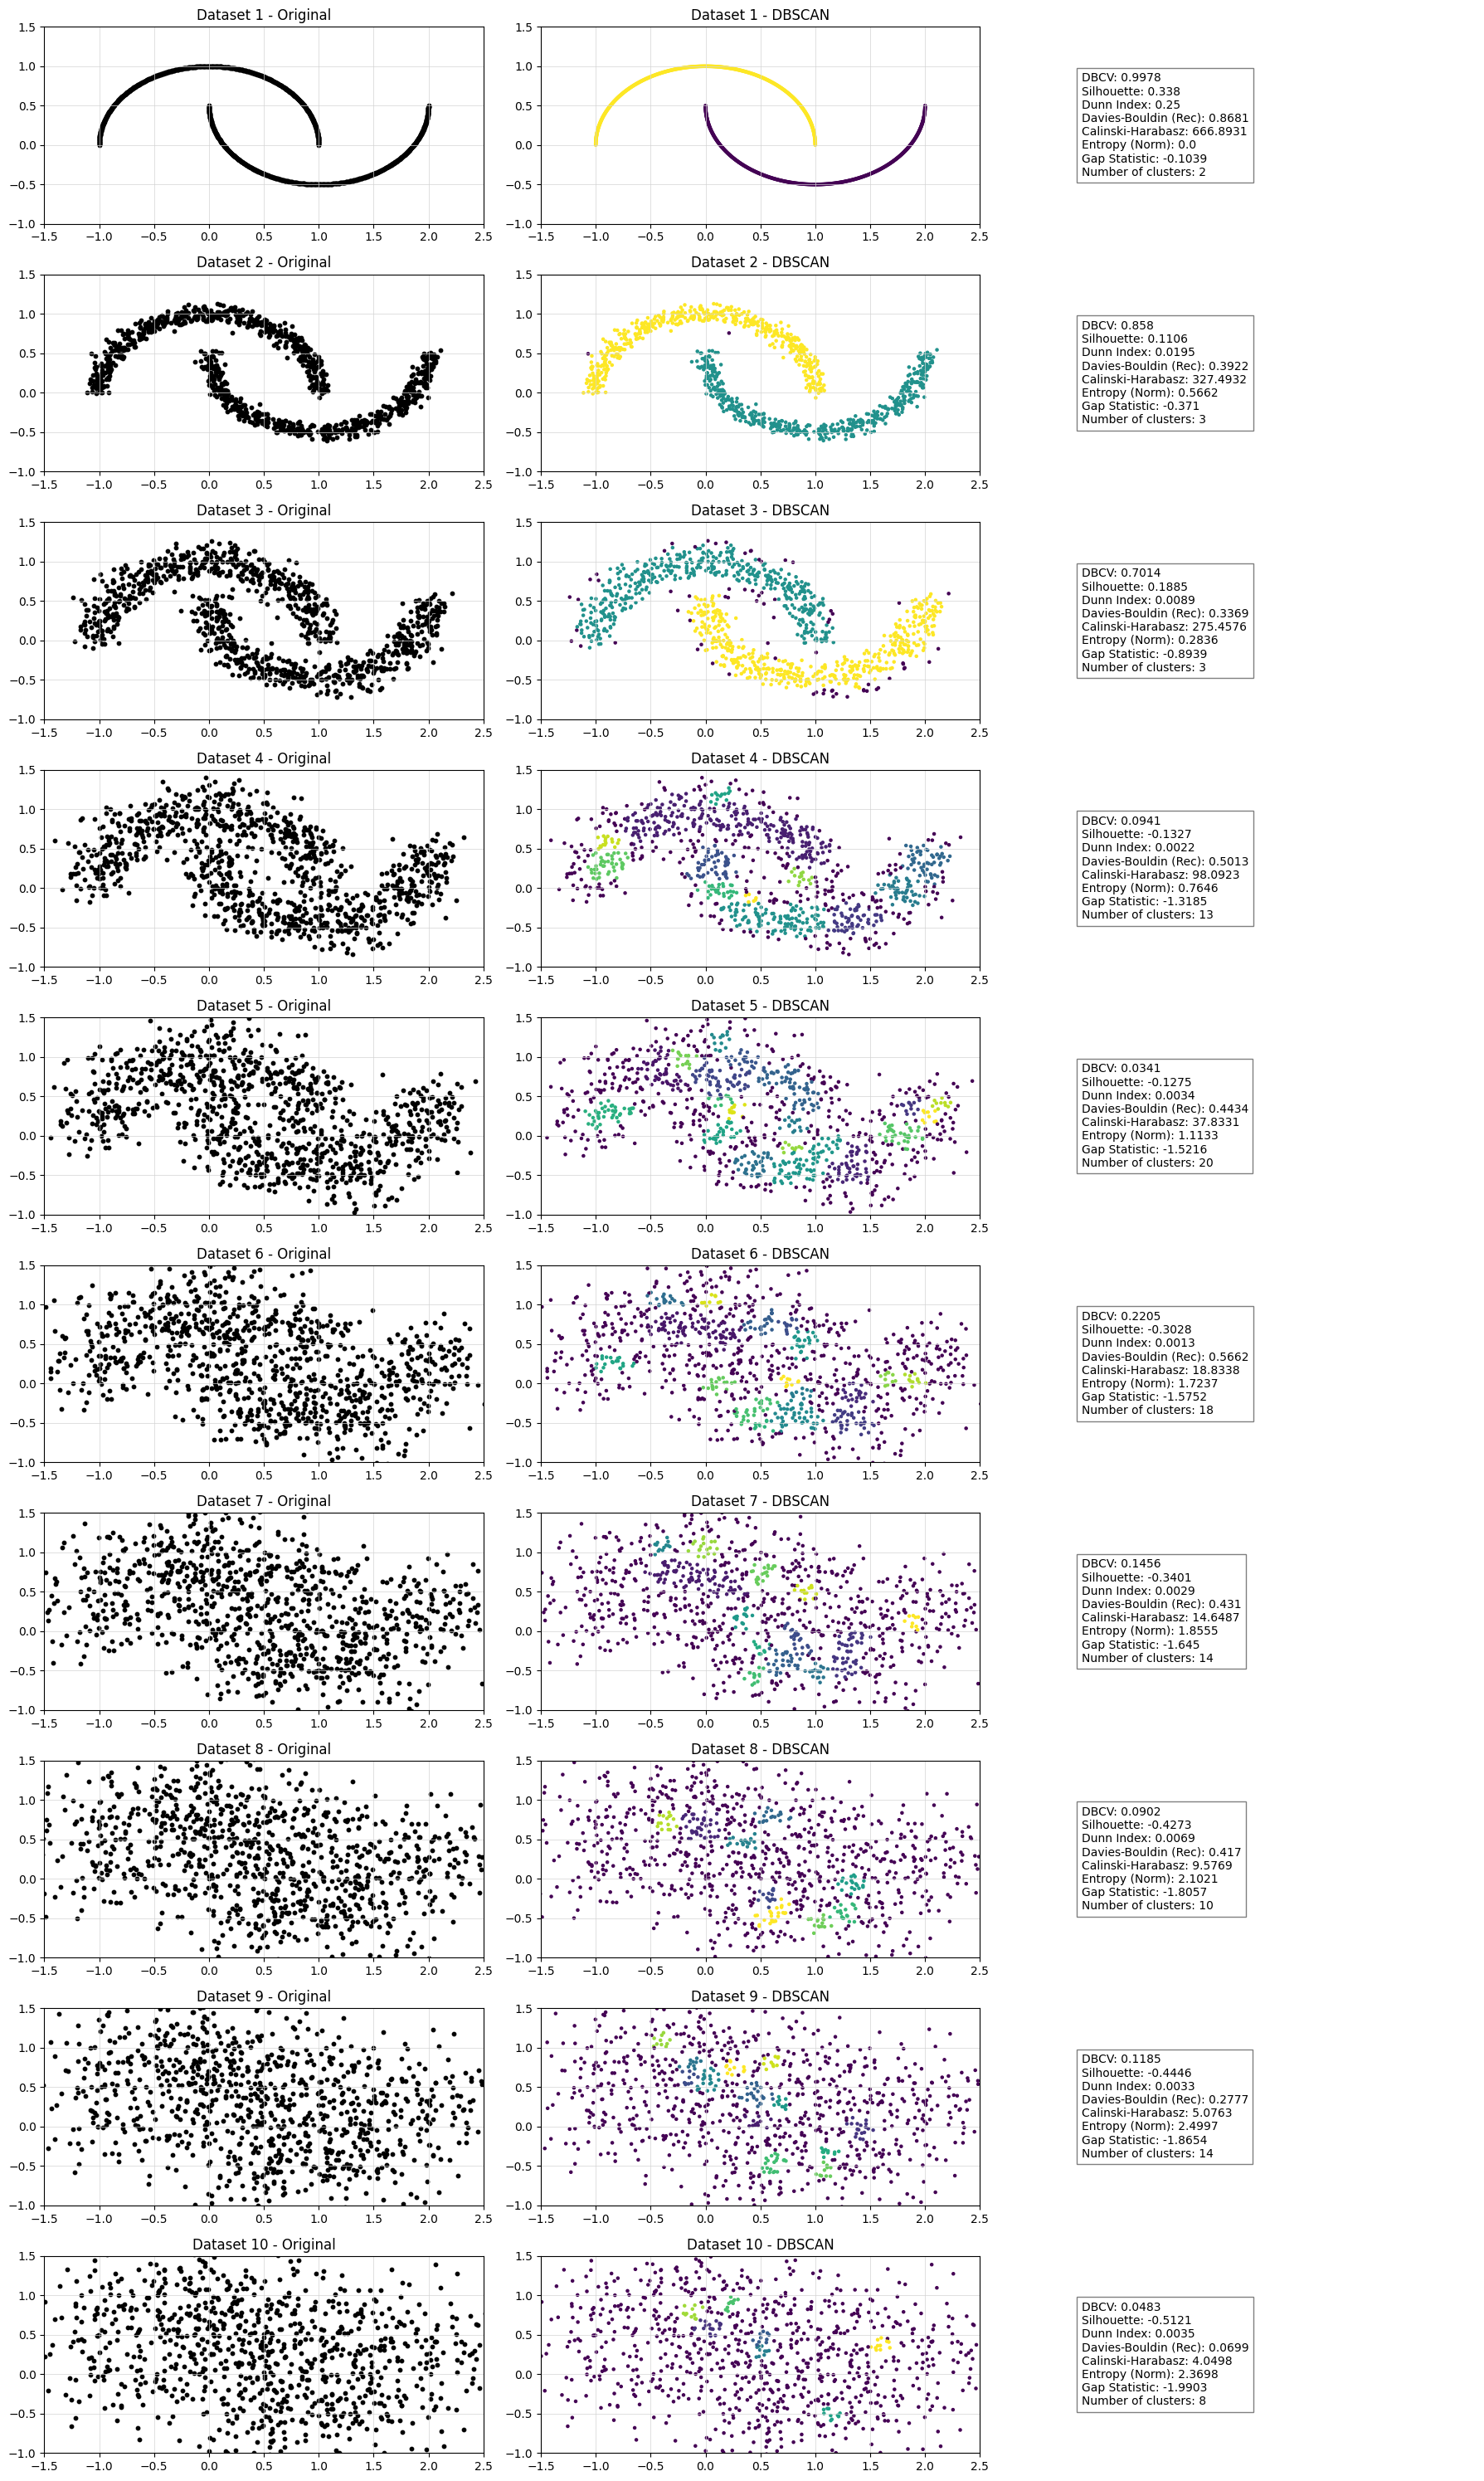

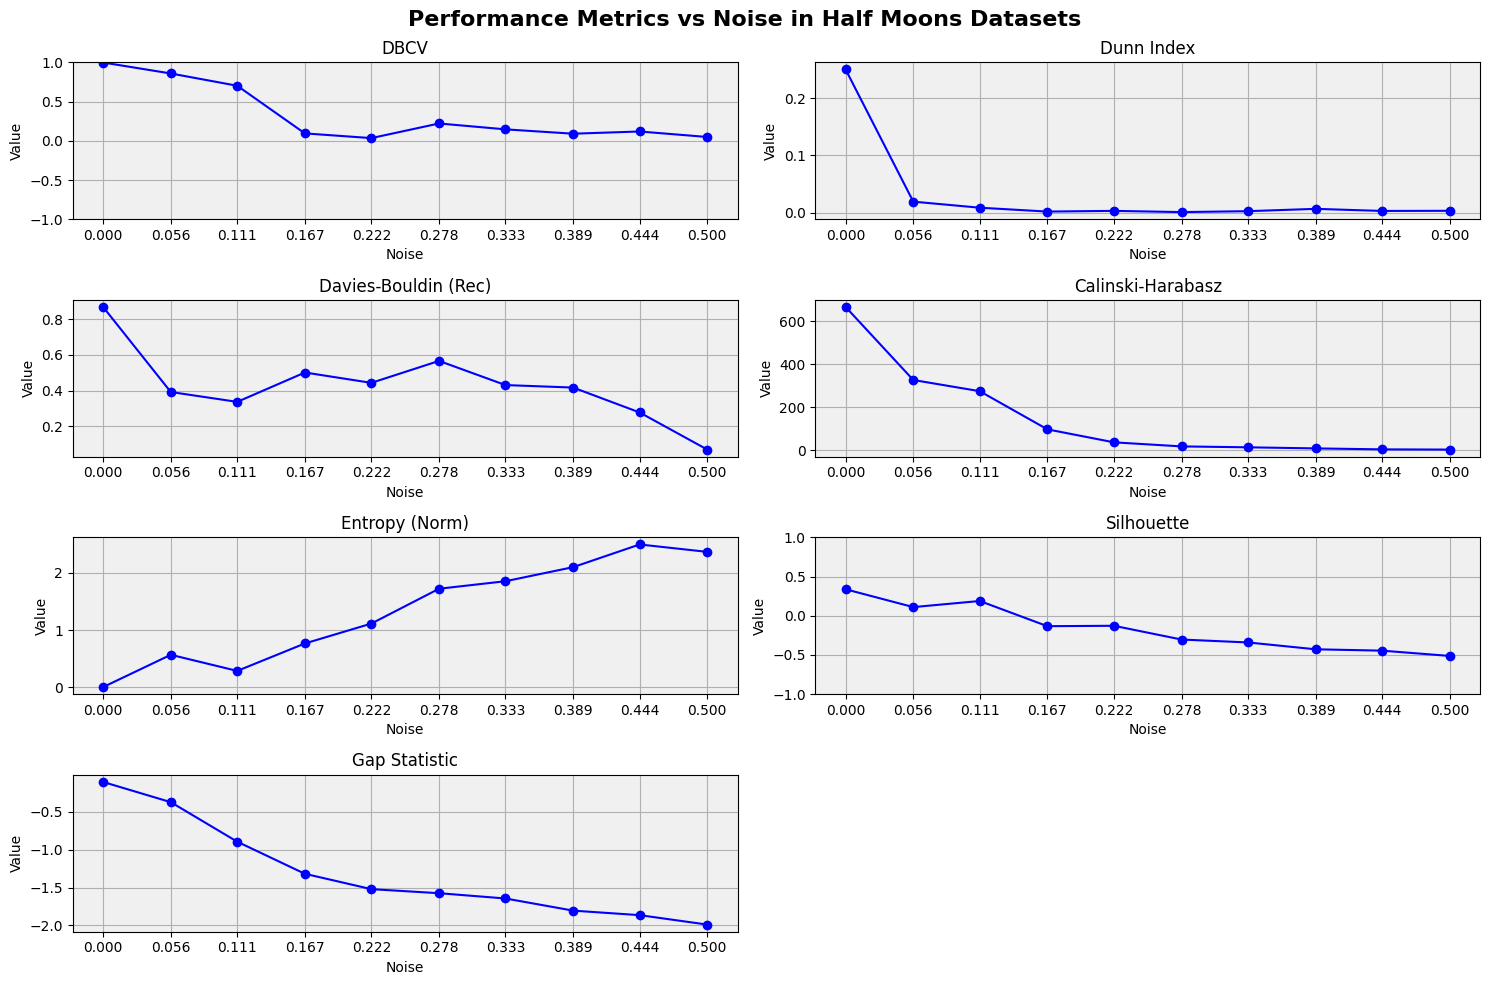

In [ ]:
datasets = generate_moon_datasets(30)
dbcv_total, dunn_total,davies_total, calinski_total,entropy_total, silhouette_total, gap_total = plot_datasets_with_clustering(datasets)
noise = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]

dbcv_total = list(zip(dbcv_total, noise))
dunn_total = list(zip(dunn_total, noise))
davies_total = list(zip(davies_total, noise))
calinski_total = list(zip(calinski_total, noise))
entropy_total = list(zip(entropy_total, noise))
silhouette_total = list(zip(silhouette_total, noise))
gap_total = list(zip(gap_total, noise))

data_list = [
    ("DBCV", dbcv_total),
    ("Dunn Index", dunn_total),
    ("Davies-Bouldin (Rec)", davies_total),
    ("Calinski-Harabasz", calinski_total),
    ("Entropy (Norm)", entropy_total),
    ("Silhouette", silhouette_total),
    ("Gap Statistic", gap_total)
]

plt.figure(figsize=(15, 10))

for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]

    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)

    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)

    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')

    if name in ["DBCV", "Silhouette"]:
        plt.ylim(-1, 1)

plt.suptitle("Performance Metrics vs Noise in Half Moons Datasets", fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

In [ ]:
#Modifica parametro tolerance --> tolerance_times
tolerance_times = 3
val_tolerence = 0.05
dict_decrease = {}
dict_moon = {}

for name, data in data_list:
  decreasing_count = 0
  equal_count = 0
  x_values = [val[0] for val in data]
  for i in range(len(x_values) - 1):
    if x_values[i] >= x_values[i+1]:
      decreasing_count += 1
    if x_values[i] == x_values[i+1]:
      equal_count += 1
  if (decreasing_count >= len(x_values) - tolerance_times) and equal_count < (len(x_values)-1):
    dict_moon[name] = 1
  else:
    dict_moon[name] = 0

dict_decrease["Half Moons"] = dict_moon
dict_decrease

{'Moon': {'DBCV': 1,
  'Dunn Index': 0,
  'Davies-Bouldin (Rec)': 1,
  'Calinski-Harabasz': 1,
  'Entropy (Norm)': 0,
  'Silhouette': 1,
  'Gap Statistic': 1}}

**Shifting Circles**

Eseguito su 1000 campioni con normal dbcv. Questo perchè fastdbcv da errori di duplicati in fase di calcolo.
CI vuole circa mezz'ora.

Se diminuimo il numero di campioni a 300 il tempo diminuisce notevolmente a 2 minuti.

con 1000 camponi min_samples = 20
con 300 campioni min_samples = 6

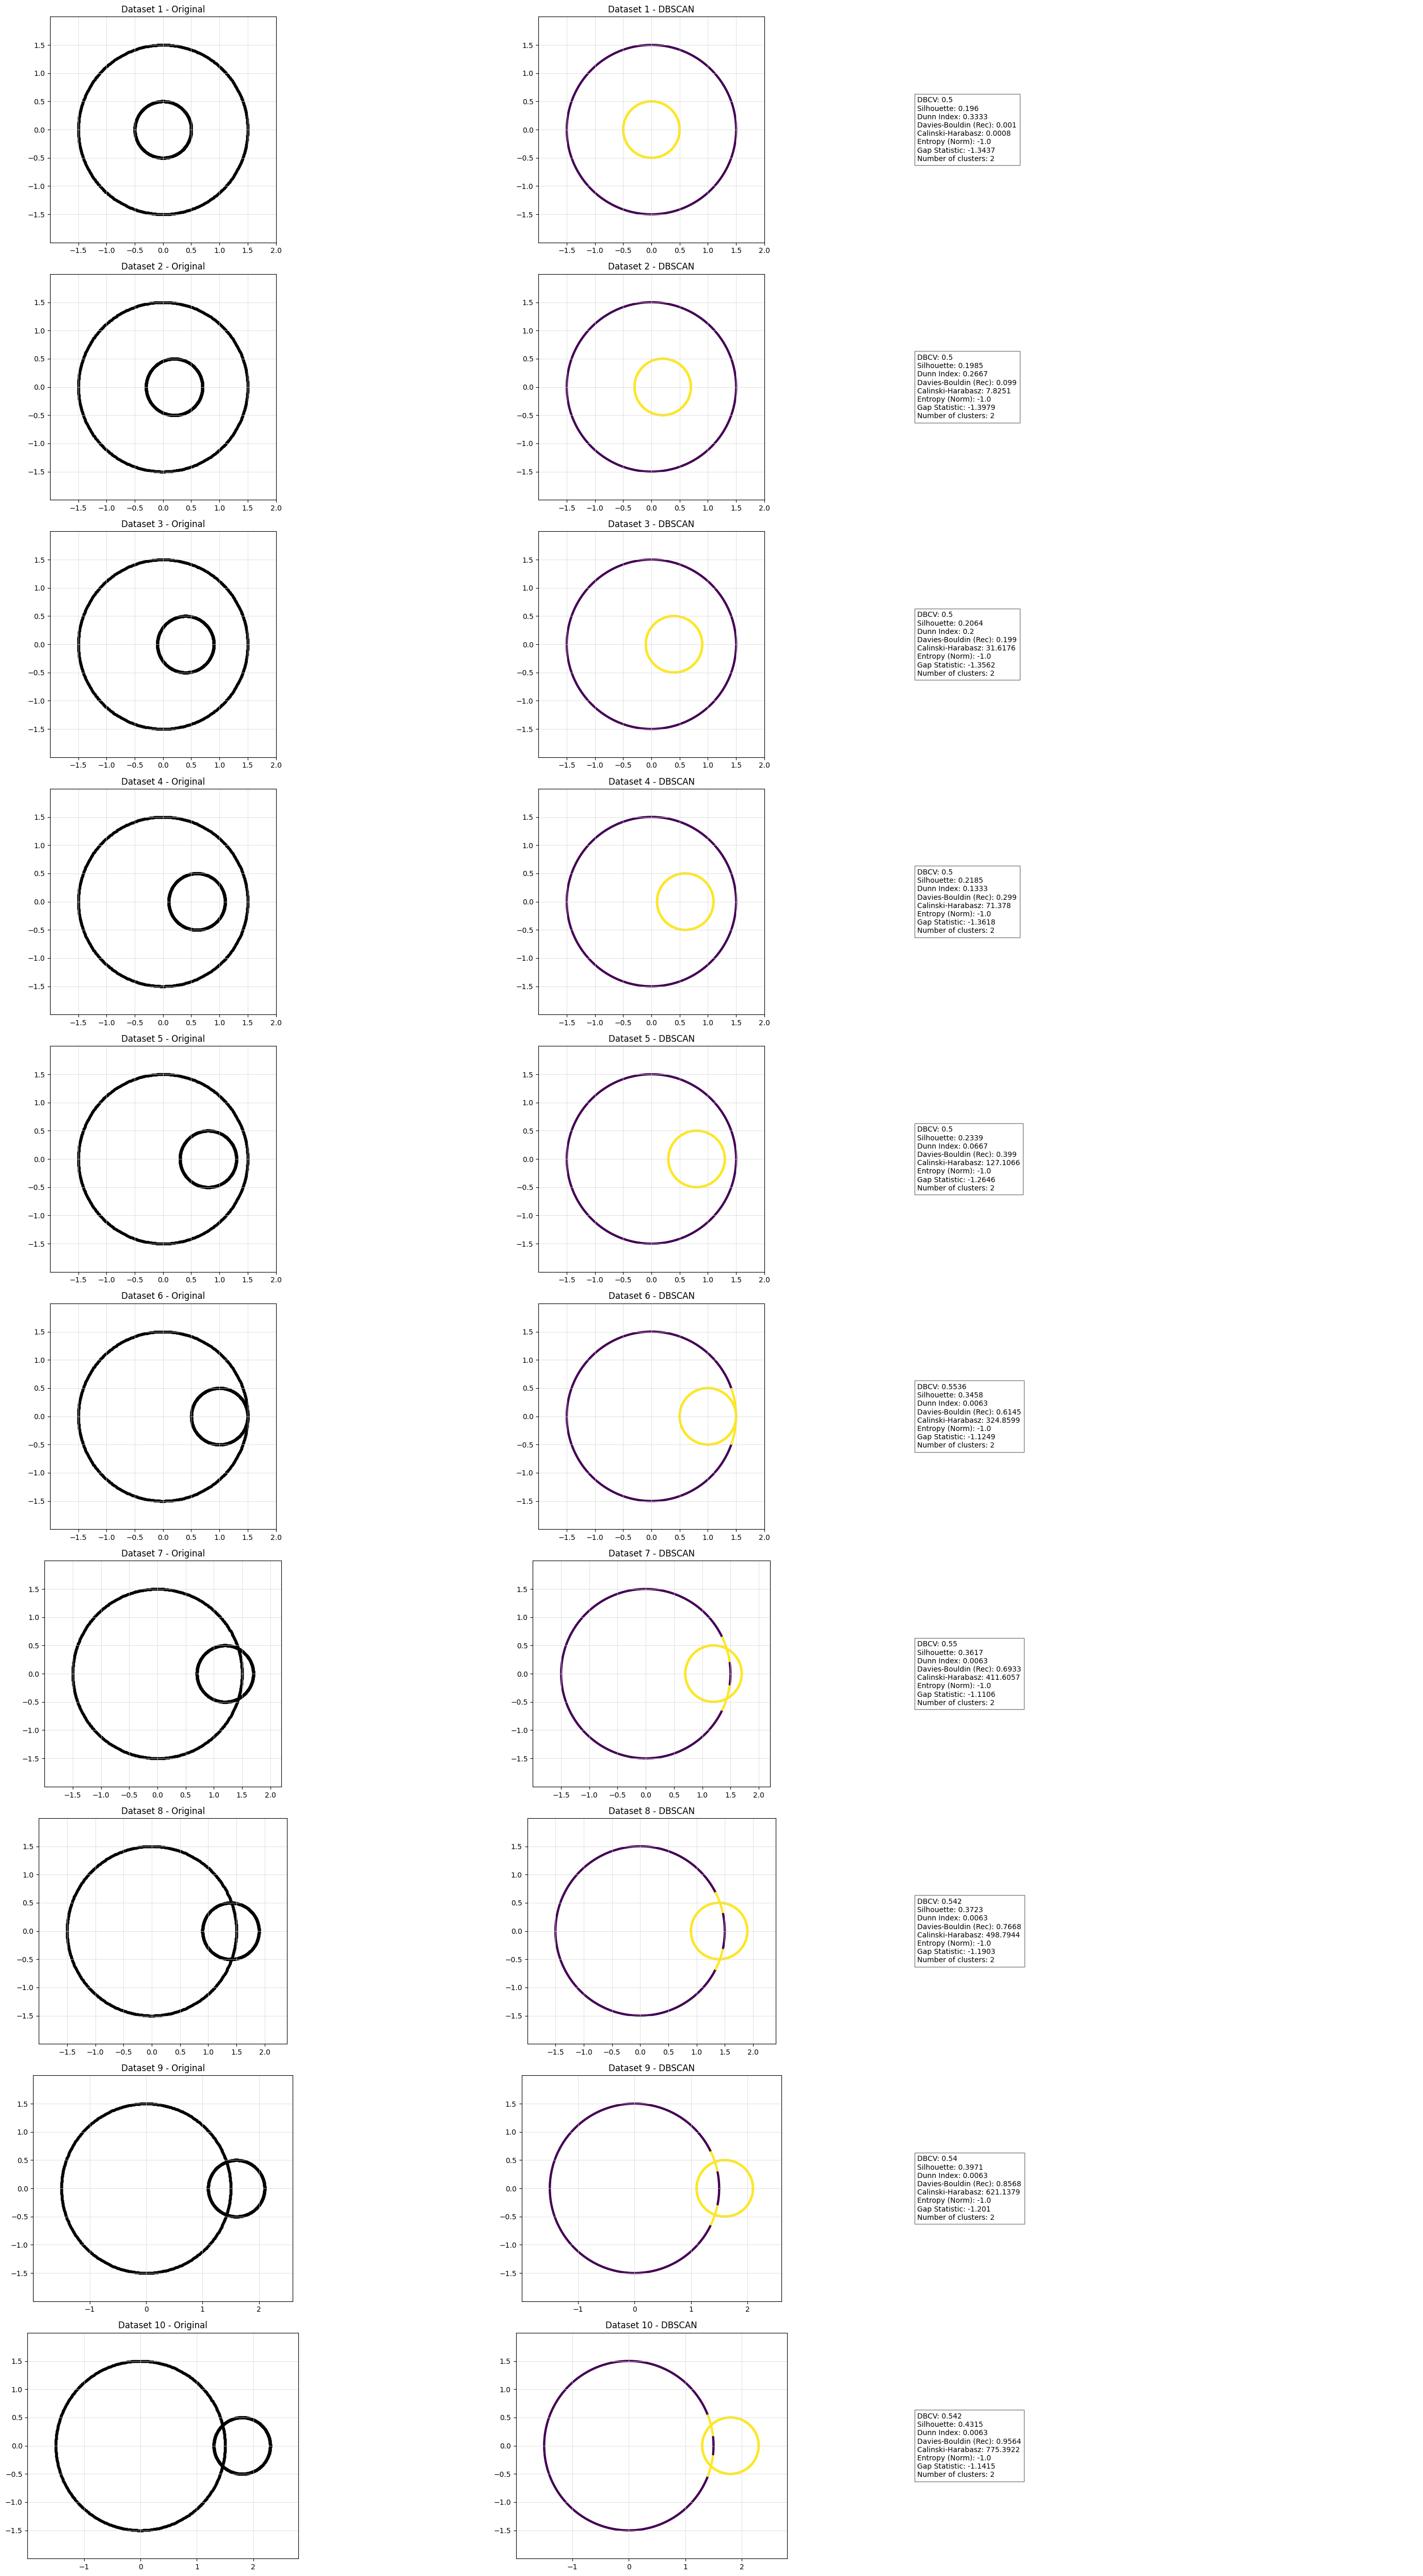

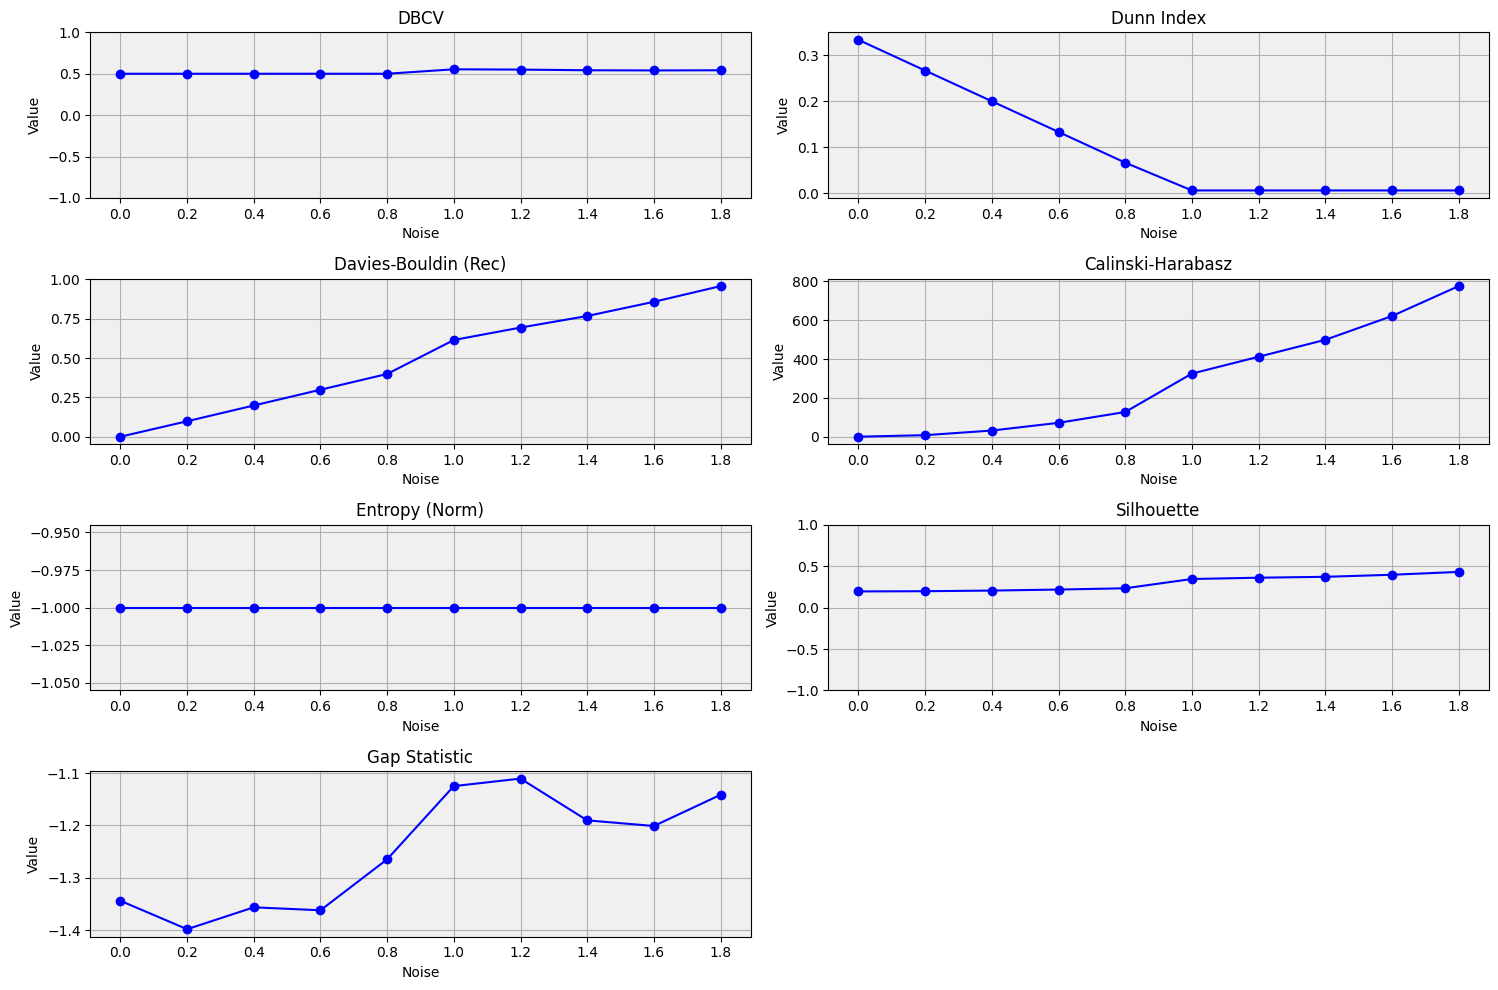

In [ ]:
n_datasets = 10
n_points_per_circle = 500
n_points_per_circle_inner = 500
inner_radius = 0.5
outer_radius = 1.5
initial_shift = (0, 0)
shift_increment = (0.2, 0)
datasets = generate_datasets_with_two_circles(n_datasets, n_points_per_circle, n_points_per_circle_inner, inner_radius, outer_radius, initial_shift, shift_increment)

dbcv_total, dunn_total,davies_total, calinski_total,entropy_total, silhouette_total, gap_total = plot_datasets_with_clustering_circle(datasets)

noise = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8]

dbcv_total = list(zip(dbcv_total, noise))
dunn_total = list(zip(dunn_total, noise))
davies_total = list(zip(davies_total, noise))
calinski_total = list(zip(calinski_total, noise))
entropy_total = list(zip(entropy_total, noise))
silhouette_total = list(zip(silhouette_total, noise))
gap_total = list(zip(gap_total, noise))

data_list = [
    ("DBCV", dbcv_total),
    ("Dunn Index", dunn_total),
    ("Davies-Bouldin (Rec)", davies_total),
    ("Calinski-Harabasz", calinski_total),
    ("Entropy (Norm)", entropy_total),
    ("Silhouette", silhouette_total),
    ("Gap Statistic", gap_total)
]

plt.figure(figsize=(15, 10))

for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)

    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)

    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')

    if name in ["DBCV", "Silhouette"]:
        plt.ylim(-1, 1)

plt.suptitle("Performance Metrics vs Noise in Shifting Circles Datasets", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
dict_shifting_circle = {}

for name, data in data_list:
  decreasing_count = 0
  equal_count = 0
  x_values = [val[0] for val in data]
  for i in range(len(x_values) - 1):
    if x_values[i] >= x_values[i+1]:
      decreasing_count += 1
    if x_values[i] == x_values[i+1]:
      equal_count += 1
  if (decreasing_count >= len(x_values) - tolerance_times) and equal_count < (len(x_values)-1):
    dict_shifting_circle[name] = 1
  else:
    dict_shifting_circle[name] = 0

dict_decrease["Shifting Circles"] = dict_shifting_circle
dict_decrease

DBCV
4
10
Dunn Index
0
10


{'Moon': {'DBCV': 1,
  'Dunn Index': 0,
  'Davies-Bouldin (Rec)': 1,
  'Calinski-Harabasz': 1,
  'Entropy (Norm)': 0,
  'Silhouette': 1,
  'Gap Statistic': 1},
 'Shifting Circle': {'DBCV': 1,
  'Dunn Index': 1,
  'Davies-Bouldin (Rec)': 0,
  'Calinski-Harabasz': 0,
  'Entropy (Norm)': 0,
  'Silhouette': 0,
  'Gap Statistic': 0}}

**Sparse Circles**

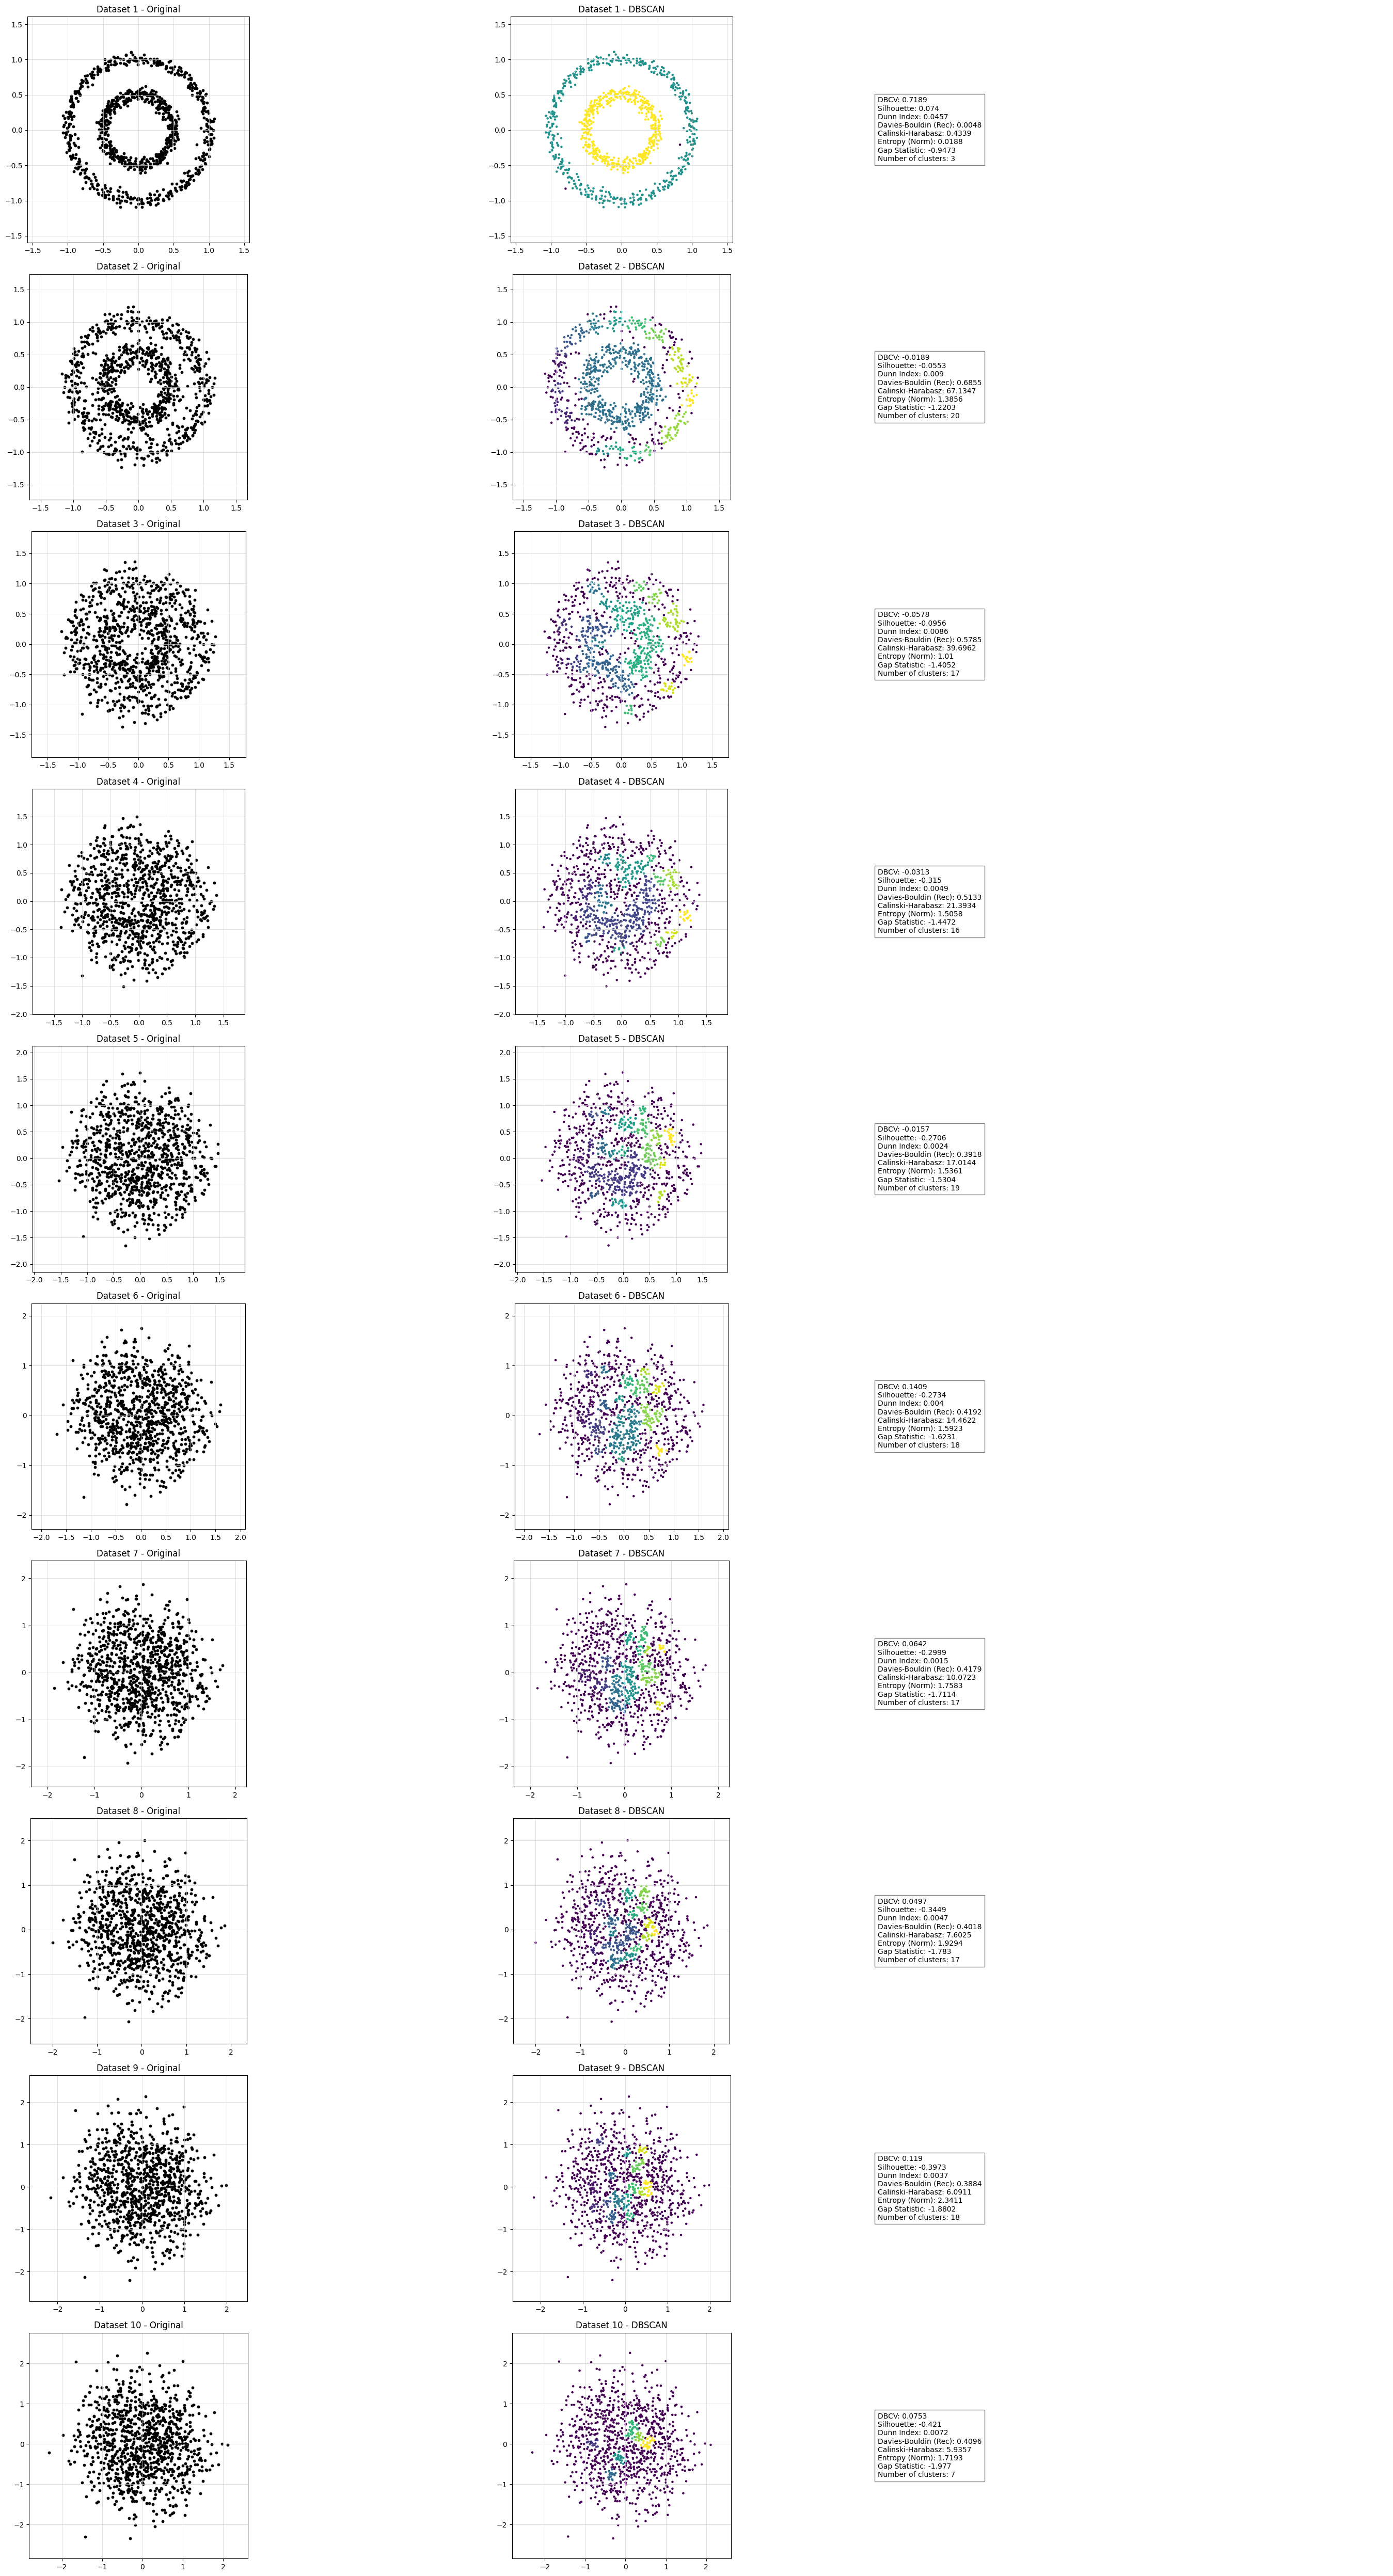

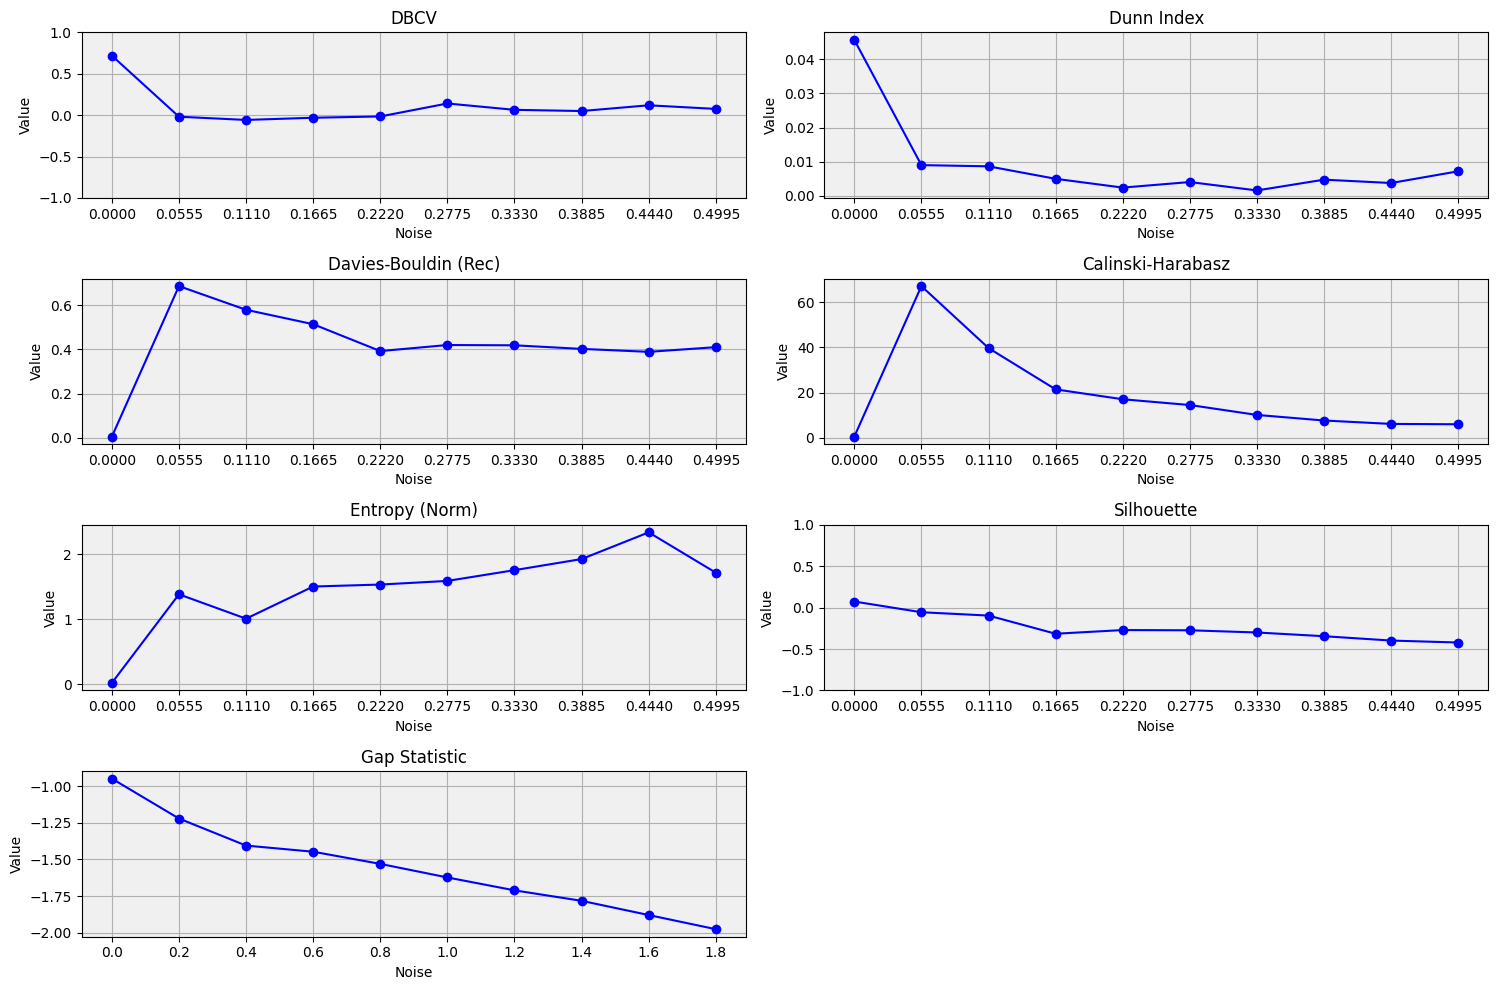

In [ ]:
n_datasets = 10
n_samples = 1000
noise_increment = 0.0555
seed = 4

#noise_levels = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]


datasets = generate_noisy_circles(n_datasets, n_samples, noise_increment, seed)


dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total = plot_datasets_with_clustering_noisy_circles(datasets)
noise_levels = [i * noise_increment for i in range(n_datasets)]

dbcv_total = list(zip(dbcv_total, noise_levels))
dunn_total = list(zip(dunn_total, noise_levels))
davies_total = list(zip(davies_total, noise_levels))
calinski_total = list(zip(calinski_total, noise_levels))
entropy_total = list(zip(entropy_total, noise_levels))
silhouette_total = list(zip(silhouette_total, noise_levels))
gap_total = list(zip(gap_total, noise))
data_list = [
    ("DBCV", dbcv_total),
    ("Dunn Index", dunn_total),
    ("Davies-Bouldin (Rec)", davies_total),
    ("Calinski-Harabasz", calinski_total),
    ("Entropy (Norm)", entropy_total),
    ("Silhouette", silhouette_total),
    ("Gap Statistic", gap_total)

]

plt.figure(figsize=(15, 10))

for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)

    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)

    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')

    if name in ["DBCV", "Silhouette"]:
        plt.ylim(-1, 1)

plt.suptitle("Performance Metrics vs Noise in Sparse Circles Datasets", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
dict_sparse_circle = {}

for name, data in data_list:
  decreasing_count = 0
  equal_count = 0
  x_values = [val[0] for val in data]
  for i in range(len(x_values) - 1):
    if x_values[i] >= x_values[i+1]:
      decreasing_count += 1
    if x_values[i] == x_values[i+1]:
      equal_count += 1
  if (decreasing_count >= len(x_values) - tolerance_times) and equal_count < (len(x_values)-1):
    dict_sparse_circle[name] = 1
  else:
    dict_sparse_circle[name] = 0

dict_decrease["Sparse Circles"] = dict_sparse_circle
dict_decrease

{'Moon': {'DBCV': 1,
  'Dunn Index': 0,
  'Davies-Bouldin (Rec)': 1,
  'Calinski-Harabasz': 1,
  'Entropy (Norm)': 0,
  'Silhouette': 1,
  'Gap Statistic': 1},
 'Shifting Circle': {'DBCV': 1,
  'Dunn Index': 1,
  'Davies-Bouldin (Rec)': 0,
  'Calinski-Harabasz': 0,
  'Entropy (Norm)': 0,
  'Silhouette': 0,
  'Gap Statistic': 0},
 'Sparse Circle': {'DBCV': 0,
  'Dunn Index': 0,
  'Davies-Bouldin (Rec)': 0,
  'Calinski-Harabasz': 1,
  'Entropy (Norm)': 0,
  'Silhouette': 1,
  'Gap Statistic': 1}}

**Tulipan**

Inserire dataset con punti più raggruppati

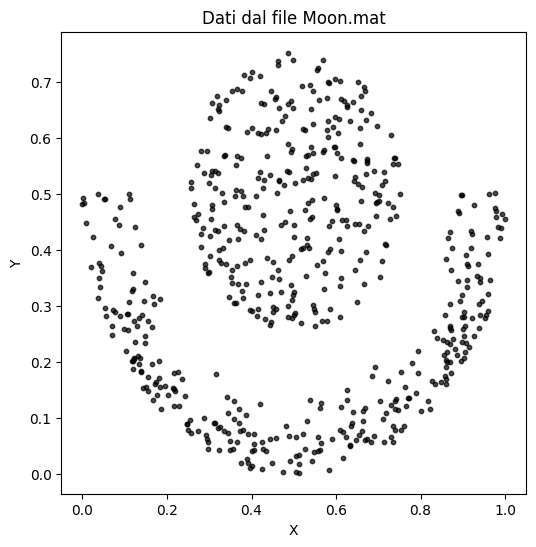

In [ ]:
# preso da https://github.com/adanjoga/cvik-toolbox/tree/master/datasets
#paper A survey of cluster validity indices for automatic data clustering using differential evolution

data = scipy.io.loadmat('/content/Moon.mat')

X = data['data'][:, 0]
Y = data['data'][:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(X, Y, color='black', alpha=0.7, s=10)
plt.title("Dati dal file Moon.mat")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


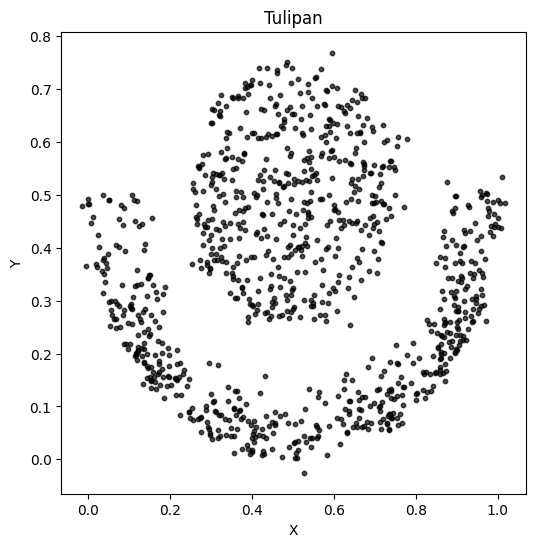

In [ ]:
data = scipy.io.loadmat('/content/Moon.mat')
X = data['data'][:, 0]
Y = data['data'][:, 1]


original_points = np.column_stack((X, Y))

# Generate 400 new points by sampling around the existing data
# Adding some random noise to keep them close to the existing distribution
num_new_points = 400
new_points = original_points[np.random.choice(original_points.shape[0], num_new_points)] + np.random.normal(0, 0.02, (num_new_points, 2))
augmented_data = np.vstack((original_points, new_points))
X_augmented = augmented_data[:, 0]
Y_augmented = augmented_data[:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(X_augmented, Y_augmented, color='black', alpha=0.7, s=10)
plt.title("Tulipan")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

AL dataset originale sono dati aggiutni 400 punti (essendo 600 quelli attuali). I 600 attualirimangono fissi, viene aggiunto del rumore ai 400 inseriti , normalizzando il loro valore tra 0 e 1 in modo da essere inseritiall'interno del tulipano e non all'esterno

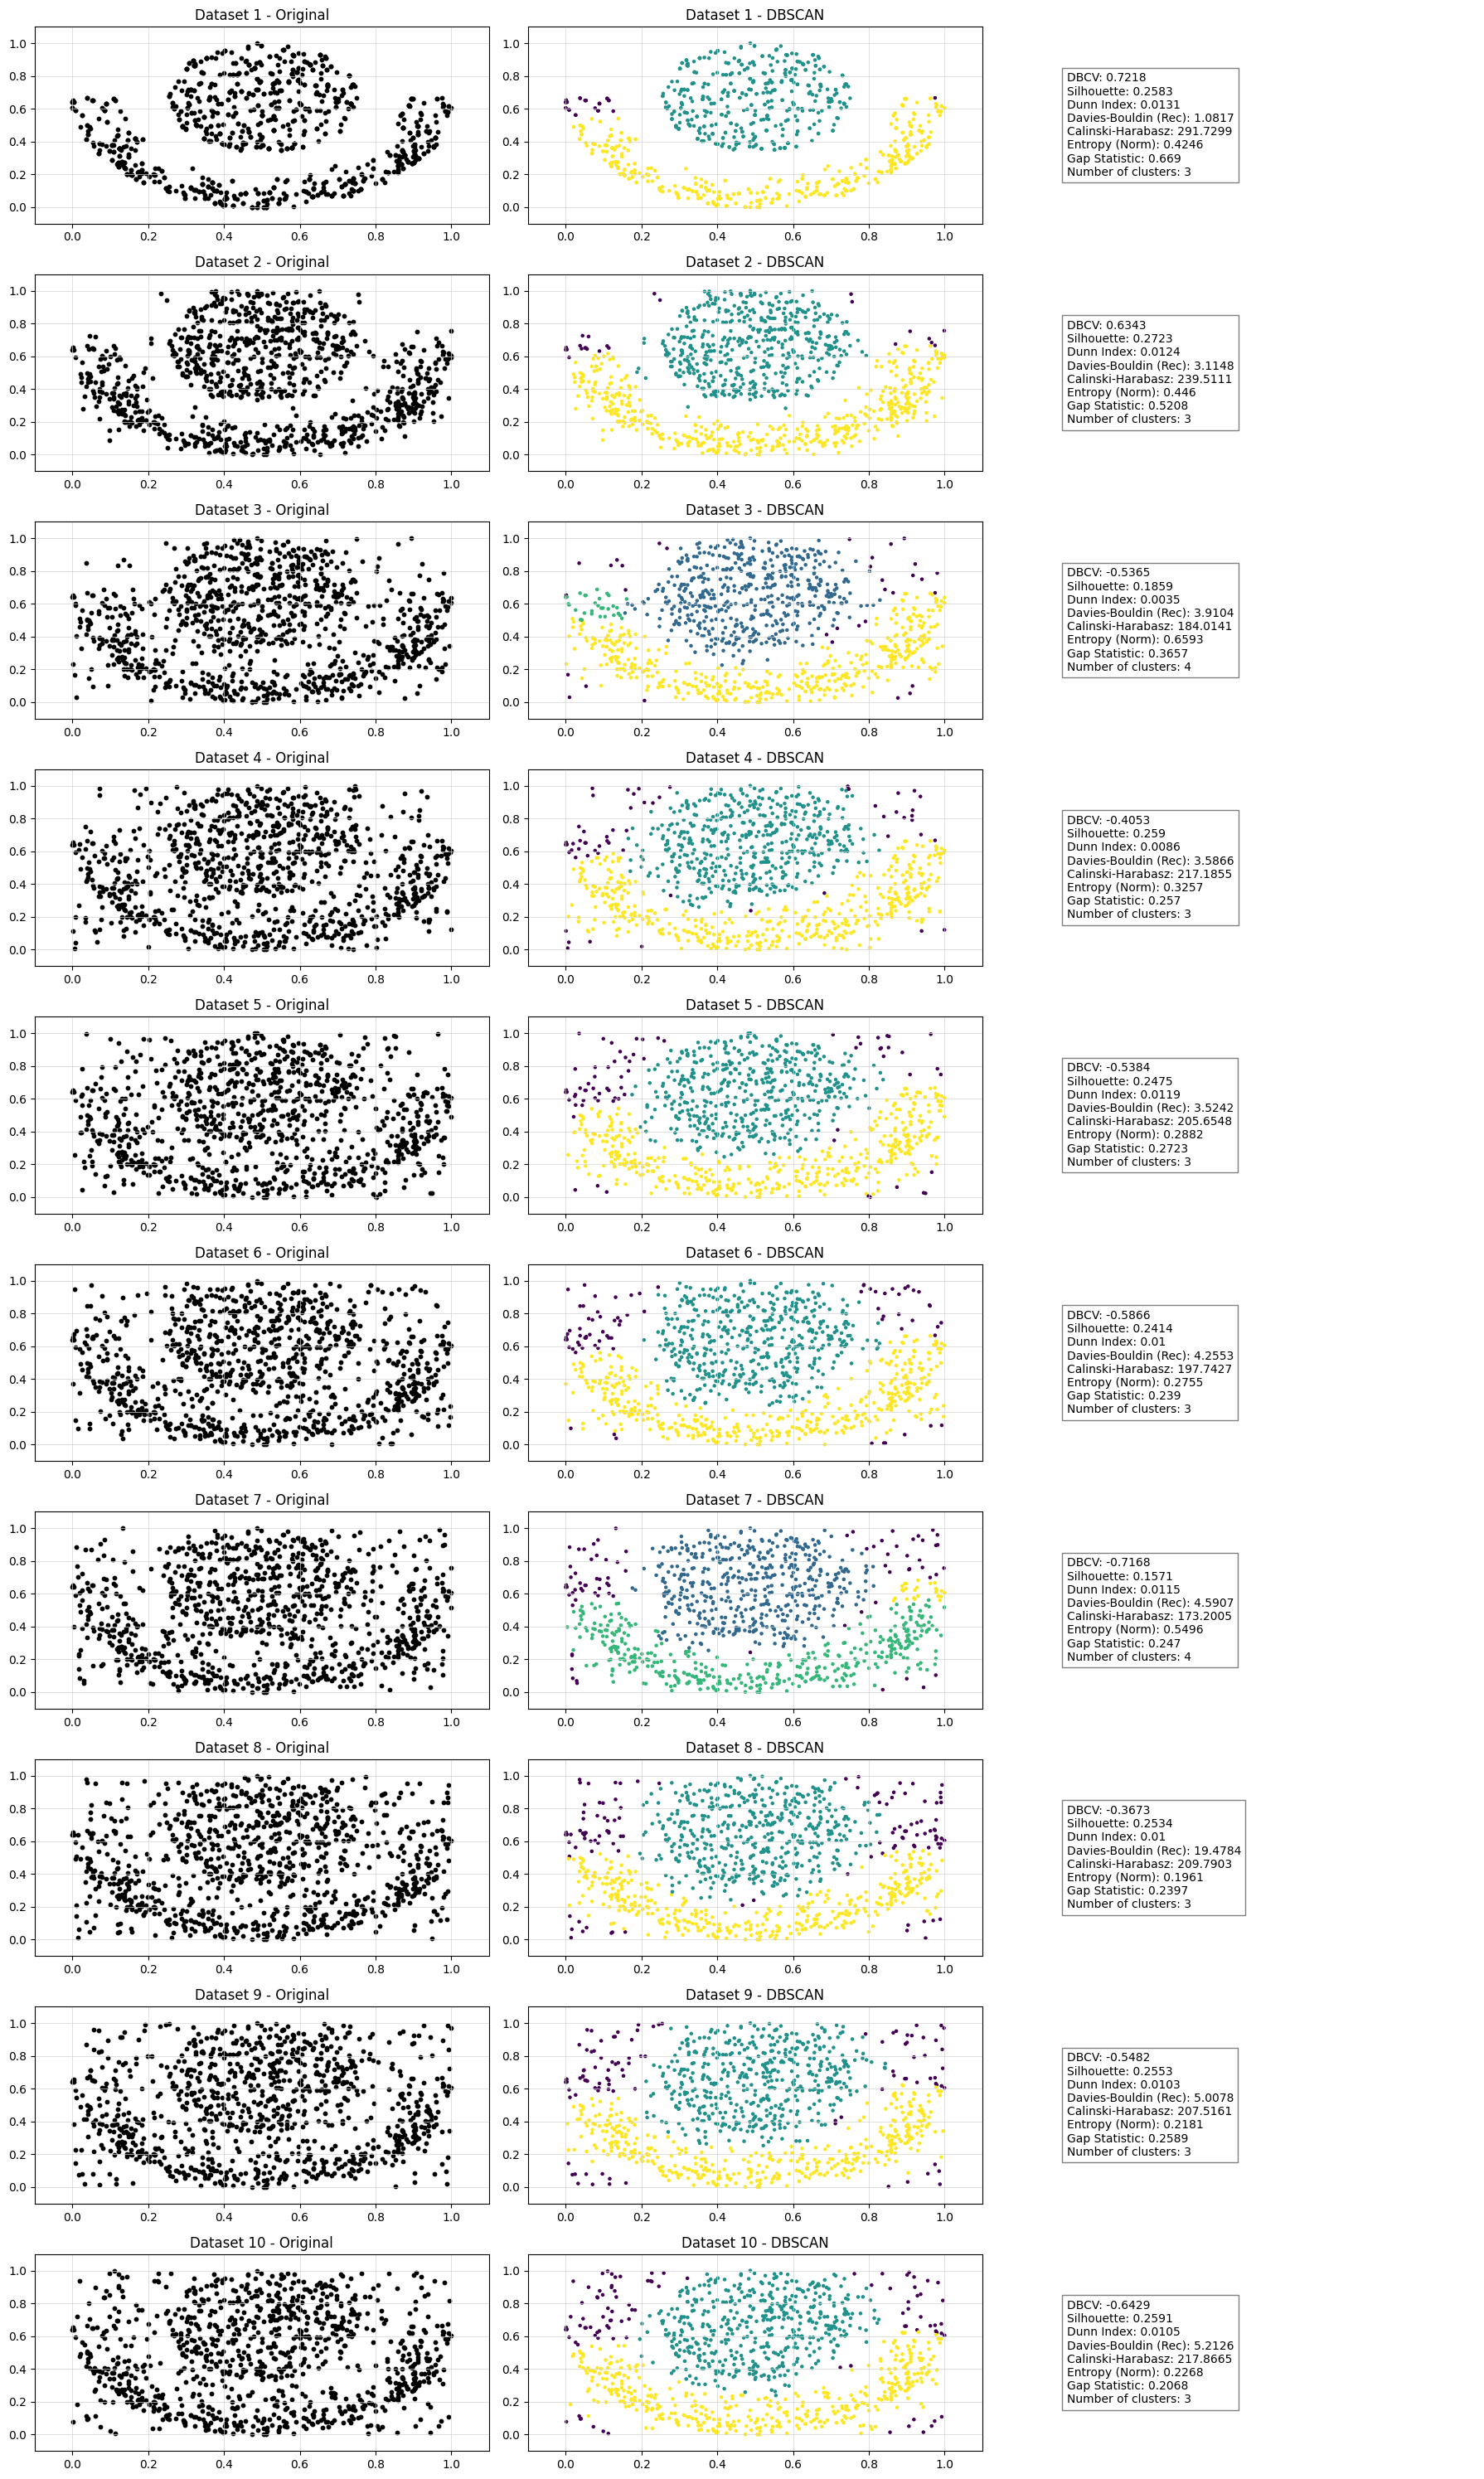

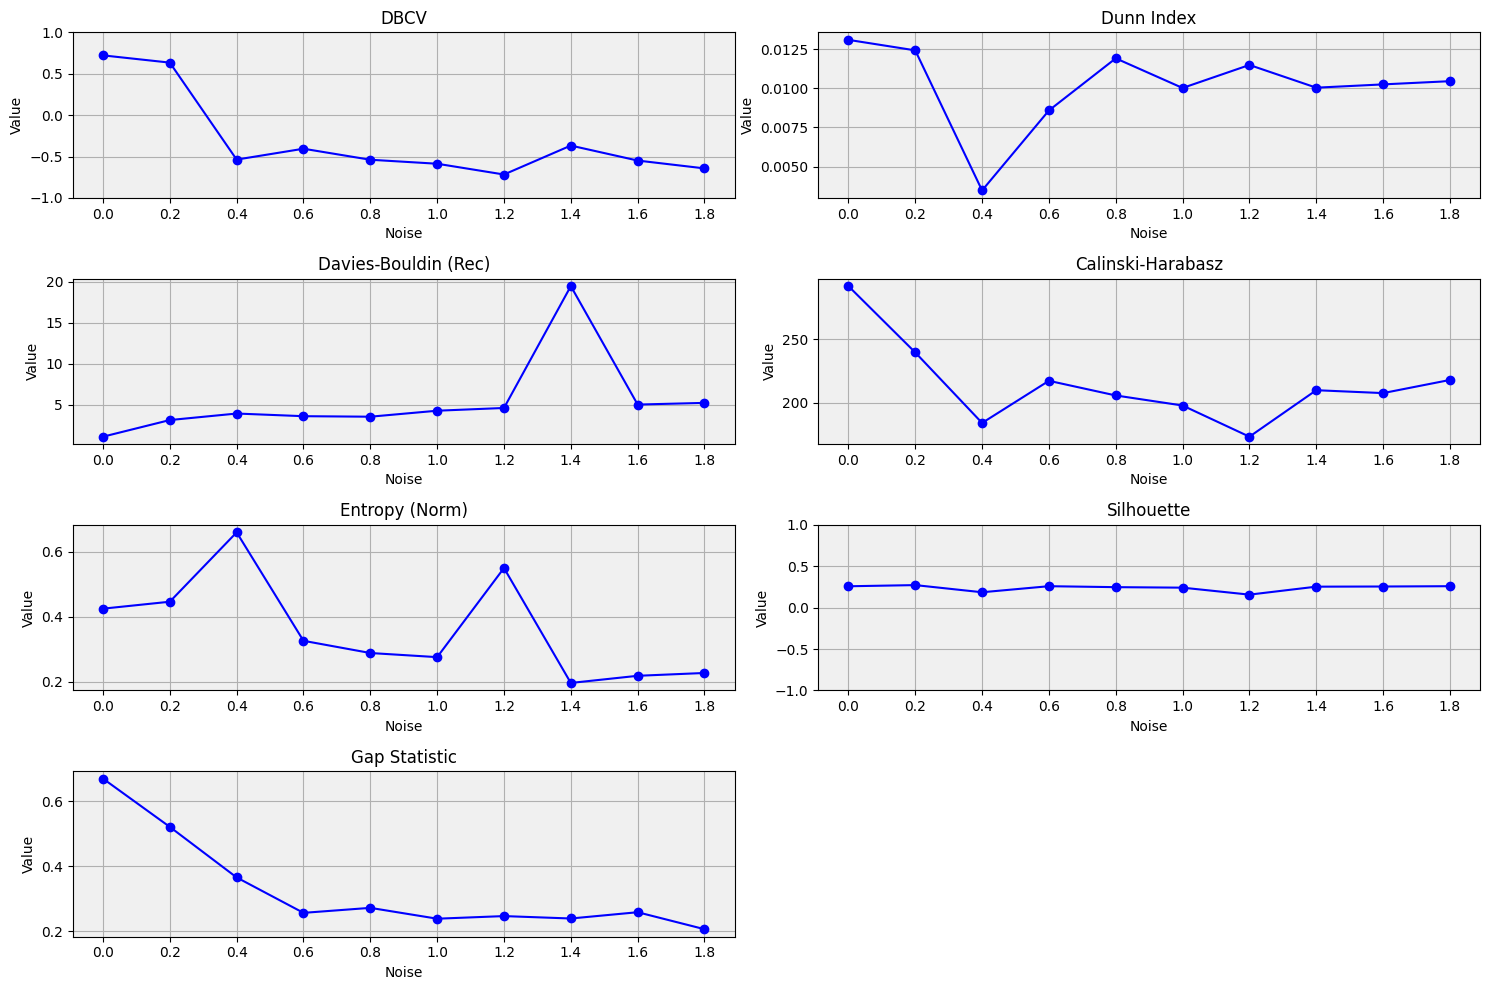

In [ ]:
data = scipy.io.loadmat('/content/Moon.mat')
X = data['data'][:, 0]
Y = data['data'][:, 1]
original_points = np.column_stack((X, Y))

min_vals = original_points.min(axis=0)
max_vals = original_points.max(axis=0)
normalized_points = (original_points - min_vals) / (max_vals - min_vals)

datasets = generate_augmented_datasets(30)
results = analyze_datasets_tulipan(datasets)
dbcv_total, dunn_total, davies_total, calinski_total, entropy_total, silhouette_total, gap_total = plot_datasets_with_clustering_tulipan(datasets, results)

noise_levels = [0.0, 0.056, 0.111, 0.167, 0.222, 0.278, 0.333, 0.389, 0.444, 0.5]

dbcv_total = list(zip(dbcv_total, noise))
dunn_total = list(zip(dunn_total, noise))
davies_total = list(zip(davies_total, noise))
calinski_total = list(zip(calinski_total, noise))
entropy_total = list(zip(entropy_total, noise))
silhouette_total = list(zip(silhouette_total, noise))
gap_total = list(zip(gap_total, noise))

data_list = [
    ("DBCV", dbcv_total),
    ("Dunn Index", dunn_total),
    ("Davies-Bouldin (Rec)", davies_total),
    ("Calinski-Harabasz", calinski_total),
    ("Entropy (Norm)", entropy_total),
    ("Silhouette", silhouette_total),
    ("Gap Statistic", gap_total)
]

plt.figure(figsize=(15, 10))
for i, (name, data) in enumerate(data_list):
    plt.subplot(4, 2, i + 1)
    y_values = [val[0] for val in data]
    x_values = [val[1] for val in data]
    plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
    plt.title(name)
    plt.xlabel('Noise')
    plt.ylabel('Value')
    plt.xticks(x_values)
    plt.grid(True)
    plt.gca().set_facecolor('#f0f0f0')
    if name in ["DBCV", "Silhouette"]:
        plt.ylim(-1, 1)

plt.suptitle("Performance Metrics vs Noise in Tulipan Datasets", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


In [ ]:
dict_tulipan = {}

for name, data in data_list:
  decreasing_count = 0
  equal_count = 0
  x_values = [val[0] for val in data]
  for i in range(len(x_values) - 1):
    if x_values[i] >= x_values[i+1]:
      decreasing_count += 1
    if x_values[i] == x_values[i+1]:
      equal_count += 1
  if (decreasing_count >= len(x_values) - tolerance_times) and equal_count < (len(x_values)-1):
    dict_tulipan[name] = 1
  else:
    dict_tulipan[name] = 0

dict_decrease["Tulipan"] = dict_tulipan
dict_decrease

{'Moon': {'DBCV': 1,
  'Dunn Index': 0,
  'Davies-Bouldin (Rec)': 1,
  'Calinski-Harabasz': 1,
  'Entropy (Norm)': 0,
  'Silhouette': 1,
  'Gap Statistic': 1},
 'Shifting Circle': {'DBCV': 1,
  'Dunn Index': 1,
  'Davies-Bouldin (Rec)': 0,
  'Calinski-Harabasz': 0,
  'Entropy (Norm)': 0,
  'Silhouette': 0,
  'Gap Statistic': 0},
 'Sparse Circle': {'DBCV': 0,
  'Dunn Index': 0,
  'Davies-Bouldin (Rec)': 0,
  'Calinski-Harabasz': 1,
  'Entropy (Norm)': 0,
  'Silhouette': 1,
  'Gap Statistic': 1},
 'Tulipan': {'DBCV': 1,
  'Dunn Index': 0,
  'Davies-Bouldin (Rec)': 0,
  'Calinski-Harabasz': 0,
  'Entropy (Norm)': 0,
  'Silhouette': 0,
  'Gap Statistic': 0}}

In [ ]:
df_decrease = pd.DataFrame(dict_decrease)
df_decrease['Total'] = df_decrease.sum(axis=1)
df_decrease = df_decrease.sort_values(by='Total', ascending=False)

print("Tab.1 Improving table:\n")
df_decrease

Moon  Shifting Circle  Sparse Circle  Tulipan  Total
DBCV                     1                1              0        1      3
Calinski-Harabasz        1                0              1        0      2
Silhouette               1                0              1        0      2
Gap Statistic            1                0              1        0      2
Dunn Index               0                1              0        0      1
Davies-Bouldin (Rec)     1                0              0        0      1
Entropy (Norm)           0                0              0        0      0

#**EHRs**

In [ ]:
neuroblastoma=pd.read_csv("/content/10_7717_peerj_5665_dataYM2018_neuroblastoma.csv")
diabetes=pd.read_csv("/content/journal.pone.0216416_Takashi2019_diabetes_type1_dataset_preprocessed.csv")
sepsis=pd.read_csv("/content/journal.pone.0148699_S1_Text_Sepsis_SIRS_EDITED.csv")
heart_failure=pd.read_csv("/content/journal.pone.0158570_S2File_depression_heart_failure_v2.csv")
cardiac_arrest=pd.read_csv("/content/journal.pone.0175818_S1Dataset_Spain_cardiac_arrest_EDITED..csv")
df_metrics=pd.DataFrame()

metric_colors = {
    "DBCV Score": '#1f77b4',
    "Silhouette": '#ff7f0e',
    "Dunn Index": '#2ca02c',
    "Davies-Bouldin Norm": '#d62728',
    "Calinski-Harabasz": '#9467bd',
    "Shannon Entropy Norm": '#8c564b',
    "Optimal Gap Statistic": '#e377c2',
    "Clustering Truth": '#7f7f7f',
    "ARI": '#bcbd22'
}

metrics = [
    "DBCV Score", "Silhouette", "Dunn Index", "Davies-Bouldin Norm",
    "Calinski-Harabasz", "Entropy Norm", "Gap Statistic"
]

clustering_methods = ["HDBSCAN", "DBSCAN", "Meanshift", "HDBSCAN_default", "DBSCAN_default", "Meanshift_default"]

pairs = [
    ("HDBSCAN", "HDBSCAN_default"),
    ("DBSCAN", "DBSCAN_default"),
    ("Meanshift", "Meanshift_default")
]


#**Neuroblastoma**

In [ ]:
neuroblastoma = neuroblastoma.dropna(thresh=neuroblastoma.shape[1] - 2)
numerical_features = neuroblastoma.columns
scaler_minmax = MinMaxScaler()
neuroblastoma_scaled = neuroblastoma.copy()
neuroblastoma_scaled[numerical_features] = scaler_minmax.fit_transform(neuroblastoma[numerical_features])
neuroblastoma_scaled.reset_index(drop=True, inplace=True)
neuroblastoma_scaled.drop_duplicates(inplace=True)
df_metrics_neuroblastoma = pd.DataFrame()
neuroblastoma_scaled

age  sex  site  stage  risk  time_months  \
0    1.0  0.0   0.0    1.0   1.0     0.060606   
1    1.0  0.0   0.0    1.0   1.0     0.181818   
2    0.5  0.0   0.0    1.0   1.0     0.242424   
3    0.5  0.0   0.0    1.0   1.0     0.070707   
4    0.5  0.0   0.0    1.0   1.0     0.464646   
..   ...  ...   ...    ...   ...          ...   
164  0.0  0.0   0.0    0.0   0.0     0.353535   
165  0.5  0.0   0.0    0.0   0.0     0.171717   
166  0.5  1.0   0.5    0.0   0.0     0.373737   
167  0.5  1.0   0.5    0.0   0.0     0.363636   
168  0.0  0.0   0.0    0.0   0.0     0.313131   

     autologous_stem_cell_transplantation  radiation  \
0                                     0.0        0.0   
1                                     0.0        1.0   
2                                     0.0        1.0   
3                                     0.0        0.0   
4                                     1.0        1.0   
..                                    ...        ...   
164                                   0.0        0.0   
165                                   0.0        0.0   
166                                   0.0        0.0   
167                                   0.0        0.0   
168                                   0.0        0.0   

     degree_of_differentiation  UH_or_FH  MYCN_status   surgical_methods  \
0                          0.0       0.0           1.0               1.0   
1                          0.0       0.0           1.0               1.0   
2                          0.5       0.0           1.0               0.0   
3                          0.5       0.0           1.0               1.0   
4                          0.5       0.0           1.0               0.0   
..                         ...       ...           ...               ...   
164                        0.0       0.0           1.0               0.0   
165                        0.5       1.0           1.0               1.0   
166                        1.0       1.0           1.0               0.0   
167                        0.5       1.0           1.0               0.0   
168                        0.0       0.0           1.0               0.0   

     outcome  
0        0.0  
1        1.0  
2        1.0  
3        0.0  
4        1.0  
..       ...  
164      0.0  
165      1.0  
166      0.0  
167      0.0  
168      0.0  

[168 rows x 13 columns]

**HDBSCAN**

In [ ]:
min_size, epsilon= best_params_hdbscan(neuroblastoma_scaled)

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default = hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(neuroblastoma_scaled)
labels_default = hdbscan_cluster_default.fit_predict(neuroblastoma_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled, labels)
neuroblastoma_scaled['HDBSCAN_pred'] = labels
methods = 'HDBSCAN'
methods_default = 'HDBSCAN_default'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled.iloc[:, :-1], labels_default)
neuroblastoma_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df], ignore_index=True)
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df_default], ignore_index=True)


min_cluster_size: 15, cluster_selection_epsilon: 0.0


**DBSCAN**

In [ ]:
min_sample, eps = best_params_dbscan(neuroblastoma_scaled)

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(neuroblastoma_scaled)
labels_default = dbscan_default.fit_predict(neuroblastoma_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled, labels)
neuroblastoma_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN_default'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled.iloc[:, :-1], labels_default)
neuroblastoma_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df], ignore_index=True)
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df_default], ignore_index=True)

min_cluster_size: 3, cluster_selection_epsilon: 0.5


**Meanshift**

In [ ]:
band = best_params_mean_shift(neuroblastoma_scaled)

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(neuroblastoma_scaled)
labels_default = mean_shift_default.fit_predict(neuroblastoma_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled, labels)
neuroblastoma_scaled['Mean_shift_pred'] = labels

methods = 'Meanshift'
methods_default = 'Meanshift_default'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(neuroblastoma_scaled.iloc[:, :-1], labels_default)
neuroblastoma_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df], ignore_index=True)
df_metrics_neuroblastoma = pd.concat([df_metrics_neuroblastoma, metrics_df_default], ignore_index=True)
print("Tab.2 Metrics for neuroblastoma:\n")
df_metrics_neuroblastoma

Best bandwidth: 1.516
Tab.2 Metrics for neuroblastoma:



Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0            HDBSCAN        0.50        0.18    0.068486                 0.40   
1    HDBSCAN_default        0.42        0.21    0.164038                 0.39   
2             DBSCAN        0.20       -0.06    0.122856                 0.74   
3     DBSCAN_default        0.06       -0.17    0.122856                 0.74   
4          Meanshift        0.50        0.33    0.450765                 1.50   
5  Meanshift_default       -0.72        0.48    0.143490                 1.49   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  
0              22.48          0.45          -0.04  
1              26.48          0.50           0.04  
2               3.09          1.85           0.06  
3               5.85          1.17           0.07  
4             102.17          1.41          -0.04  
5             316.63          0.50          -0.09

**Cluster Analysis**

In [ ]:
cluster_similarity = similar_cluster(neuroblastoma_scaled)
cluster_similarity

[ 0  5  7  3 19  9 13 16  4  6 15 25 17 10 12 11 22 18 26 21 14 20  8  2
  1 23 24]
[-1  0  1  2  3  6  4  5  7  8  9 10 12 11 13]
[ 0 -1  1]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
0              0      -1        0    42.261905
1082           1      -1        1     5.952381
1036           2      -1       -1     5.357143
102            7       3        0     3.571429
150            3       6        0     2.976190
...          ...     ...      ...          ...
410            6       0        1     0.000000
409            6       0       -1     0.000000
408            6       0        0     0.000000
407            6      -1        1     0.000000
1214          24      13        1     0.000000

[1215 rows x 4 columns]

In [ ]:
cluster_similarity_default = similar_cluster_default(neuroblastoma_scaled)
cluster_similarity_default

[0 1 2]
[-1  0  1]
[ 1 -1  0]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
0            0      -1        1    50.000000
18           2      -1        1    14.285714
1            0      -1       -1    11.904762
2            0      -1        0    11.309524
9            1      -1        1     5.952381
12           1       0        1     3.571429
26           2       1        0     2.976190
7            0       1       -1     0.000000
8            0       1        0     0.000000
25           2       1       -1     0.000000
24           2       1        1     0.000000
23           2       0        0     0.000000
22           2       0       -1     0.000000
21           2       0        1     0.000000
20           2      -1        0     0.000000
19           2      -1       -1     0.000000
3            0       0        1     0.000000
17           1       1        0     0.000000
16           1       1       -1     0.000000
15           1       1        1     0.000000
14           1       0        0     0.000000
4            0       0       -1     0.000000
5            0       0        0     0.000000
11           1      -1        0     0.000000
10           1      -1       -1     0.000000
6            0       1        1     0.000000
13           1       0       -1     0.000000

In [ ]:
neuroblastoma_scaled["DBSCAN_pred"] = neuroblastoma_scaled["DBSCAN_pred"].astype(object)
neuroblastoma_scaled["HDBSCAN_pred"] = neuroblastoma_scaled["HDBSCAN_pred"].astype(object)
neuroblastoma_scaled["Mean_shift_pred"] = neuroblastoma_scaled["Mean_shift_pred"].astype(object)

neuroblastoma_scaled.loc[neuroblastoma_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'A'
neuroblastoma_scaled.loc[neuroblastoma_scaled["HDBSCAN_pred"] == 0, "HDBSCAN_pred"] = 'A'
neuroblastoma_scaled.loc[neuroblastoma_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'A'

neuroblastoma_scaled.loc[neuroblastoma_scaled["DBSCAN_pred"] == 13, "DBSCAN_pred"] = 'B'
neuroblastoma_scaled.loc[neuroblastoma_scaled["HDBSCAN_pred"] == 1, "HDBSCAN_pred"] = 'B'
neuroblastoma_scaled.loc[neuroblastoma_scaled["Mean_shift_pred"] == 8, "Mean_shift_pred"] = 'B'

neuroblastoma_scaled.loc[neuroblastoma_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'A'
neuroblastoma_scaled.loc[neuroblastoma_scaled["HDBSCAN_default_pred"] == 1, "HDBSCAN_default_pred"] = 'A'
neuroblastoma_scaled.loc[neuroblastoma_scaled["Mean_shift_default_pred"] == 0, "Mean_shift_default_pred"] = 'A'

neuroblastoma_scaled.loc[neuroblastoma_scaled["DBSCAN_default_pred"] == 1, "DBSCAN_default_pred"] = 'B'
neuroblastoma_scaled.loc[neuroblastoma_scaled["HDBSCAN_default_pred"] == 0, "HDBSCAN_default_pred"] = 'B'
neuroblastoma_scaled.loc[neuroblastoma_scaled["Mean_shift_default_pred"] == 2, "Mean_shift_default_pred"] = 'B'

neuroblastoma_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    neuroblastoma_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1})
    .astype(int)
)

neuroblastoma_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]] = (
    neuroblastoma_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]]
    .replace({'A': 0, 'B': 1})
    .astype(int)
)

same_value_count = (neuroblastoma_scaled["HDBSCAN_pred"] == neuroblastoma_scaled["DBSCAN_pred"]) & \
                   (neuroblastoma_scaled["DBSCAN_pred"] == neuroblastoma_scaled["Mean_shift_pred"])

same_value_count_default = (neuroblastoma_scaled["HDBSCAN_default_pred"] == neuroblastoma_scaled["DBSCAN_default_pred"]) & \
                   (neuroblastoma_scaled["DBSCAN_default_pred"] == neuroblastoma_scaled["Mean_shift_default_pred"])

total_same_value = same_value_count.sum()
total_same_value_default = same_value_count_default.sum()
total_rows = len(neuroblastoma_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(neuroblastoma_scaled)


percentage_same_value_default = (total_same_value_default / total_rows) * 100
print("Totale delle righe con lo stesso valore con parametri default:", total_same_value_default)
print("Percentuale rispetto al totale:", round(percentage_same_value_default,2), "%")
percentage_same_value_default = round((percentage_same_value_default / 100),3)
ari_default = compute_ari_default(neuroblastoma_scaled)

df_metrics_neuroblastoma['Clustering Truth'] = df_metrics_neuroblastoma['Method'].apply(
    lambda x: percentage_same_value_default if 'default' in x else percentage_same_value)

df_metrics_neuroblastoma['ARI'] = df_metrics_neuroblastoma['Method'].apply(
    lambda x: ari_default if 'default' in x else ari)

df_metrics_neuroblastoma = df_metrics_neuroblastoma.sort_values('DBCV Score', ascending=False)

Totale delle righe con lo stesso valore: 80
Percentuale rispetto al totale: 47.62 %
Totale delle righe con lo stesso valore con parametri default: 89
Percentuale rispetto al totale: 52.98 %


**No normalizzazione**

In [ ]:
df_metrics_neuroblastoma

Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0            HDBSCAN        0.50        0.18    0.068486                 0.40   
4          Meanshift        0.50        0.33    0.450765                 1.50   
1    HDBSCAN_default        0.42        0.21    0.164038                 0.39   
2             DBSCAN        0.20       -0.06    0.122856                 0.74   
3     DBSCAN_default        0.06       -0.17    0.122856                 0.74   
5  Meanshift_default       -0.72        0.48    0.143490                 1.49   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
0              22.48          0.45          -0.04             0.476  0.295584  
4             102.17          1.41          -0.04             0.476  0.295584  
1              26.48          0.50           0.04             0.530  0.101290  
2               3.09          1.85           0.06             0.476  0.295584  
3               5.85          1.17           0.07             0.530  0.101290  
5             316.63          0.50          -0.09             0.530  0.101290

In [ ]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score", "Silhouette", "Dunn Index",
    "Davies-Bouldin Norm", "Calinski-Harabasz",
    "Entropy Norm", "Gap Statistic"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in df_metrics_neuroblastoma.columns:
            best_value = df_metrics_neuroblastoma.loc[df_metrics_neuroblastoma["Method"] == method, metric_value].values[0]
            default_value = df_metrics_neuroblastoma.loc[df_metrics_neuroblastoma["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(df_metrics_neuroblastoma,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_Hyperparameters": round(best_value,3),
                "Default": round(default_value,3),
                "Method": method,
                "trend": trend,
                "Trend consistency with ARI": consistency
            })

final_table = pd.DataFrame(results)
print("Tab.3 Trend Conisentecy With ARI :\n")
final_table

Tab.3 Trend Conisentecy With ARI :



Metric  Best_Hyperparameters  Default     Method trend  \
0                DBCV                 0.200    0.060     DBSCAN     ↓   
1          Silhouette                -0.060   -0.170     DBSCAN     ↓   
2                Dunn                 0.123    0.123     DBSCAN     ↓   
3      Davies-Bouldin                 0.740    0.740     DBSCAN     ↓   
4   Calinski-Harabasz                 3.090    5.850     DBSCAN     ↑   
5             Entropy                 1.850    1.170     DBSCAN     ↓   
6                 Gap                 0.060    0.070     DBSCAN     ↑   
7                DBCV                 0.500    0.420    HDBSCAN     ↓   
8          Silhouette                 0.180    0.210    HDBSCAN     ↑   
9                Dunn                 0.068    0.164    HDBSCAN     ↑   
10     Davies-Bouldin                 0.400    0.390    HDBSCAN     ↓   
11  Calinski-Harabasz                22.480   26.480    HDBSCAN     ↑   
12            Entropy                 0.450    0.500    HDBSCAN     ↑   
13                Gap                -0.040    0.040    HDBSCAN     ↑   
14               DBCV                 0.500   -0.720  Meanshift     ↓   
15         Silhouette                 0.330    0.480  Meanshift     ↑   
16               Dunn                 0.451    0.143  Meanshift     ↓   
17     Davies-Bouldin                 1.500    1.490  Meanshift     ↓   
18  Calinski-Harabasz               102.170  316.630  Meanshift     ↑   
19            Entropy                 1.410    0.500  Meanshift     ↓   
20                Gap                -0.040   -0.090  Meanshift     ↓   

   Trend consistency with ARI  
0                  Consistent  
1                  Consistent  
2                  Consistent  
3                  Consistent  
4                Inconsistent  
5                  Consistent  
6                Inconsistent  
7                  Consistent  
8                Inconsistent  
9                Inconsistent  
10                 Consistent  
11               Inconsistent  
12               Inconsistent  
13               Inconsistent  
14                 Consistent  
15               Inconsistent  
16                 Consistent  
17                 Consistent  
18               Inconsistent  
19                 Consistent  
20                 Consistent

In [ ]:
consistency_table = final_table.groupby("Metric")["Trend consistency with ARI"].value_counts().unstack(fill_value=0)
consistency_table = consistency_table.rename(columns={"Consistent": "N°Consistent", "Inconsistent": "N°Inconsistent"}).reset_index()
consistency_table = consistency_table.sort_values(by="N°Consistent", ascending=False).reset_index(drop=True)
consistency_table = consistency_table.to_string(index=False)
print(consistency_table)

           Metric  N°Consistent  N°Inconsistent
             DBCV             3               0
   Davies-Bouldin             3               0
             Dunn             2               1
          Entropy             2               1
              Gap             1               2
       Silhouette             1               2
Calinski-Harabasz             0               3


**Normalizzazione**

In [ ]:
df_metrics_neuroblastoma["Silhouette"] = (df_metrics_neuroblastoma["Silhouette"] + 1) / 2
df_metrics_neuroblastoma["DBCV Score"] = (df_metrics_neuroblastoma["DBCV Score"] + 1) / 2
df_metrics_neuroblastoma["Dunn Index"] = (erf(df_metrics_neuroblastoma["Dunn Index"]) + 1) / 2
df_metrics_neuroblastoma["Davies-Bouldin Norm"] = (erf(df_metrics_neuroblastoma["Davies-Bouldin Norm"]) + 1) / 2
df_metrics_neuroblastoma["Calinski-Harabasz"] = 1 - (1 / df_metrics_neuroblastoma["Calinski-Harabasz"])
df_metrics_neuroblastoma["Entropy Norm"] = (erf(df_metrics_neuroblastoma["Entropy Norm"]) + 1) / 2
df_metrics_neuroblastoma["Gap Statistic"] = (erf(df_metrics_neuroblastoma["Gap Statistic"]) + 1) / 2

df_metrics_neuroblastoma

Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0            HDBSCAN        0.75       0.590    0.538579             0.714196   
4          Meanshift        0.75       0.665    0.738093             0.983053   
1    HDBSCAN_default        0.71       0.605    0.591725             0.709369   
2             DBSCAN        0.60       0.470    0.568967             0.852339   
3     DBSCAN_default        0.53       0.415    0.568967             0.852339   
5  Meanshift_default        0.14       0.740    0.580403             0.982449   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
0           0.955516      0.737741       0.477444             0.476  0.295584  
4           0.990212      0.976926       0.477444             0.476  0.295584  
1           0.962236      0.760250       0.522556             0.530  0.101290  
2           0.676375      0.995556       0.533811             0.476  0.295584  
3           0.829060      0.951000       0.539429             0.530  0.101290  
5           0.996842      0.760250       0.449360             0.530  0.101290

In [ ]:
distance_table_neuroblastoma = df_metrics_neuroblastoma.copy()

for metric in metrics:
    distance_table_neuroblastoma[metric] = np.sqrt((df_metrics_neuroblastoma[metric] - df_metrics_neuroblastoma["Clustering Truth"]) ** 2)

distance_table_neuroblastoma = distance_table_neuroblastoma.sort_values(by="DBCV Score", ascending=True)
distance_table_neuroblastoma.columns = [
    f"{col} Distance" if col in metrics else col for col in distance_table_neuroblastoma.columns
]

distance_table_neuroblastoma

Method  DBCV Score Distance  Silhouette Distance  \
3     DBSCAN_default                0.000                0.115   
2             DBSCAN                0.124                0.006   
1    HDBSCAN_default                0.180                0.075   
0            HDBSCAN                0.274                0.114   
4          Meanshift                0.274                0.189   
5  Meanshift_default                0.390                0.210   

   Dunn Index Distance  Davies-Bouldin Norm Distance  \
3             0.038967                      0.322339   
2             0.092967                      0.376339   
1             0.061725                      0.179369   
0             0.062579                      0.238196   
4             0.262093                      0.507053   
5             0.050403                      0.452449   

   Calinski-Harabasz Distance  Entropy Norm Distance  Gap Statistic Distance  \
3                    0.299060               0.421000                0.009429   
2                    0.200375               0.519556                0.057811   
1                    0.432236               0.230250                0.007444   
0                    0.479516               0.261741                0.001444   
4                    0.514212               0.500926                0.001444   
5                    0.466842               0.230250                0.080640   

   Clustering Truth       ARI  
3             0.530  0.101290  
2             0.476  0.295584  
1             0.530  0.101290  
0             0.476  0.295584  
4             0.476  0.295584  
5             0.530  0.101290

In [ ]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score Distance", "Silhouette Distance", "Dunn Index Distance",
    "Davies-Bouldin Norm Distance", "Calinski-Harabasz Distance",
    "Entropy Norm Distance", "Gap Statistic Distance"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in distance_table_neuroblastoma.columns:
            best_value = distance_table_neuroblastoma.loc[distance_table_neuroblastoma["Method"] == method, metric_value].values[0]
            default_value = distance_table_neuroblastoma.loc[distance_table_neuroblastoma["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(distance_table_neuroblastoma,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": best_value,
                "Default": default_value,
                "Method": method,
                "trend": trend,
                "Trend consistency with ARI": consistency
            })

final_table = pd.DataFrame(results)
print("Tab.4 Trend Conisentecy With ARI :\n")
final_table

Tab.4 Trend Conisentecy With ARI :



Metric  Best_parameters   Default     Method trend  \
0                DBCV         0.124000  0.000000     DBSCAN     ↓   
1          Silhouette         0.006000  0.115000     DBSCAN     ↑   
2                Dunn         0.092967  0.038967     DBSCAN     ↓   
3      Davies-Bouldin         0.376339  0.322339     DBSCAN     ↓   
4   Calinski-Harabasz         0.200375  0.299060     DBSCAN     ↑   
5             Entropy         0.519556  0.421000     DBSCAN     ↓   
6                 Gap         0.057811  0.009429     DBSCAN     ↓   
7                DBCV         0.274000  0.180000    HDBSCAN     ↓   
8          Silhouette         0.114000  0.075000    HDBSCAN     ↓   
9                Dunn         0.062579  0.061725    HDBSCAN     ↓   
10     Davies-Bouldin         0.238196  0.179369    HDBSCAN     ↓   
11  Calinski-Harabasz         0.479516  0.432236    HDBSCAN     ↓   
12            Entropy         0.261741  0.230250    HDBSCAN     ↓   
13                Gap         0.001444  0.007444    HDBSCAN     ↑   
14               DBCV         0.274000  0.390000  Meanshift     ↑   
15         Silhouette         0.189000  0.210000  Meanshift     ↑   
16               Dunn         0.262093  0.050403  Meanshift     ↓   
17     Davies-Bouldin         0.507053  0.452449  Meanshift     ↓   
18  Calinski-Harabasz         0.514212  0.466842  Meanshift     ↓   
19            Entropy         0.500926  0.230250  Meanshift     ↓   
20                Gap         0.001444  0.080640  Meanshift     ↑   

   Trend consistency with ARI  
0                  Consistent  
1                Inconsistent  
2                  Consistent  
3                  Consistent  
4                Inconsistent  
5                  Consistent  
6                  Consistent  
7                  Consistent  
8                  Consistent  
9                  Consistent  
10                 Consistent  
11                 Consistent  
12                 Consistent  
13               Inconsistent  
14               Inconsistent  
15               Inconsistent  
16                 Consistent  
17                 Consistent  
18                 Consistent  
19                 Consistent  
20               Inconsistent

In [ ]:
consistency_table = final_table.groupby("Metric")["Trend consistency with ARI"].value_counts().unstack(fill_value=0)
consistency_table = consistency_table.rename(columns={"Consistent": "N°Consistent", "Inconsistent": "N°Inconsistent"}).reset_index()
consistency_table = consistency_table.sort_values(by="N°Consistent", ascending=False).reset_index(drop=True)
consistency_table = consistency_table.to_string(index=False)
print(consistency_table)

           Metric  N°Consistent  N°Inconsistent
   Davies-Bouldin             3               0
             Dunn             3               0
          Entropy             3               0
Calinski-Harabasz             2               1
             DBCV             2               1
              Gap             1               2
       Silhouette             1               2


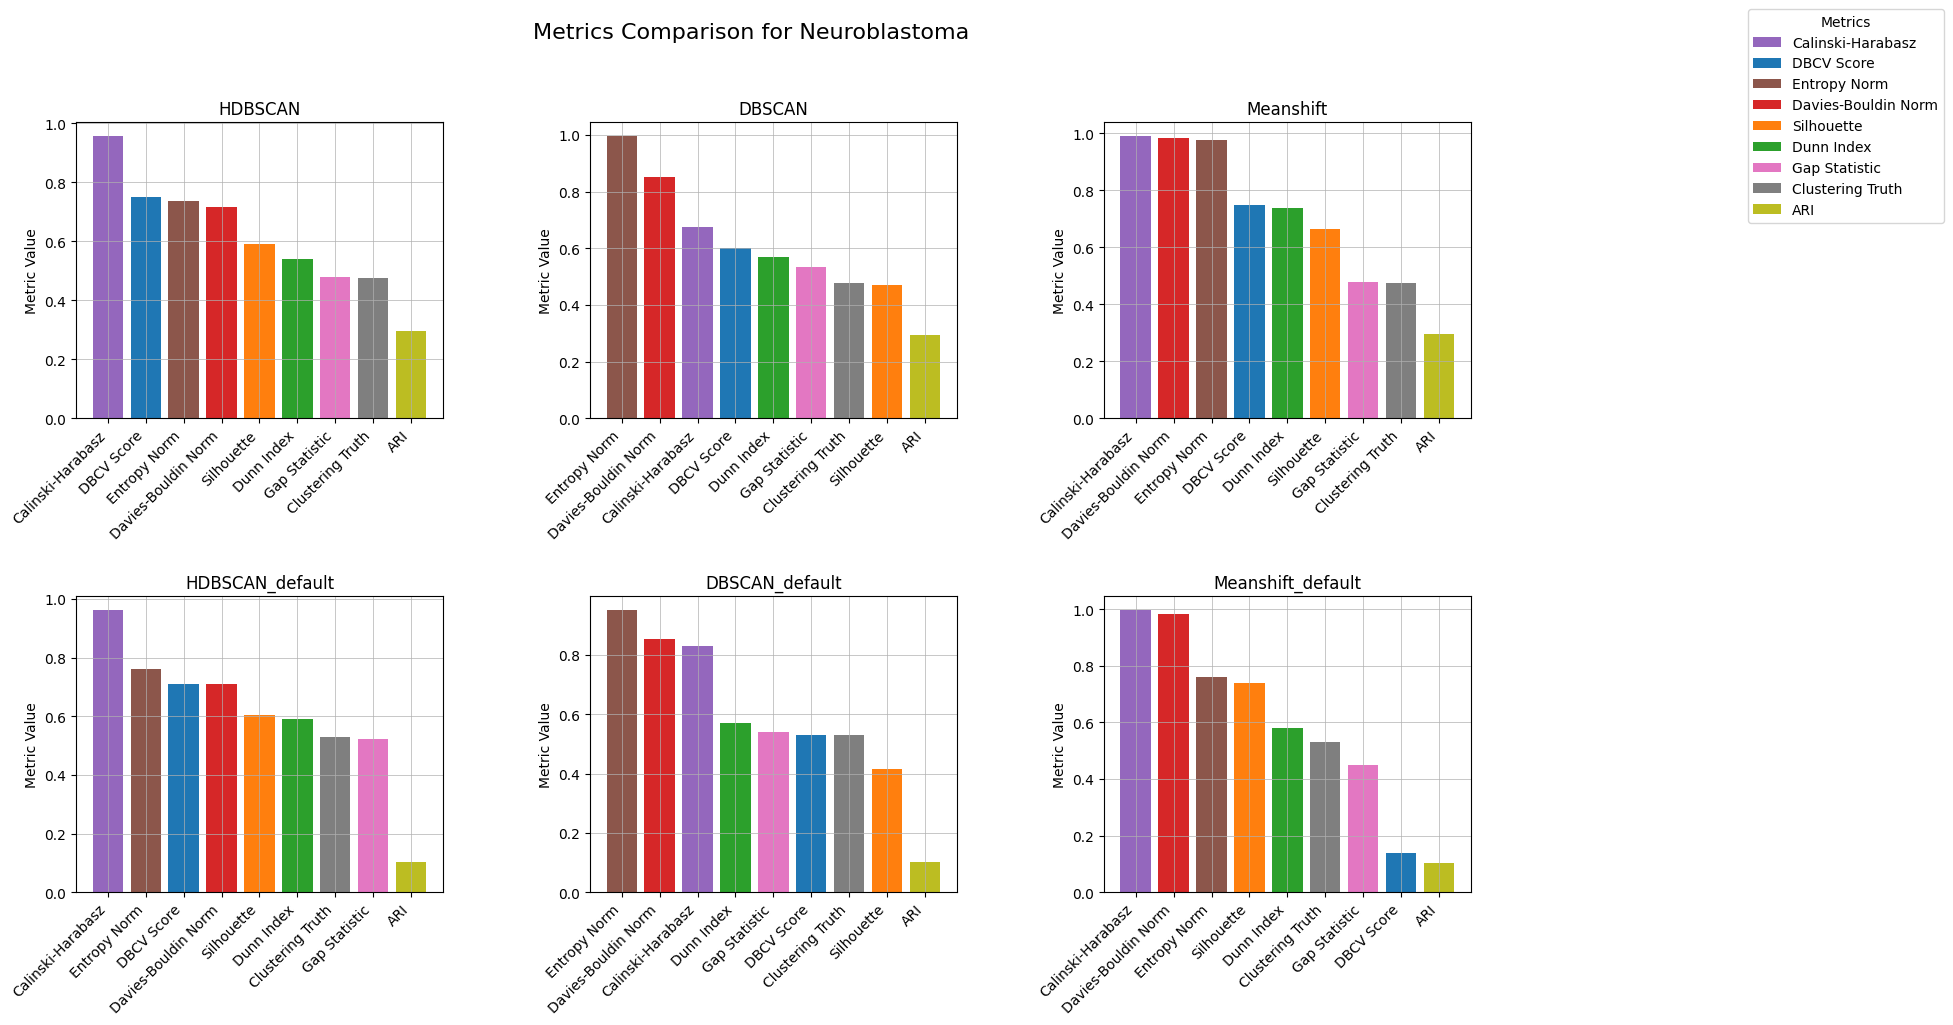

In [ ]:
df_metrics_neuroblastoma.set_index("Method", inplace=True)

metric_colors = {col: plt.cm.tab10(i) for i, col in enumerate(df_metrics_neuroblastoma.columns)}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, method in zip(axes, clustering_methods):
    sorted_metrics = df_metrics_neuroblastoma.loc[method].sort_values(ascending=False)
    for i, metric in enumerate(sorted_metrics.index):
        ax.bar(i, sorted_metrics[metric], color=metric_colors[metric], label=metric)
    ax.set_title(method)
    ##ax.set_xlabel('Metric')
    ax.set_ylabel('Metric Value')
    ax.set_xticks(range(len(sorted_metrics)))
    ax.set_xticklabels(sorted_metrics.index, rotation=45, ha='right')
    ax.grid(True, linewidth=0.5)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.suptitle('Metrics Comparison for Neuroblastoma', fontsize=16)

plt.show()


#**Diabetes**

In [ ]:
diabetes = diabetes.dropna(thresh=neuroblastoma.shape[1] - 2)
numerical_features = diabetes.columns
scaler_minmax = MinMaxScaler()
diabetes_scaled = diabetes.copy()
diabetes_scaled[numerical_features] = scaler_minmax.fit_transform(diabetes[numerical_features])
diabetes_scaled.reset_index(drop=True, inplace=True)
diabetes_scaled.drop_duplicates(inplace=True)
df_metrics_diabetes = pd.DataFrame()
diabetes_scaled

age  duration.of.diabetes  body_mass_index       TDD     basal  \
0   0.370370              0.233333           0.1875  0.421053  0.209302   
1   0.370370              0.500000           0.4375  0.726316  0.531561   
2   0.407407              0.533333           0.1250  0.175940  0.348837   
3   0.148148              0.233333           0.1250  0.666165  0.468439   
4   0.666667              0.833333           0.8750  0.681203  0.707641   
..       ...                   ...              ...       ...       ...   
62  0.555556              0.600000           0.0000  0.470677  1.000000   
63  0.962963              0.800000           0.3750  0.184962  0.232558   
64  0.000000              0.166667           0.4375  0.846617  0.860465   
65  0.555556              0.633333           0.3125  0.275188  0.531561   
66  0.592593              0.533333           0.2500  0.293233  0.548173   

       bolus     HbA1c      eGFR  perc.body.fat  adiponectin  \
0   0.529101  0.214286  0.422018       0.971429     0.375000   
1   0.716049  0.482143  0.546527       0.980952     0.225694   
2   0.167549  0.125000  0.448231       0.971429     0.437500   
3   0.679012  0.375000  0.550459       0.971429     0.107639   
4   0.567901  0.446429  0.758847       0.990476     0.357639   
..       ...       ...       ...            ...          ...   
62  0.167549  0.732143  0.000000       0.971429     0.381944   
63  0.239859  0.321429  0.342071       0.980952     0.288194   
64  0.682540  0.500000  0.832241       0.971429     0.343750   
65  0.186949  0.303571  0.563565       0.971429     0.253472   
66  0.199295  0.089286  0.568807       0.971429     0.579861   

    free.testosterone       SMI  grip.strength  knee.extension.strength  \
0            0.022599  0.388889       0.358090                 0.312500   
1            0.531073  0.555556       0.607427                 0.542763   
2            0.039548  0.166667       0.042440                 0.312500   
3            0.050847  0.277778       0.381963                 0.299342   
4            0.542373  0.777778       0.671088                 0.500000   
..                ...       ...            ...                      ...   
62           0.016949  0.111111       0.209549                 0.542763   
63           0.276836  0.500000       0.233422                 0.154605   
64           0.954802  0.694444       0.612732                 0.572368   
65           0.429379  0.694444       1.000000                 0.674342   
66           0.220339  0.444444       0.026525                 0.161184   

    gait.speed      ucOC        OC  weight_kg  insulin_regimen_binary  \
0     0.000000  1.000000  1.000000   0.139482                     0.0   
1     0.583333  0.188172  0.254630   0.603659                     1.0   
2     0.333333  0.080645  0.101852   0.142683                     0.0   
3     0.500000  0.161290  0.187500   0.054878                     1.0   
4     0.416667  0.107527  0.134259   1.000000                     0.0   
..         ...       ...       ...        ...                     ...   
62    0.750000  0.838710  0.879630   0.000000                     1.0   
63    0.583333  0.086022  0.150463   0.164634                     1.0   
64    0.583333  0.424731  0.479167   0.457317                     1.0   
65    0.750000  0.231183  0.245370   0.384146                     1.0   
66    0.500000  0.000000  0.016204   0.213415                     0.0   

    sex_0man_1woman  
0               1.0  
1               0.0  
2               1.0  
3               1.0  
4               0.0  
..              ...  
62              1.0  
63              0.0  
64              0.0  
65              0.0  
66              1.0  

[67 rows x 20 columns]

**HDBSCAN**

In [ ]:
min_size, epsilon= best_params_hdbscan(diabetes_scaled)

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default= hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(diabetes_scaled)
labels_default = hdbscan_cluster_default.fit_predict(diabetes_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(diabetes_scaled, labels)
diabetes_scaled['HDBSCAN_pred'] = labels

methods = 'HDBSCAN'
methods_default = 'HDBSCAN_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(diabetes_scaled.iloc[:, :-1], labels_default)
diabetes_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df], ignore_index=True)
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df_default], ignore_index=True)


min_cluster_size: 6, cluster_selection_epsilon: 0.0


**DBSCAN**

In [ ]:
min_sample, eps = best_params_dbscan(diabetes_scaled)

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(diabetes_scaled)
labels_default = dbscan_default.fit_predict(diabetes_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(diabetes_scaled, labels)
diabetes_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN_default'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(diabetes_scaled.iloc[:, :-1], labels_default)
diabetes_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df], ignore_index=True)
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df_default], ignore_index=True)

min_cluster_size: 3, cluster_selection_epsilon: 0.5


**Mean_Shift**

In [ ]:
band = best_params_mean_shift(diabetes_scaled)

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(diabetes_scaled)
labels_default = mean_shift_default.fit_predict(diabetes_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(diabetes_scaled, labels)
diabetes_scaled['Mean_shift_pred'] = labels

methods = 'Meanshift'
methods_default = 'Meanshift_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(diabetes_scaled.iloc[:, :-1], labels_default)
diabetes_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df], ignore_index=True)
df_metrics_diabetes = pd.concat([df_metrics_diabetes, metrics_df_default], ignore_index=True)

Best_score: 0.1759520754823194, Finale_score: 0.6615363389234697, best_bandwith: 0.6222856140439514


**Cluster Analysis**

In [ ]:
cluster_similarity = similar_cluster(diabetes_scaled)
cluster_similarity

[6 2 1 0 3 4 5]
[-1  0]
[-1  0  2  1]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
27           0      -1        1    32.835821
18           1      -1        2    23.880597
9            2      -1        0    22.388060
22           1       0        2     8.955224
32           3      -1       -1     7.462687
0            6      -1       -1     1.492537
48           5      -1       -1     1.492537
40           4      -1       -1     1.492537
41           4      -1        0     0.000000
33           3      -1        0     0.000000
34           3      -1        2     0.000000
35           3      -1        1     0.000000
36           3       0       -1     0.000000
37           3       0        0     0.000000
38           3       0        2     0.000000
39           3       0        1     0.000000
42           4      -1        2     0.000000
30           0       0        2     0.000000
43           4      -1        1     0.000000
44           4       0       -1     0.000000
45           4       0        0     0.000000
46           4       0        2     0.000000
47           4       0        1     0.000000
49           5      -1        0     0.000000
50           5      -1        2     0.000000
51           5      -1        1     0.000000
52           5       0       -1     0.000000
53           5       0        0     0.000000
54           5       0        2     0.000000
31           0       0        1     0.000000
28           0       0       -1     0.000000
29           0       0        0     0.000000
13           2       0        0     0.000000
2            6      -1        2     0.000000
3            6      -1        1     0.000000
4            6       0       -1     0.000000
5            6       0        0     0.000000
6            6       0        2     0.000000
7            6       0        1     0.000000
8            2      -1       -1     0.000000
10           2      -1        2     0.000000
11           2      -1        1     0.000000
12           2       0       -1     0.000000
14           2       0        2     0.000000
1            6      -1        0     0.000000
15           2       0        1     0.000000
16           1      -1       -1     0.000000
17           1      -1        0     0.000000
19           1      -1        1     0.000000
20           1       0       -1     0.000000
21           1       0        0     0.000000
23           1       0        1     0.000000
24           0      -1       -1     0.000000
25           0      -1        0     0.000000
26           0      -1        2     0.000000
55           5       0        1     0.000000

In [ ]:
cluster_similarity_default = similar_cluster_default(diabetes_scaled)
cluster_similarity_default

[6 2 1 0 3 4 5]
[-1]
[-1  0  2  1]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
15           0      -1        1    32.835821
10           1      -1        2    32.835821
5            2      -1        0    22.388060
16           3      -1       -1     7.462687
0            6      -1       -1     1.492537
24           5      -1       -1     1.492537
23           4      -1        1     1.492537
26           5      -1        2     0.000000
25           5      -1        0     0.000000
22           4      -1        2     0.000000
21           4      -1        0     0.000000
20           4      -1       -1     0.000000
19           3      -1        1     0.000000
18           3      -1        2     0.000000
17           3      -1        0     0.000000
14           0      -1        2     0.000000
1            6      -1        0     0.000000
13           0      -1        0     0.000000
12           0      -1       -1     0.000000
11           1      -1        1     0.000000
9            1      -1        0     0.000000
8            1      -1       -1     0.000000
7            2      -1        1     0.000000
6            2      -1        2     0.000000
4            2      -1       -1     0.000000
3            6      -1        1     0.000000
2            6      -1        2     0.000000
27           5      -1        1     0.000000

In [ ]:
diabetes_scaled["DBSCAN_pred"] = diabetes_scaled["DBSCAN_pred"].astype(object)
diabetes_scaled["HDBSCAN_pred"] = diabetes_scaled["HDBSCAN_pred"].astype(object)
diabetes_scaled["Mean_shift_pred"] = diabetes_scaled["Mean_shift_pred"].astype(object)

diabetes_scaled.loc[diabetes_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'A'
diabetes_scaled.loc[diabetes_scaled["HDBSCAN_pred"] == 1, "HDBSCAN_pred"] = 'A'
diabetes_scaled.loc[diabetes_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'A'

diabetes_scaled.loc[diabetes_scaled["DBSCAN_pred"] == 0, "DBSCAN_pred"] = 'B'
diabetes_scaled.loc[diabetes_scaled["HDBSCAN_pred"] == 2, "HDBSCAN_pred"] = 'B'
diabetes_scaled.loc[diabetes_scaled["Mean_shift_pred"] == 1, "Mean_shift_pred"] = 'B'

diabetes_scaled.loc[diabetes_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'A'
diabetes_scaled.loc[diabetes_scaled["HDBSCAN_default_pred"] == 1, "HDBSCAN_default_pred"] = 'A'
diabetes_scaled.loc[diabetes_scaled["Mean_shift_default_pred"] == 0, "Mean_shift_default_pred"] = 'A'

diabetes_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    diabetes_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1})
    .astype(int)
)

diabetes_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]] = (
    diabetes_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]]
    .replace({'A': 0})
    .astype(int)
)

same_value_count = (diabetes_scaled["HDBSCAN_pred"] == diabetes_scaled["DBSCAN_pred"]) & \
                   (diabetes_scaled["DBSCAN_pred"] == diabetes_scaled["Mean_shift_pred"])

same_value_count_default = (diabetes_scaled["HDBSCAN_default_pred"] == diabetes_scaled["DBSCAN_default_pred"]) & \
                   (diabetes_scaled["DBSCAN_default_pred"] == diabetes_scaled["Mean_shift_default_pred"])

total_same_value = same_value_count.sum()
total_same_value_default = same_value_count_default.sum()
total_rows = len(diabetes_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(diabetes_scaled)

percentage_same_value_default = (total_same_value_default / total_rows) * 100
print("Totale delle righe con lo stesso valore con parametri default:", total_same_value_default)
print("Percentuale rispetto al totale:", round(percentage_same_value_default,2), "%")
percentage_same_value_default = round((percentage_same_value_default / 100),3)
ari_default = compute_ari_default(diabetes_scaled)

df_metrics_diabetes['Clustering Truth'] = df_metrics_diabetes['Method'].apply(
    lambda x: percentage_same_value_default if 'default' in x else percentage_same_value)

df_metrics_diabetes['ARI'] = df_metrics_diabetes['Method'].apply(
    lambda x: ari_default if 'default' in x else ari)

df_metrics_diabetes = df_metrics_diabetes.sort_values('DBCV Score', ascending=False)


Totale delle righe con lo stesso valore: 28
Percentuale rispetto al totale: 41.79 %
Totale delle righe con lo stesso valore con parametri default: 22
Percentuale rispetto al totale: 32.84 %


**No Normalizzazione**

In [ ]:
df_metrics_diabetes

Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
4          Meanshift        0.66        0.45    0.750735                 1.30   
5  Meanshift_default        0.66        0.45    0.750735                 1.30   
0            HDBSCAN        0.51        0.26    0.288354                 0.51   
1    HDBSCAN_default        0.47        0.27    0.288354                 0.51   
2             DBSCAN        0.09        0.03    0.106701                 0.95   
3     DBSCAN_default        0.00       -1.00   -1.000000                -1.00   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
4              47.32          0.72           1.37             0.418  0.250796  
5              47.32          0.72           1.38             0.328  0.211424  
0              20.11          0.10           1.23             0.418  0.250796  
1              20.21          0.12           1.25             0.328  0.211424  
2               7.05          0.57           1.32             0.418  0.250796  
3              -1.00         -1.00           1.34             0.328  0.211424

In [ ]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score", "Silhouette", "Dunn Index",
    "Davies-Bouldin Norm", "Calinski-Harabasz",
    "Entropy Norm", "Gap Statistic"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in df_metrics_diabetes.columns:
            best_value = df_metrics_diabetes.loc[df_metrics_diabetes["Method"] == method, metric_value].values[0]
            default_value = df_metrics_diabetes.loc[df_metrics_diabetes["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(df_metrics_diabetes,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": round(best_value,3),
                "Default": round(default_value,3),
                "Method": method,
                "trend": trend,
                "Trend consistency with ARI": consistency
            })

final_table = pd.DataFrame(results)
print("Tab.5 Trend Conisentecy With ARI :\n")
final_table

Tab.5 Trend Conisentecy With ARI :



Metric  Best_parameters  Default     Method trend  \
0                DBCV            0.090    0.000     DBSCAN     ↓   
1          Silhouette            0.030   -1.000     DBSCAN     ↓   
2                Dunn            0.107   -1.000     DBSCAN     ↓   
3      Davies-Bouldin            0.950   -1.000     DBSCAN     ↓   
4   Calinski-Harabasz            7.050   -1.000     DBSCAN     ↓   
5             Entropy            0.570   -1.000     DBSCAN     ↓   
6                 Gap            1.320    1.340     DBSCAN     ↑   
7                DBCV            0.510    0.470    HDBSCAN     ↓   
8          Silhouette            0.260    0.270    HDBSCAN     ↑   
9                Dunn            0.288    0.288    HDBSCAN     ↓   
10     Davies-Bouldin            0.510    0.510    HDBSCAN     ↓   
11  Calinski-Harabasz           20.110   20.210    HDBSCAN     ↑   
12            Entropy            0.100    0.120    HDBSCAN     ↑   
13                Gap            1.230    1.250    HDBSCAN     ↑   
14               DBCV            0.660    0.660  Meanshift     ↓   
15         Silhouette            0.450    0.450  Meanshift     ↓   
16               Dunn            0.751    0.751  Meanshift     ↓   
17     Davies-Bouldin            1.300    1.300  Meanshift     ↓   
18  Calinski-Harabasz           47.320   47.320  Meanshift     ↓   
19            Entropy            0.720    0.720  Meanshift     ↓   
20                Gap            1.370    1.380  Meanshift     ↑   

   Trend consistency with ARI  
0                  Consistent  
1                  Consistent  
2                  Consistent  
3                  Consistent  
4                  Consistent  
5                  Consistent  
6                Inconsistent  
7                  Consistent  
8                Inconsistent  
9                  Consistent  
10                 Consistent  
11               Inconsistent  
12               Inconsistent  
13               Inconsistent  
14                 Consistent  
15                 Consistent  
16                 Consistent  
17                 Consistent  
18                 Consistent  
19                 Consistent  
20               Inconsistent

In [ ]:
consistency_table = final_table.groupby("Metric")["Trend consistency with ARI"].value_counts().unstack(fill_value=0)
consistency_table = consistency_table.rename(columns={"Consistent": "N°Consistent", "Inconsistent": "N°Inconsistent"}).reset_index()
consistency_table = consistency_table.sort_values(by="N°Consistent", ascending=False).reset_index(drop=True)
consistency_table = consistency_table.to_string(index=False)
print(consistency_table)

           Metric  N°Consistent  N°Inconsistent
             DBCV             3               0
   Davies-Bouldin             3               0
             Dunn             3               0
Calinski-Harabasz             2               1
          Entropy             2               1
       Silhouette             2               1
              Gap             0               3


**Normalizzazione**

In [ ]:
df_metrics_diabetes["Silhouette"] = (df_metrics_diabetes["Silhouette"] + 1) / 2
df_metrics_diabetes["DBCV Score"] = (df_metrics_diabetes["DBCV Score"] + 1) / 2
df_metrics_diabetes["Dunn Index"] = (erf(df_metrics_diabetes["Dunn Index"]) + 1) / 2
df_metrics_diabetes["Davies-Bouldin Norm"] = (erf(df_metrics_diabetes["Davies-Bouldin Norm"]) + 1) / 2
df_metrics_diabetes["Calinski-Harabasz"] = 1 - (1 / df_metrics_diabetes["Calinski-Harabasz"])
df_metrics_diabetes["Entropy Norm"] = (erf(df_metrics_diabetes["Entropy Norm"]) + 1) / 2
df_metrics_diabetes["Gap Statistic"] = (erf(df_metrics_diabetes["Gap Statistic"]) + 1) / 2

df_metrics_diabetes

Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
4          Meanshift       0.830       0.725    0.855814             0.967004   
5  Meanshift_default       0.830       0.725    0.855814             0.967004   
0            HDBSCAN       0.755       0.630    0.658288             0.764622   
1    HDBSCAN_default       0.735       0.635    0.658288             0.764622   
2             DBSCAN       0.545       0.515    0.559972             0.910445   
3     DBSCAN_default       0.500       0.000    0.078650             0.078650   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
4           0.978867      0.845717       0.973656             0.418  0.250796  
5           0.978867      0.845717       0.974508             0.328  0.211424  
0           0.950273      0.556231       0.959025             0.418  0.250796  
1           0.950520      0.567379       0.961450             0.328  0.211424  
2           0.858156      0.789908       0.969033             0.418  0.250796  
3           2.000000      0.078650       0.970957             0.328  0.211424

In [ ]:
distance_table_diabetes = df_metrics_diabetes.copy()

for metric in metrics:
    distance_table_diabetes[metric] = np.sqrt((df_metrics_diabetes[metric] - df_metrics_diabetes["Clustering Truth"]) ** 2)

distance_table_diabetes = distance_table_diabetes.sort_values(by="DBCV Score", ascending=True)
distance_table_diabetes.columns = [
    f"{col} Distance" if col in metrics else col for col in distance_table_diabetes.columns
]
distance_table_diabetes

Method  DBCV Score Distance  Silhouette Distance  \
2             DBSCAN                0.127                0.097   
3     DBSCAN_default                0.172                0.328   
0            HDBSCAN                0.337                0.212   
1    HDBSCAN_default                0.407                0.307   
4          Meanshift                0.412                0.307   
5  Meanshift_default                0.502                0.397   

   Dunn Index Distance  Davies-Bouldin Norm Distance  \
2             0.141972                      0.492445   
3             0.249350                      0.249350   
0             0.240288                      0.346622   
1             0.330288                      0.436622   
4             0.437814                      0.549004   
5             0.527814                      0.639004   

   Calinski-Harabasz Distance  Entropy Norm Distance  Gap Statistic Distance  \
2                    0.440156               0.371908                0.551033   
3                    1.672000               0.249350                0.642957   
0                    0.532273               0.138231                0.541025   
1                    0.622520               0.239379                0.633450   
4                    0.560867               0.427717                0.555656   
5                    0.650867               0.517717                0.646508   

   Clustering Truth       ARI  
2             0.418  0.250796  
3             0.328  0.211424  
0             0.418  0.250796  
1             0.328  0.211424  
4             0.418  0.250796  
5             0.328  0.211424

In [ ]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score Distance", "Silhouette Distance", "Dunn Index Distance",
    "Davies-Bouldin Norm Distance", "Calinski-Harabasz Distance",
    "Entropy Norm Distance", "Gap Statistic Distance"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in distance_table_diabetes.columns:
            best_value = distance_table_diabetes.loc[distance_table_diabetes["Method"] == method, metric_value].values[0]
            default_value = distance_table_diabetes.loc[distance_table_diabetes["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(distance_table_diabetes,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": best_value,
                "Default": default_value,
                "Method": method,
                "trend": trend,
                "Trend consistency with ARI": consistency
            })

final_table = pd.DataFrame(results)
print("Tab.6 Trend Conisentecy With ARI :\n")
final_table

Tab.6 Trend Conisentecy With ARI :



Metric  Best_parameters   Default     Method trend  \
0                DBCV         0.127000  0.172000     DBSCAN     ↑   
1          Silhouette         0.097000  0.328000     DBSCAN     ↑   
2                Dunn         0.141972  0.249350     DBSCAN     ↑   
3      Davies-Bouldin         0.492445  0.249350     DBSCAN     ↓   
4   Calinski-Harabasz         0.440156  1.672000     DBSCAN     ↑   
5             Entropy         0.371908  0.249350     DBSCAN     ↓   
6                 Gap         0.551033  0.642957     DBSCAN     ↑   
7                DBCV         0.337000  0.407000    HDBSCAN     ↑   
8          Silhouette         0.212000  0.307000    HDBSCAN     ↑   
9                Dunn         0.240288  0.330288    HDBSCAN     ↑   
10     Davies-Bouldin         0.346622  0.436622    HDBSCAN     ↑   
11  Calinski-Harabasz         0.532273  0.622520    HDBSCAN     ↑   
12            Entropy         0.138231  0.239379    HDBSCAN     ↑   
13                Gap         0.541025  0.633450    HDBSCAN     ↑   
14               DBCV         0.412000  0.502000  Meanshift     ↑   
15         Silhouette         0.307000  0.397000  Meanshift     ↑   
16               Dunn         0.437814  0.527814  Meanshift     ↑   
17     Davies-Bouldin         0.549004  0.639004  Meanshift     ↑   
18  Calinski-Harabasz         0.560867  0.650867  Meanshift     ↑   
19            Entropy         0.427717  0.517717  Meanshift     ↑   
20                Gap         0.555656  0.646508  Meanshift     ↑   

   Trend consistency with ARI  
0                Inconsistent  
1                Inconsistent  
2                Inconsistent  
3                  Consistent  
4                Inconsistent  
5                  Consistent  
6                Inconsistent  
7                Inconsistent  
8                Inconsistent  
9                Inconsistent  
10               Inconsistent  
11               Inconsistent  
12               Inconsistent  
13               Inconsistent  
14               Inconsistent  
15               Inconsistent  
16               Inconsistent  
17               Inconsistent  
18               Inconsistent  
19               Inconsistent  
20               Inconsistent

In [ ]:
consistency_table = final_table.groupby("Metric")["Trend consistency with ARI"].value_counts().unstack(fill_value=0)
consistency_table = consistency_table.rename(columns={"Consistent": "N°Consistent", "Inconsistent": "N°Inconsistent"}).reset_index()
consistency_table = consistency_table.sort_values(by="N°Consistent", ascending=False).reset_index(drop=True)
consistency_table = consistency_table.to_string(index=False)
print(consistency_table)

           Metric  N°Consistent  N°Inconsistent
   Davies-Bouldin             1               2
          Entropy             1               2
Calinski-Harabasz             0               3
             DBCV             0               3
             Dunn             0               3
              Gap             0               3
       Silhouette             0               3


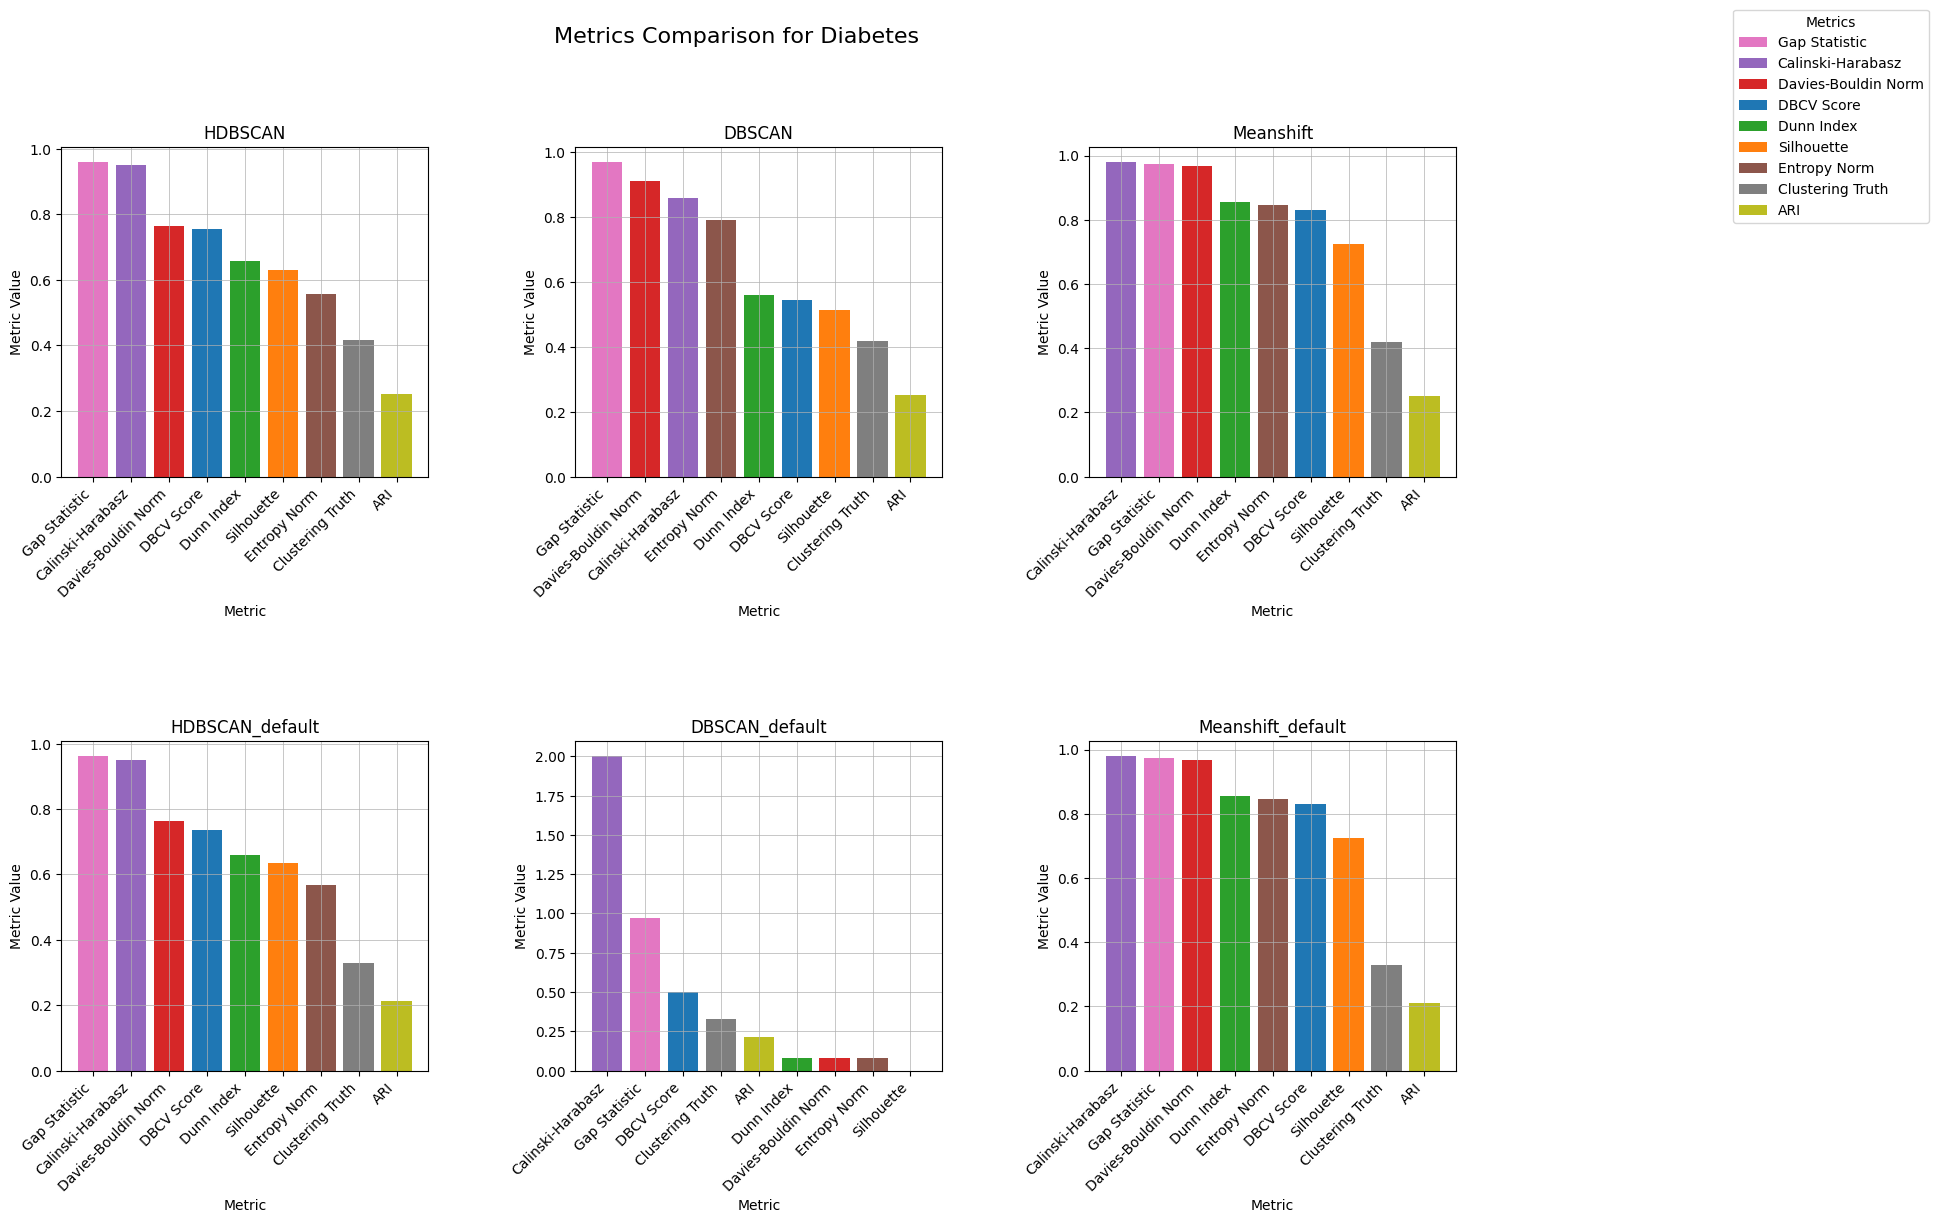

In [ ]:
df_metrics_diabetes.set_index("Method", inplace=True)

methods = df_metrics_diabetes.index.unique()
metric_colors = {col: plt.cm.tab10(i) for i, col in enumerate(df_metrics_diabetes.columns)}
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for ax, method in zip(axes, clustering_methods):
    sorted_metrics = df_metrics_diabetes.loc[method].sort_values(ascending=False)
    for i, metric in enumerate(sorted_metrics.index):
        ax.bar(i, sorted_metrics[metric], color=metric_colors[metric], label=metric)
    ax.set_title(method)
    ax.set_xlabel('Metric')
    ax.set_ylabel('Metric Value')
    ax.set_xticks(range(len(sorted_metrics)))
    ax.set_xticklabels(sorted_metrics.index, rotation=45, ha='right')
    ax.grid(True, linewidth=0.5)

plt.subplots_adjust(wspace=0.4, hspace=0.8)
plt.suptitle('Metrics Comparison for Diabetes', fontsize=16)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


#**Sepsis**

In [ ]:
sepsis = sepsis.dropna(thresh=neuroblastoma.shape[1] - 2)
numerical_features = sepsis.columns
scaler_minmax = MinMaxScaler()
sepsis_scaled = sepsis.copy()
sepsis_scaled[numerical_features] = scaler_minmax.fit_transform(sepsis_scaled[numerical_features])
sepsis_scaled.reset_index(drop=True, inplace=True)
sepsis_scaled.drop_duplicates(inplace=True)
df_metrics_sepsis = pd.DataFrame()
sepsis_scaled

Age  sex_woman  diagnosis_0EC_1M_2_AC  APACHE II    SOFA       CRP  \
0     0.061728        0.0                    1.0   0.291667  0.0000  0.000384   
1     0.432099        0.0                    1.0   0.208333  0.1875  0.172911   
2     0.802469        0.0                    1.0   0.166667  0.2500  0.228818   
3     0.209877        0.0                    1.0   0.062500  0.0000  0.141787   
4     0.839506        0.0                    1.0   0.354167  0.1250  0.095485   
...        ...        ...                    ...        ...     ...       ...   
1252  0.814815        1.0                    0.5   0.375000  0.1875  0.005764   
1253  0.148148        1.0                    0.5   0.062500  0.0000  0.001921   
1254  0.543210        1.0                    0.5   0.395833  0.3750  0.086455   
1255  0.160494        1.0                    0.5   0.333333  0.3125  0.038425   
1256  0.395062        0.0                    0.5   0.104167  0.0625  0.125456   

          WBCC      NeuC      LymC       EOC      NLCR      PLTC       MPV  \
0     0.195721  0.168191  0.174444  0.097561  0.015703  0.195730  0.093458   
1     0.367670  0.319682  0.088299  0.000000  0.061385  0.319098  0.100935   
2     0.237718  0.193042  0.102656  0.000000  0.031644  0.103203  0.085981   
3     0.140650  0.114712  0.134243  0.048780  0.014038  0.288256  0.073832   
4     0.198891  0.189463  0.111271  0.000000  0.028551  0.144721  0.110280   
...        ...       ...       ...       ...       ...       ...       ...   
1252  0.121038  0.100596  0.115578  0.073171  0.014276  0.158956  0.090654   
1253  0.144414  0.064215  0.497487  0.073171  0.001190  0.304864  0.096262   
1254  0.077060  0.066203  0.043790  0.048780  0.025934  0.209964  0.080374   
1255  0.154517  0.129026  0.108399  0.048780  0.019748  0.181495  0.084112   
1256  0.217512  0.192247  0.128500  0.000000  0.024982  0.213523  0.089720   

      Group   LOS-ICU  Mortality  
0       0.0  0.000000        0.0  
1       0.0  0.000000        0.0  
2       0.0  0.000000        0.0  
3       0.0  0.000000        0.0  
4       0.0  0.000000        0.0  
...     ...       ...        ...  
1252    0.0  0.052632        0.0  
1253    0.0  0.000000        0.0  
1254    0.0  0.147368        0.0  
1255    1.0  0.031579        0.0  
1256    0.0  0.000000        0.0  

[1257 rows x 16 columns]

**HDBSCAN**

In [ ]:
min_size, epsilon= best_params_hdbscan(sepsis_scaled)

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default= hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(sepsis_scaled)
labels_default = hdbscan_cluster_default.fit_predict(sepsis_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(sepsis_scaled, labels)
sepsis_scaled['HDBSCAN_pred'] = labels

methods = 'HDBSCAN'
methods_default = 'HDBSCAN_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(sepsis_scaled.iloc[:, :-1], labels_default)
sepsis_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df], ignore_index=True)
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df_default], ignore_index=True)


min_cluster_size: 6, cluster_selection_epsilon: 0.0


**DBSCAN**

In [ ]:
min_sample, eps = best_params_dbscan(sepsis_scaled)

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(sepsis_scaled)
labels_default = dbscan_default.fit_predict(sepsis_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(sepsis_scaled, labels)
sepsis_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(sepsis_scaled.iloc[:, :-1], labels_default)
sepsis_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df], ignore_index=True)
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df_default], ignore_index=True)

min_cluster_size: 3, cluster_selection_epsilon: 0.5


**Mean_Shift**

In [ ]:
band = best_params_mean_shift(sepsis_scaled)

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(sepsis_scaled)
labels_default = mean_shift_default.fit_predict(sepsis_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(sepsis_scaled, labels)
sepsis_scaled['Mean_shift_pred'] = labels

methods = 'Meanshift'
methods_default = 'Meanshift_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(sepsis_scaled.iloc[:, :-1], labels_default)
sepsis_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df], ignore_index=True)
df_metrics_sepsis = pd.concat([df_metrics_sepsis, metrics_df_default], ignore_index=True)
df_metrics_sepsis

Best bandwidth: 3.032


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0            HDBSCAN        0.40        0.31    0.096830                 0.64   
1    HDBSCAN_default        0.36        0.30    0.096830                 0.65   
2             DBSCAN        0.82        0.58    0.039535                 0.92   
3     DBSCAN_default        0.81        0.58    0.018624                 0.96   
4          Meanshift        0.90        0.85    0.377478                 3.84   
5  Meanshift_default       -0.36        0.60    0.275379                 1.79   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  
0             286.31          0.59           1.84  
1             266.77          0.61           1.83  
2            1762.81          0.80           1.67  
3            2049.32          0.57           1.64  
4            9417.62          1.00           1.28  
5            1012.16          0.89           1.30

**Cluster Analysis**

In [ ]:
cluster_similarity = similar_cluster(sepsis_scaled)
cluster_similarity

[14 12  6 13 17 11  0  9  1 10  3  2  7 20 16 18  4  8 15  5 19]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 14 13 15]
[-1  5  2  6  4  0 10 11  8  3  9 12  1  7]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
1490           0       3       10    25.934765
1996           1       5        8    16.070008
2755           2       8       12    11.296738
2502           3       7        9     8.353222
4003           4      12        7     7.398568
...          ...     ...      ...          ...
1671           9      -1        0     0.000000
1670           9      -1        4     0.000000
1669           9      -1        6     0.000000
1668           9      -1        2     0.000000
4997          19      15        7     0.000000

[4998 rows x 4 columns]

In [ ]:
cluster_similarity_default = similar_cluster_default(sepsis_scaled)
cluster_similarity_default

[2 0 3 4 1]
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12]
[ 4 -1  2  7  0  6 10  9 12  5 11  1  8  3 13]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
260            0       2        6    25.934765
292            0       4        9    16.070008
340            0       7       11    11.296738
324            0       6        5     8.353222
1017           1      10        8     7.398568
...          ...     ...      ...          ...
369            0       9        5     0.000000
370            0       9       11     0.000000
371            0       9        1     0.000000
372            0       9        8     0.000000
525            3       6        4     0.000000

[1050 rows x 4 columns]

In [ ]:
sepsis_scaled["DBSCAN_pred"] = sepsis_scaled["DBSCAN_pred"].astype(object)
sepsis_scaled["HDBSCAN_pred"] = sepsis_scaled["HDBSCAN_pred"].astype(object)
sepsis_scaled["Mean_shift_pred"] = sepsis_scaled["Mean_shift_pred"].astype(object)

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 3, "DBSCAN_pred"] = 'A'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 10, "HDBSCAN_pred"] = 'A'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'A'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 5, "DBSCAN_pred"] = 'B'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 8, "HDBSCAN_pred"] = 'B'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 1, "Mean_shift_pred"] = 'B'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 8, "DBSCAN_pred"] = 'C'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 12, "HDBSCAN_pred"] = 'C'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 2, "Mean_shift_pred"] = 'C'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 7, "DBSCAN_pred"] = 'D'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 9, "HDBSCAN_pred"] = 'D'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 3, "Mean_shift_pred"] = 'D'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 12, "DBSCAN_pred"] = 'E'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 7, "HDBSCAN_pred"] = 'E'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 4, "Mean_shift_pred"] = 'E'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 15, "DBSCAN_pred"] = 'F'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 4, "HDBSCAN_pred"] = 'F'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 5, "Mean_shift_pred"] = 'F'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'G'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == -1, "HDBSCAN_pred"] = 'G'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 6, "Mean_shift_pred"] = 'G'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 10, "DBSCAN_pred"] = 'H'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 1, "HDBSCAN_pred"] = 'H'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 7, "Mean_shift_pred"] = 'H'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 14, "DBSCAN_pred"] = 'I'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 0, "HDBSCAN_pred"] = 'I'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 8, "Mean_shift_pred"] = 'I'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 6, "DBSCAN_pred"] = 'J'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 4, "HDBSCAN_pred"] = 'J'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 10, "Mean_shift_pred"] = 'J'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 0, "DBSCAN_pred"] = 'K'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 5, "HDBSCAN_pred"] = 'K'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 12, "Mean_shift_pred"] = 'K'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_pred"] == 4, "DBSCAN_pred"] = 'L'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_pred"] == 11, "HDBSCAN_pred"] = 'L'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_pred"] == 9, "Mean_shift_pred"] = 'L'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_default_pred"] == 2, "DBSCAN_default_pred"] = 'A'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_default_pred"] == 6, "HDBSCAN_default_pred"] = 'A'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_default_pred"] == 0, "Mean_shift_default_pred"] = 'A'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_default_pred"] == 10, "DBSCAN_default_pred"] = 'B'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_default_pred"] == 8, "HDBSCAN_default_pred"] = 'B'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_default_pred"] == 1, "Mean_shift_default_pred"] = 'B'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'C'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_default_pred"] == -1, "HDBSCAN_default_pred"] = 'C'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_default_pred"] == 2, "Mean_shift_default_pred"] = 'C'

sepsis_scaled.loc[sepsis_scaled["DBSCAN_default_pred"] == 9, "DBSCAN_default_pred"] = 'D'
sepsis_scaled.loc[sepsis_scaled["HDBSCAN_default_pred"] == 1, "HDBSCAN_default_pred"] = 'D'
sepsis_scaled.loc[sepsis_scaled["Mean_shift_default_pred"] == 3, "Mean_shift_default_pred"] = 'D'

sepsis_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    sepsis_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1, 'C': 2,'D': 3,'E': 4,'F': 5,'G': 6,'H': 7,'I': 8,
              'J': 9,'K': 10,'L': 11,})
    .astype(int)
)

sepsis_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]] = (
    sepsis_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]]
    .replace({'A': 0, 'B': 1, 'C': 2,'D': 3})
    .astype(int)
)

same_value_count = (sepsis_scaled["HDBSCAN_pred"] == sepsis_scaled["DBSCAN_pred"]) & \
                   (sepsis_scaled["DBSCAN_pred"] == sepsis_scaled["Mean_shift_pred"])

same_value_count_default = (sepsis_scaled["HDBSCAN_default_pred"] == sepsis_scaled["DBSCAN_default_pred"]) & \
                   (sepsis_scaled["DBSCAN_default_pred"] == sepsis_scaled["Mean_shift_default_pred"])

total_same_value = same_value_count.sum()
total_same_value_default = same_value_count_default.sum()
total_rows = len(sepsis_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(sepsis_scaled)

percentage_same_value_default = (total_same_value_default / total_rows) * 100
print("Totale delle righe con lo stesso valore con parametri default:", total_same_value_default)
print("Percentuale rispetto al totale:", round(percentage_same_value_default,2), "%")
percentage_same_value_default = round((percentage_same_value_default / 100),3)
ari_default = compute_ari_default(sepsis_scaled)

df_metrics_sepsis['Clustering Truth'] = df_metrics_sepsis['Method'].apply(
    lambda x: percentage_same_value_default if 'default' in x else percentage_same_value)

df_metrics_sepsis['ARI'] = df_metrics_sepsis['Method'].apply(
    lambda x: ari_default if 'default' in x else ari)

df_metrics_sepsis = df_metrics_sepsis.sort_values('DBCV Score', ascending=False)

Totale delle righe con lo stesso valore: 1138
Percentuale rispetto al totale: 90.53 %
Totale delle righe con lo stesso valore con parametri default: 548
Percentuale rispetto al totale: 43.6 %


**No normalizzazione**

In [ ]:
df_metrics_sepsis

Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
4          Meanshift        0.90        0.85    0.377478                 3.84   
2             DBSCAN        0.82        0.58    0.039535                 0.92   
3     DBSCAN_default        0.81        0.58    0.018624                 0.96   
0            HDBSCAN        0.40        0.31    0.096830                 0.64   
1    HDBSCAN_default        0.36        0.30    0.096830                 0.65   
5  Meanshift_default       -0.36        0.60    0.275379                 1.79   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
4            9417.62          1.00           1.28             0.905  0.934985  
2            1762.81          0.80           1.67             0.905  0.934985  
3            2049.32          0.57           1.64             0.436  0.438418  
0             286.31          0.59           1.84             0.905  0.934985  
1             266.77          0.61           1.83             0.436  0.438418  
5            1012.16          0.89           1.30             0.436  0.438418

In [ ]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score", "Silhouette", "Dunn Index",
    "Davies-Bouldin Norm", "Calinski-Harabasz",
    "Entropy Norm", "Gap Statistic"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in df_metrics_sepsis.columns:
            best_value = df_metrics_sepsis.loc[df_metrics_sepsis["Method"] == method, metric_value].values[0]
            default_value = df_metrics_sepsis.loc[df_metrics_sepsis["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(df_metrics_sepsis,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": round(best_value,3),
                "Default": round(default_value,3),
                "Method": method,
                "trend": trend,
                "Trend consistency with ARI": consistency
            })

final_table = pd.DataFrame(results)
print("Tab.7 Trend Conisentecy With ARI :\n")
final_table

Tab.7 Trend Conisentecy With ARI :



Metric  Best_parameters   Default     Method trend  \
0                DBCV            0.820     0.810     DBSCAN     ↓   
1          Silhouette            0.580     0.580     DBSCAN     ↓   
2                Dunn            0.040     0.019     DBSCAN     ↓   
3      Davies-Bouldin            0.920     0.960     DBSCAN     ↑   
4   Calinski-Harabasz         1762.810  2049.320     DBSCAN     ↑   
5             Entropy            0.800     0.570     DBSCAN     ↓   
6                 Gap            1.670     1.640     DBSCAN     ↓   
7                DBCV            0.400     0.360    HDBSCAN     ↓   
8          Silhouette            0.310     0.300    HDBSCAN     ↓   
9                Dunn            0.097     0.097    HDBSCAN     ↓   
10     Davies-Bouldin            0.640     0.650    HDBSCAN     ↑   
11  Calinski-Harabasz          286.310   266.770    HDBSCAN     ↓   
12            Entropy            0.590     0.610    HDBSCAN     ↑   
13                Gap            1.840     1.830    HDBSCAN     ↓   
14               DBCV            0.900    -0.360  Meanshift     ↓   
15         Silhouette            0.850     0.600  Meanshift     ↓   
16               Dunn            0.377     0.275  Meanshift     ↓   
17     Davies-Bouldin            3.840     1.790  Meanshift     ↓   
18  Calinski-Harabasz         9417.620  1012.160  Meanshift     ↓   
19            Entropy            1.000     0.890  Meanshift     ↓   
20                Gap            1.280     1.300  Meanshift     ↑   

   Trend consistency with ARI  
0                  Consistent  
1                  Consistent  
2                  Consistent  
3                Inconsistent  
4                Inconsistent  
5                  Consistent  
6                  Consistent  
7                  Consistent  
8                  Consistent  
9                  Consistent  
10               Inconsistent  
11                 Consistent  
12               Inconsistent  
13                 Consistent  
14                 Consistent  
15                 Consistent  
16                 Consistent  
17                 Consistent  
18                 Consistent  
19                 Consistent  
20               Inconsistent

In [ ]:
consistency_table = final_table.groupby("Metric")["Trend consistency with ARI"].value_counts().unstack(fill_value=0)
consistency_table = consistency_table.rename(columns={"Consistent": "N°Consistent", "Inconsistent": "N°Inconsistent"}).reset_index()
consistency_table = consistency_table.sort_values(by="N°Consistent", ascending=False).reset_index(drop=True)
consistency_table = consistency_table.to_string(index=False)
print(consistency_table)

           Metric  N°Consistent  N°Inconsistent
             DBCV             3               0
             Dunn             3               0
       Silhouette             3               0
Calinski-Harabasz             2               1
          Entropy             2               1
              Gap             2               1
   Davies-Bouldin             1               2


**Normalizzazione**

In [ ]:
df_metrics_sepsis["Silhouette"] = (df_metrics_sepsis["Silhouette"] + 1) / 2
df_metrics_sepsis["DBCV Score"] = (df_metrics_sepsis["DBCV Score"] + 1) / 2
df_metrics_sepsis["Dunn Index"] = (erf(df_metrics_sepsis["Dunn Index"]) + 1) / 2
df_metrics_sepsis["Davies-Bouldin Norm"] = (erf(df_metrics_sepsis["Davies-Bouldin Norm"]) + 1) / 2
df_metrics_sepsis["Calinski-Harabasz"] = 1 - (1 / df_metrics_sepsis["Calinski-Harabasz"])
df_metrics_sepsis["Entropy Norm"] = (erf(df_metrics_sepsis["Entropy Norm"]) + 1) / 2
df_metrics_sepsis["Gap Statistic"] = (erf(df_metrics_sepsis["Gap Statistic"]) + 1) / 2
df_metrics_sepsis

Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
4          Meanshift       0.950       0.925    0.703272             1.000000   
2             DBSCAN       0.910       0.790    0.522293             0.903384   
3     DBSCAN_default       0.905       0.790    0.510506             0.912712   
0            HDBSCAN       0.700       0.655    0.554460             0.817293   
1    HDBSCAN_default       0.680       0.650    0.554460             0.821015   
5  Meanshift_default       0.320       0.800    0.651526             0.994320   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
4           0.999894      0.921350       0.964867             0.905  0.934985  
2           0.999433      0.871050       0.990905             0.905  0.934985  
3           0.999512      0.789908       0.989811             0.436  0.438418  
0           0.996507      0.797968       0.995368             0.905  0.934985  
1           0.996251      0.805841       0.995173             0.436  0.438418  
5           0.999012      0.895922       0.967004             0.436  0.438418

In [ ]:
distance_table_sepsis = df_metrics_sepsis.copy()

for metric in metrics:
    distance_table_sepsis[metric] = np.sqrt((df_metrics_sepsis[metric] - df_metrics_sepsis["Clustering Truth"]) ** 2)
distance_table_sepsis = distance_table_sepsis.sort_values(by="DBCV Score", ascending=True)
distance_table_sepsis.columns = [
    f"{col} Distance" if col in metrics else col for col in distance_table_sepsis.columns
]
distance_table_sepsis

Method  DBCV Score Distance  Silhouette Distance  \
2             DBSCAN                0.005                0.115   
4          Meanshift                0.045                0.020   
5  Meanshift_default                0.116                0.364   
0            HDBSCAN                0.205                0.250   
1    HDBSCAN_default                0.244                0.214   
3     DBSCAN_default                0.469                0.354   

   Dunn Index Distance  Davies-Bouldin Norm Distance  \
2             0.382707                      0.001616   
4             0.201728                      0.095000   
5             0.215526                      0.558320   
0             0.350540                      0.087707   
1             0.118460                      0.385015   
3             0.074506                      0.476712   

   Calinski-Harabasz Distance  Entropy Norm Distance  Gap Statistic Distance  \
2                    0.094433               0.033950                0.085905   
4                    0.094894               0.016350                0.059867   
5                    0.563012               0.459922                0.531004   
0                    0.091507               0.107032                0.090368   
1                    0.560251               0.369841                0.559173   
3                    0.563512               0.353908                0.553811   

   Clustering Truth       ARI  
2             0.905  0.934985  
4             0.905  0.934985  
5             0.436  0.438418  
0             0.905  0.934985  
1             0.436  0.438418  
3             0.436  0.438418

In [ ]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score Distance", "Silhouette Distance", "Dunn Index Distance",
    "Davies-Bouldin Norm Distance", "Calinski-Harabasz Distance",
    "Entropy Norm Distance", "Gap Statistic Distance"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in distance_table_sepsis.columns:
            best_value = distance_table_sepsis.loc[distance_table_sepsis["Method"] == method, metric_value].values[0]
            default_value = distance_table_sepsis.loc[distance_table_sepsis["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(distance_table_sepsis,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": best_value,
                "Default": default_value,
                "Method": method,
                "trend": trend,
                "Trend consistency with ARI": consistency
            })

final_table = pd.DataFrame(results)
print("Tab.8 Trend Conisentecy With ARI :\n")
final_table

Tab.8 Trend Conisentecy With ARI :



Metric  Best_parameters   Default     Method trend  \
0                DBCV         0.005000  0.469000     DBSCAN     ↑   
1          Silhouette         0.115000  0.354000     DBSCAN     ↑   
2                Dunn         0.382707  0.074506     DBSCAN     ↓   
3      Davies-Bouldin         0.001616  0.476712     DBSCAN     ↑   
4   Calinski-Harabasz         0.094433  0.563512     DBSCAN     ↑   
5             Entropy         0.033950  0.353908     DBSCAN     ↑   
6                 Gap         0.085905  0.553811     DBSCAN     ↑   
7                DBCV         0.205000  0.244000    HDBSCAN     ↑   
8          Silhouette         0.250000  0.214000    HDBSCAN     ↓   
9                Dunn         0.350540  0.118460    HDBSCAN     ↓   
10     Davies-Bouldin         0.087707  0.385015    HDBSCAN     ↑   
11  Calinski-Harabasz         0.091507  0.560251    HDBSCAN     ↑   
12            Entropy         0.107032  0.369841    HDBSCAN     ↑   
13                Gap         0.090368  0.559173    HDBSCAN     ↑   
14               DBCV         0.045000  0.116000  Meanshift     ↑   
15         Silhouette         0.020000  0.364000  Meanshift     ↑   
16               Dunn         0.201728  0.215526  Meanshift     ↑   
17     Davies-Bouldin         0.095000  0.558320  Meanshift     ↑   
18  Calinski-Harabasz         0.094894  0.563012  Meanshift     ↑   
19            Entropy         0.016350  0.459922  Meanshift     ↑   
20                Gap         0.059867  0.531004  Meanshift     ↑   

   Trend consistency with ARI  
0                Inconsistent  
1                Inconsistent  
2                  Consistent  
3                Inconsistent  
4                Inconsistent  
5                Inconsistent  
6                Inconsistent  
7                Inconsistent  
8                  Consistent  
9                  Consistent  
10               Inconsistent  
11               Inconsistent  
12               Inconsistent  
13               Inconsistent  
14               Inconsistent  
15               Inconsistent  
16               Inconsistent  
17               Inconsistent  
18               Inconsistent  
19               Inconsistent  
20               Inconsistent

In [ ]:
consistency_table = final_table.groupby("Metric")["Trend consistency with ARI"].value_counts().unstack(fill_value=0)
consistency_table = consistency_table.rename(columns={"Consistent": "N°Consistent", "Inconsistent": "N°Inconsistent"}).reset_index()
consistency_table = consistency_table.sort_values(by="N°Consistent", ascending=False).reset_index(drop=True)
consistency_table = consistency_table.to_string(index=False)
print(consistency_table)

           Metric  N°Consistent  N°Inconsistent
             Dunn             2               1
       Silhouette             1               2
Calinski-Harabasz             0               3
             DBCV             0               3
   Davies-Bouldin             0               3
          Entropy             0               3
              Gap             0               3


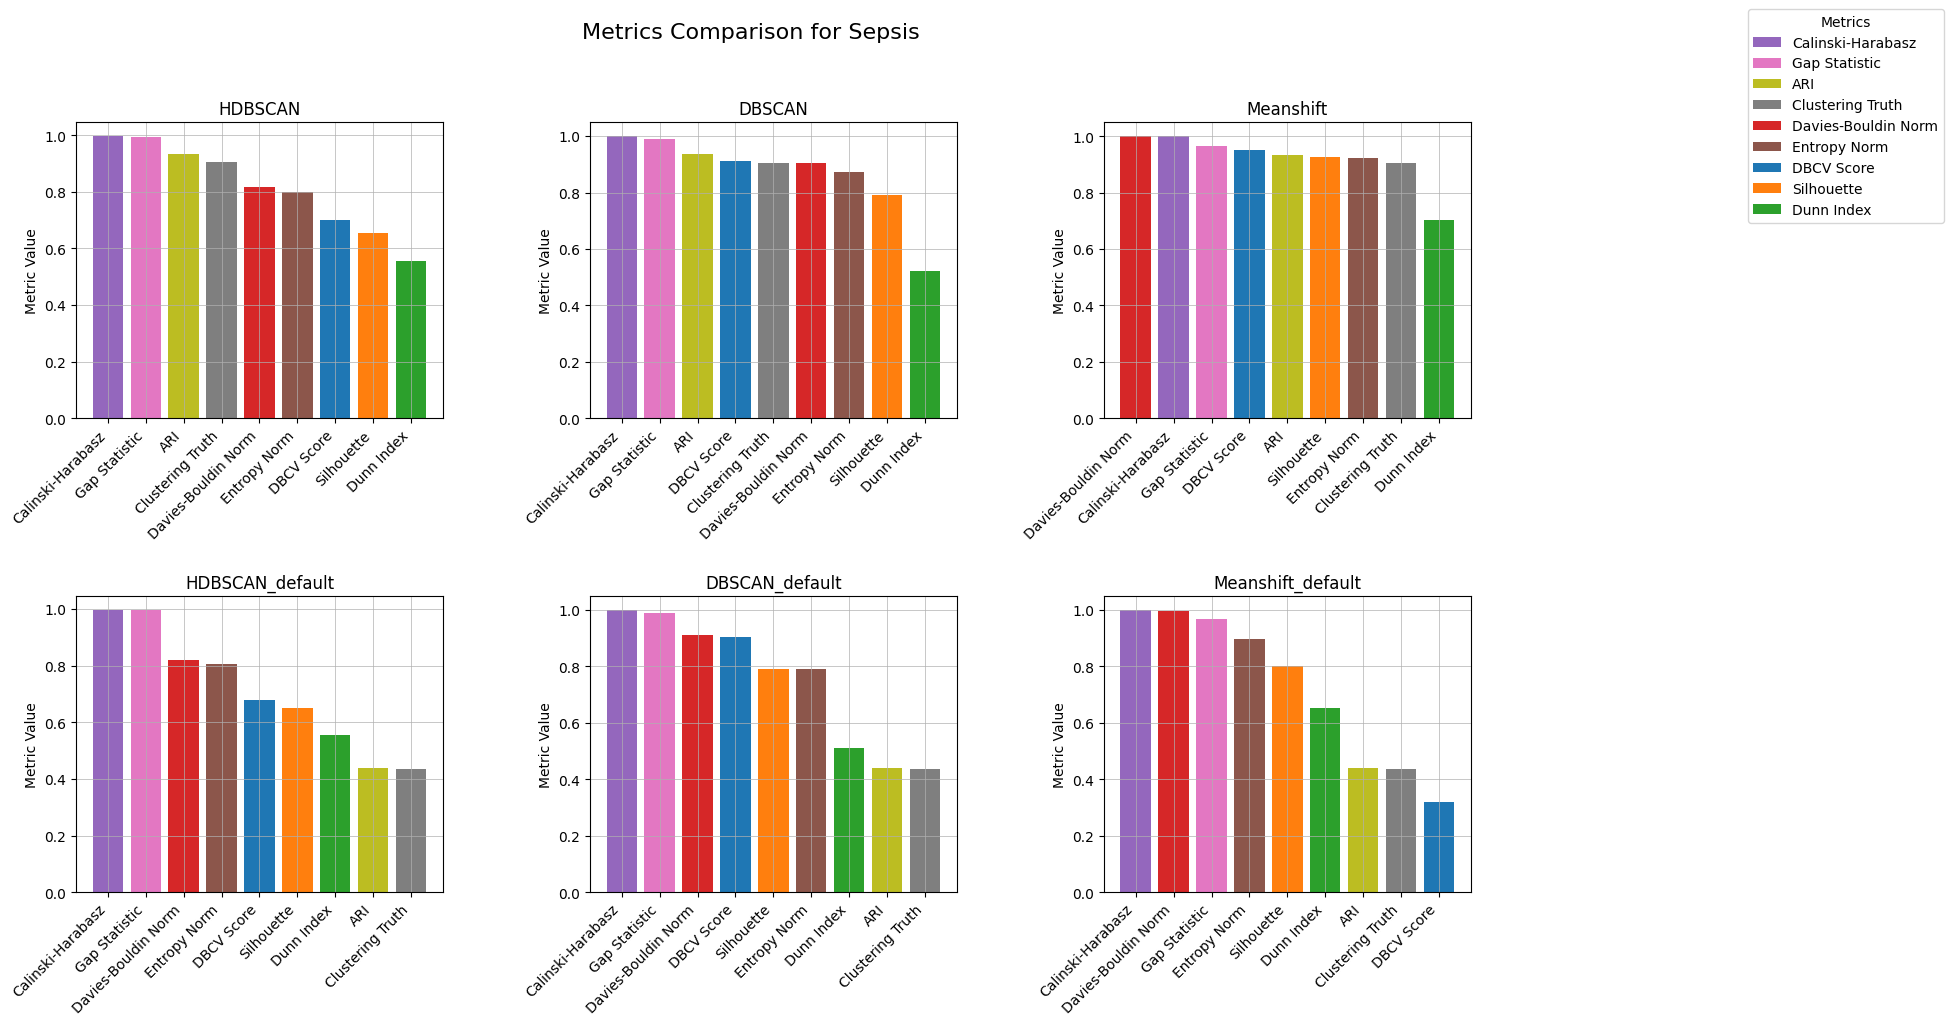

In [ ]:
df_metrics_sepsis.set_index("Method", inplace=True)

methods = df_metrics_sepsis.index.unique()
metric_colors = {col: plt.cm.tab10(i) for i, col in enumerate(df_metrics_sepsis.columns)}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, method in zip(axes, clustering_methods):
    sorted_metrics = df_metrics_sepsis.loc[method].sort_values(ascending=False)
    for i, metric in enumerate(sorted_metrics.index):
        ax.bar(i, sorted_metrics[metric], color=metric_colors[metric], label=metric)
    ax.set_title(method)
    ##ax.set_xlabel('Metric')
    ax.set_ylabel('Metric Value')
    ax.set_xticks(range(len(sorted_metrics)))
    ax.set_xticklabels(sorted_metrics.index, rotation=45, ha='right')
    ax.grid(True, linewidth=0.5)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.suptitle('Metrics Comparison for Sepsis', fontsize=16)

plt.show()


#**Heart failure**

In [ ]:
heart_failure = heart_failure.dropna(thresh=neuroblastoma.shape[1] - 2)
numerical_features = heart_failure.columns
scaler_minmax = MinMaxScaler()
heart_failure_scaled = heart_failure.copy()
heart_failure_scaled[numerical_features] = scaler_minmax.fit_transform(heart_failure_scaled[numerical_features])
heart_failure_scaled.reset_index(drop=True, inplace=True)
heart_failure_scaled.drop_duplicates(inplace=True)
df_metrics_heart_failure = pd.DataFrame()
heart_failure_scaled

Age (years)  Male (1=Yes, 0=No)  PHQ-9  Systolic BP (mm Hg)  \
0       0.923077                 0.0   0.04             0.540000   
1       1.000000                 1.0   0.32             0.340000   
2       0.794872                 1.0   0.16             0.380000   
3       0.833333                 1.0   0.16             0.326667   
4       0.807692                 1.0   0.12             0.520000   
..           ...                 ...    ...                  ...   
420     0.371795                 1.0   0.12             0.526667   
421     0.666667                 1.0   0.44             0.606667   
422     0.538462                 1.0   0.68             0.473333   
423     0.346154                 1.0   0.16             0.720000   
424     0.423077                 0.0   1.00             0.466667   

     Estimated glomerular filtration rate  Ejection fraction (%)  \
0                                0.253775               0.695035   
1                                0.169680               0.758865   
2                                0.325089               0.758865   
3                                0.360210               0.297872   
4                                0.324216               0.659574   
..                                    ...                    ...   
420                              0.457364               0.539007   
421                              0.148905               0.659574   
422                              0.673790               0.225532   
423                              0.331913               0.075603   
424                              0.218280               0.617021   

     Serum sodium (mmol/l)  Blood urea nitrogen (mg/dl)  \
0                 0.500000                     0.218487   
1                 0.636364                     0.630252   
2                 0.681818                     0.235294   
3                 0.681818                     0.394958   
4                 0.500000                     0.268908   
..                     ...                          ...   
420               0.500000                     0.226891   
421               0.590909                     0.352941   
422               0.181818                     0.142857   
423               0.636364                     0.285714   
424               0.681818                     0.647059   

     Etiology HF(1=Yes, 0=No)  Prior diabetes mellitus  \
0                         1.0                      1.0   
1                         1.0                      0.0   
2                         0.0                      0.0   
3                         0.0                      1.0   
4                         0.0                      1.0   
..                        ...                      ...   
420                       1.0                      1.0   
421                       0.0                      0.0   
422                       0.0                      1.0   
423                       0.0                      0.0   
424                       0.0                      1.0   

     Elevated level of BNP/NT-BNP (1=Yes, 0=No)  Time from HF to Death (days)  \
0                                           1.0                      0.929655   
1                                           1.0                      0.095172   
2                                           1.0                      1.000000   
3                                           1.0                      1.000000   
4                                           1.0                      1.000000   
..                                          ...                           ...   
420                                         1.0                      1.000000   
421                                         1.0                      1.000000   
422                                         1.0                      0.459310   
423                                         1.0                      1.000000   
424                                         1.0                      0.950

**HDBSCAN**

In [ ]:
min_size, epsilon= best_params_hdbscan(heart_failure_scaled)

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default= hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(heart_failure_scaled)
labels_default = hdbscan_cluster_default.fit_predict(heart_failure_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(heart_failure_scaled, labels)
heart_failure_scaled['HDBSCAN_pred'] = labels

methods = 'HDBSCAN'
methods_default = 'HDBSCAN_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(heart_failure_scaled.iloc[:, :-1], labels_default)
heart_failure_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df], ignore_index=True)
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df_default], ignore_index=True)

min_cluster_size: 3, cluster_selection_epsilon: 0.0


**DBSCAN**

In [ ]:
min_sample, eps = best_params_dbscan(heart_failure_scaled)

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(heart_failure_scaled)
labels_default = dbscan_default.fit_predict(heart_failure_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(heart_failure_scaled, labels)
heart_failure_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(heart_failure_scaled.iloc[:, :-1], labels_default)
heart_failure_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}


metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df], ignore_index=True)
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df_default], ignore_index=True)

min_cluster_size: 3, cluster_selection_epsilon: 0.5


**Mean_Shift**

In [ ]:
band = best_params_mean_shift(heart_failure_scaled)

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(heart_failure_scaled)
labels_default = mean_shift_default.fit_predict(heart_failure_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(heart_failure_scaled, labels)
heart_failure_scaled['Mean_shift_pred'] = labels

methods = 'Meanshift'
methods_default = 'Meanshift_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(heart_failure_scaled.iloc[:, :-1], labels_default)
heart_failure_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df], ignore_index=True)
df_metrics_heart_failure = pd.concat([df_metrics_heart_failure, metrics_df_default], ignore_index=True)
df_metrics_heart_failure

Best bandwidth: 6.341


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0            HDBSCAN        0.64        0.36    0.143838                 0.78   
1    HDBSCAN_default        0.56        0.27    0.163598                 0.75   
2             DBSCAN        0.60        0.18    0.012294                 0.62   
3     DBSCAN_default        0.50        0.07    0.008646                 0.45   
4          Meanshift        0.11        0.62    0.174758                 2.02   
5  Meanshift_default       -0.97        0.41    0.067738                 1.03   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  
0              37.61          0.35           0.48  
1              31.11          0.43           0.44  
2              36.50          1.01          -0.33  
3              31.04          1.18          -0.36  
4             418.24          0.88          -2.53  
5             263.30          0.37          -2.59

**Cluster Analysis**

In [ ]:
cluster_similarity = similar_cluster(heart_failure_scaled)
cluster_similarity

[ 2  1  0 21 12 11 23  5  6 13 19  9  8  7 20  3 15  4 10 16 14 22 18 24
 17 25 26]
[-1  0  1  2  3  4  5  6 17  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22
 23 24 26 25 27 28 29 30]
[10 -1 24 14 33  6  8 25 31  0 22 27 28 12 18 23  9 20 26 30 11 19 35 17
  4  5 34 29  1 13 36 16 15  2  3 32 21  7]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
1217            1      -1       -1     9.411765
2472            0       0       24     7.058824
2629            0       4       25     5.647059
21496           4      20       34     4.941176
10122           6       8       18     4.235294
...           ...     ...      ...          ...
10960          13      -1        9     0.000000
10959          13      -1       23     0.000000
10958          13      -1       18     0.000000
10957          13      -1       12     0.000000
32831          26      30        7     0.000000

[32832 rows x 4 columns]

In [ ]:
cluster_similarity_default = similar_cluster_default(heart_failure_scaled)
cluster_similarity_default

[0 1 2]
[-1  0  1 16  4 17  2  3 15  5  6  7  8  9 10 18 11 12 13 14]
[-1 14  6  1  3 15 23 12 17 21  5 10 13  2 18 24  4  9 19  8  0 16 22 20
  7 11]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
0              0      -1       -1    18.352941
547            1       0       14     5.882353
629            1       4       15     5.647059
957            1      11       16     4.941176
739            1      15       10     4.235294
...          ...     ...      ...          ...
524            1      -1        3     0.000000
523            1      -1        1     0.000000
522            1      -1        6     0.000000
519            0      14       11     0.000000
1559           2      14       11     0.000000

[1560 rows x 4 columns]

In [ ]:
heart_failure_scaled["DBSCAN_pred"] = heart_failure_scaled["DBSCAN_pred"].astype(object)
heart_failure_scaled["HDBSCAN_pred"] = heart_failure_scaled["HDBSCAN_pred"].astype(object)
heart_failure_scaled["Mean_shift_pred"] = heart_failure_scaled["Mean_shift_pred"].astype(object)

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'A'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == -1, "HDBSCAN_pred"] = 'A'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == -1, "Mean_shift_pred"] = 'A'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 0, "DBSCAN_pred"] = 'B'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 24, "HDBSCAN_pred"] = 'B'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'B'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 20, "DBSCAN_pred"] = 'C'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 34, "HDBSCAN_pred"] = 'C'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 4, "Mean_shift_pred"] = 'C'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 8, "DBSCAN_pred"] = 'D'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 18, "HDBSCAN_pred"] = 'D'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 6, "Mean_shift_pred"] = 'D'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 14, "DBSCAN_pred"] = 'E'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 35, "HDBSCAN_pred"] = 'E'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 7, "Mean_shift_pred"] = 'E'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 13, "DBSCAN_pred"] = 'F'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 19, "HDBSCAN_pred"] = 'F'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 8, "Mean_shift_pred"] = 'F'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 18, "DBSCAN_pred"] = 'G'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 30, "HDBSCAN_pred"] = 'G'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 3, "Mean_shift_pred"] = 'G'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 1, "DBSCAN_pred"] = 'H'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 14, "HDBSCAN_pred"] = 'H'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 2, "Mean_shift_pred"] = 'H'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 12, "DBSCAN_pred"] = 'I'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 11, "HDBSCAN_pred"] = 'I'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 5, "Mean_shift_pred"] = 'I'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 11, "DBSCAN_pred"] = 'J'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 26, "HDBSCAN_pred"] = 'J'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 13, "Mean_shift_pred"] = 'J'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 5, "DBSCAN_pred"] = 'K'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 31, "HDBSCAN_pred"] = 'K'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 11, "Mean_shift_pred"] = 'K'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 26, "DBSCAN_pred"] = 'L'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 36, "HDBSCAN_pred"] = 'L'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 14, "Mean_shift_pred"] = 'L'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 3, "DBSCAN_pred"] = 'M'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 8, "HDBSCAN_pred"] = 'M'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 12, "Mean_shift_pred"] = 'M'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 19, "DBSCAN_pred"] = 'N'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 17, "HDBSCAN_pred"] = 'N'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 15, "Mean_shift_pred"] = 'N'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 29, "DBSCAN_pred"] = 'O'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 21, "HDBSCAN_pred"] = 'O'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 17, "Mean_shift_pred"] = 'O'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 23, "DBSCAN_pred"] = 'P'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 13, "HDBSCAN_pred"] = 'P'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 16, "Mean_shift_pred"] = 'P'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_pred"] == 10, "DBSCAN_pred"] = 'Q'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_pred"] == 20, "HDBSCAN_pred"] = 'Q'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_pred"] == 19, "Mean_shift_pred"] = 'Q'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'A'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_default_pred"] == -1, "HDBSCAN_default_pred"] = 'A'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_default_pred"] == 0, "Mean_shift_default_pred"] = 'A'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_default_pred"] == 0, "DBSCAN_default_pred"] = 'B'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_default_pred"] == 14, "HDBSCAN_default_pred"] = 'B'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_default_pred"] == 1, "Mean_shift_default_pred"] = 'B'

heart_failure_scaled.loc[heart_failure_scaled["DBSCAN_default_pred"] == 13, "DBSCAN_default_pred"] = 'C'
heart_failure_scaled.loc[heart_failure_scaled["HDBSCAN_default_pred"] == -1, "HDBSCAN_default_pred"] = 'C'
heart_failure_scaled.loc[heart_failure_scaled["Mean_shift_default_pred"] == 2, "Mean_shift_default_pred"] = 'C'

heart_failure_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    heart_failure_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1, 'C': 2,'D': 3,'E': 4,'F': 5,'G': 6,'H': 7,'I': 8,
              'J': 9,'K': 10,'L': 11,'M': 12,'N': 13,'O': 14,'P': 15,'Q':16})
    .astype(int)
)

heart_failure_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]] = (
    heart_failure_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]]
    .replace({'A': 0, 'B': 1, 'C':2})
    .astype(int)
)

same_value_count = (heart_failure_scaled["HDBSCAN_pred"] == heart_failure_scaled["DBSCAN_pred"]) & \
                   (heart_failure_scaled["DBSCAN_pred"] == heart_failure_scaled["Mean_shift_pred"])

same_value_count_default = (heart_failure_scaled["HDBSCAN_default_pred"] == heart_failure_scaled["DBSCAN_default_pred"]) & \
                   (heart_failure_scaled["DBSCAN_default_pred"] == heart_failure_scaled["Mean_shift_default_pred"])

total_same_value = same_value_count.sum()
total_same_value_default = same_value_count_default.sum()
total_rows = len(heart_failure_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(heart_failure_scaled)

percentage_same_value_default = (total_same_value_default / total_rows) * 100
print("Totale delle righe con lo stesso valore con parametri default:", total_same_value_default)
print("Percentuale rispetto al totale:", round(percentage_same_value_default,2), "%")
percentage_same_value_default = round((percentage_same_value_default / 100),3)
ari_default = compute_ari_default(heart_failure_scaled)

df_metrics_heart_failure['Clustering Truth'] = df_metrics_heart_failure['Method'].apply(
    lambda x: percentage_same_value_default if 'default' in x else percentage_same_value)

df_metrics_heart_failure['ARI'] = df_metrics_heart_failure['Method'].apply(
    lambda x: ari_default if 'default' in x else ari)

df_metrics_heart_failure = df_metrics_heart_failure.sort_values('DBCV Score', ascending=False)


Totale delle righe con lo stesso valore: 180
Percentuale rispetto al totale: 42.35 %
Totale delle righe con lo stesso valore con parametri default: 115
Percentuale rispetto al totale: 27.06 %


**No normalizzazione**

In [ ]:
df_metrics_heart_failure

Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0            HDBSCAN        0.64        0.36    0.143838                 0.78   
2             DBSCAN        0.60        0.18    0.012294                 0.62   
1    HDBSCAN_default        0.56        0.27    0.163598                 0.75   
3     DBSCAN_default        0.50        0.07    0.008646                 0.45   
4          Meanshift        0.11        0.62    0.174758                 2.02   
5  Meanshift_default       -0.97        0.41    0.067738                 1.03   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
0              37.61          0.35           0.48             0.424  0.311523  
2              36.50          1.01          -0.33             0.424  0.311523  
1              31.11          0.43           0.44             0.271  0.203602  
3              31.04          1.18          -0.36             0.271  0.203602  
4             418.24          0.88          -2.53             0.424  0.311523  
5             263.30          0.37          -2.59             0.271  0.203602

In [ ]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score", "Silhouette", "Dunn Index",
    "Davies-Bouldin Norm", "Calinski-Harabasz",
    "Entropy Norm", "Gap Statistic"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in df_metrics_heart_failure.columns:
            best_value = df_metrics_heart_failure.loc[df_metrics_heart_failure["Method"] == method, metric_value].values[0]
            default_value = df_metrics_heart_failure.loc[df_metrics_heart_failure["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(df_metrics_heart_failure,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": round(best_value,3),
                "Default": round(default_value,3),
                "Method": method,
                "trend": trend,
                "Trend consistency with ARI": consistency
            })

final_table = pd.DataFrame(results)
print("Tab.9 Trend Conisentecy With ARI :\n")
final_table

Tab.9 Trend Conisentecy With ARI :



Metric  Best_parameters  Default     Method trend  \
0                DBCV            0.600    0.500     DBSCAN     ↓   
1          Silhouette            0.180    0.070     DBSCAN     ↓   
2                Dunn            0.012    0.009     DBSCAN     ↓   
3      Davies-Bouldin            0.620    0.450     DBSCAN     ↓   
4   Calinski-Harabasz           36.500   31.040     DBSCAN     ↓   
5             Entropy            1.010    1.180     DBSCAN     ↑   
6                 Gap           -0.330   -0.360     DBSCAN     ↓   
7                DBCV            0.640    0.560    HDBSCAN     ↓   
8          Silhouette            0.360    0.270    HDBSCAN     ↓   
9                Dunn            0.144    0.164    HDBSCAN     ↑   
10     Davies-Bouldin            0.780    0.750    HDBSCAN     ↓   
11  Calinski-Harabasz           37.610   31.110    HDBSCAN     ↓   
12            Entropy            0.350    0.430    HDBSCAN     ↑   
13                Gap            0.480    0.440    HDBSCAN     ↓   
14               DBCV            0.110   -0.970  Meanshift     ↓   
15         Silhouette            0.620    0.410  Meanshift     ↓   
16               Dunn            0.175    0.068  Meanshift     ↓   
17     Davies-Bouldin            2.020    1.030  Meanshift     ↓   
18  Calinski-Harabasz          418.240  263.300  Meanshift     ↓   
19            Entropy            0.880    0.370  Meanshift     ↓   
20                Gap           -2.530   -2.590  Meanshift     ↓   

   Trend consistency with ARI  
0                  Consistent  
1                  Consistent  
2                  Consistent  
3                  Consistent  
4                  Consistent  
5                Inconsistent  
6                  Consistent  
7                  Consistent  
8                  Consistent  
9                Inconsistent  
10                 Consistent  
11                 Consistent  
12               Inconsistent  
13                 Consistent  
14                 Consistent  
15                 Consistent  
16                 Consistent  
17                 Consistent  
18                 Consistent  
19                 Consistent  
20                 Consistent

In [ ]:
consistency_table = final_table.groupby("Metric")["Trend consistency with ARI"].value_counts().unstack(fill_value=0)
consistency_table = consistency_table.rename(columns={"Consistent": "N°Consistent", "Inconsistent": "N°Inconsistent"}).reset_index()
consistency_table = consistency_table.sort_values(by="N°Consistent", ascending=False).reset_index(drop=True)
consistency_table = consistency_table.to_string(index=False)
print(consistency_table)

           Metric  N°Consistent  N°Inconsistent
Calinski-Harabasz             3               0
             DBCV             3               0
   Davies-Bouldin             3               0
              Gap             3               0
       Silhouette             3               0
             Dunn             2               1
          Entropy             1               2


**Normalizzazione**

In [ ]:
df_metrics_heart_failure["Silhouette"] = (df_metrics_heart_failure["Silhouette"] + 1) / 2
df_metrics_heart_failure["DBCV Score"] = (df_metrics_heart_failure["DBCV Score"] + 1) / 2
df_metrics_heart_failure["Dunn Index"] = (erf(df_metrics_heart_failure["Dunn Index"]) + 1) / 2
df_metrics_heart_failure["Davies-Bouldin Norm"] = (erf(df_metrics_heart_failure["Davies-Bouldin Norm"]) + 1) / 2
df_metrics_heart_failure["Calinski-Harabasz"] = 1 - (1 / df_metrics_heart_failure["Calinski-Harabasz"])
df_metrics_heart_failure["Entropy Norm"] = (erf(df_metrics_heart_failure["Entropy Norm"]) + 1) / 2
df_metrics_heart_failure["Gap Statistic"] = (erf(df_metrics_heart_failure["Gap Statistic"]) + 1) / 2
df_metrics_heart_failure

Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0            HDBSCAN       0.820       0.680    0.580596             0.865005   
2             DBSCAN       0.800       0.590    0.506936             0.809706   
1    HDBSCAN_default       0.780       0.635    0.591483             0.855578   
3     DBSCAN_default       0.750       0.535    0.504878             0.737741   
4          Meanshift       0.555       0.810    0.597602             0.997860   
5  Meanshift_default       0.015       0.705    0.538159             0.927392   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
0           0.973411      0.689691       0.751375             0.424  0.311523  
2           0.972603      0.923405       0.320361             0.424  0.311523  
1           0.967856      0.728443       0.733113             0.271  0.203602  
3           0.967784      0.952419       0.305335             0.271  0.203602  
4           0.997609      0.893344       0.000173             0.424  0.311523  
5           0.996202      0.699603       0.000125             0.271  0.203602

In [ ]:
distance_table_heart_failure = df_metrics_heart_failure.copy()

for metric in metrics:
    distance_table_heart_failure[metric] = np.sqrt((df_metrics_heart_failure[metric] - df_metrics_heart_failure["Clustering Truth"]) ** 2)
distance_table_heart_failure = distance_table_heart_failure.sort_values(by="DBCV Score", ascending=True)
distance_table_heart_failure.columns = [
    f"{col} Distance" if col in metrics else col for col in distance_table_heart_failure.columns
]
distance_table_heart_failure

Method  DBCV Score Distance  Silhouette Distance  \
4          Meanshift                0.131                0.386   
5  Meanshift_default                0.256                0.434   
2             DBSCAN                0.376                0.166   
0            HDBSCAN                0.396                0.256   
3     DBSCAN_default                0.479                0.264   
1    HDBSCAN_default                0.509                0.364   

   Dunn Index Distance  Davies-Bouldin Norm Distance  \
4             0.173602                      0.573860   
5             0.267159                      0.656392   
2             0.082936                      0.385706   
0             0.156596                      0.441005   
3             0.233878                      0.466741   
1             0.320483                      0.584578   

   Calinski-Harabasz Distance  Entropy Norm Distance  Gap Statistic Distance  \
4                    0.573609               0.469344                0.423827   
5                    0.725202               0.428603                0.270875   
2                    0.548603               0.499405                0.103639   
0                    0.549411               0.265691                0.327375   
3                    0.696784               0.681419                0.034335   
1                    0.696856               0.457443                0.462113   

   Clustering Truth       ARI  
4             0.424  0.311523  
5             0.271  0.203602  
2             0.424  0.311523  
0             0.424  0.311523  
3             0.271  0.203602  
1             0.271  0.203602

In [ ]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score Distance", "Silhouette Distance", "Dunn Index Distance",
    "Davies-Bouldin Norm Distance", "Calinski-Harabasz Distance",
    "Entropy Norm Distance", "Gap Statistic Distance"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in distance_table_heart_failure.columns:
            best_value = distance_table_heart_failure.loc[distance_table_heart_failure["Method"] == method, metric_value].values[0]
            default_value = distance_table_heart_failure.loc[distance_table_heart_failure["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(distance_table_heart_failure,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": best_value,
                "Default": default_value,
                "Method": method,
                "trend": trend,
                "Trend consistency with ARI": consistency
            })

final_table = pd.DataFrame(results)
print("Tab.10 Trend Conisentecy With ARI :\n")
final_table

Tab.10 Trend Conisentecy With ARI :



Metric  Best_parameters   Default     Method trend  \
0                DBCV         0.376000  0.479000     DBSCAN     ↑   
1          Silhouette         0.166000  0.264000     DBSCAN     ↑   
2                Dunn         0.082936  0.233878     DBSCAN     ↑   
3      Davies-Bouldin         0.385706  0.466741     DBSCAN     ↑   
4   Calinski-Harabasz         0.548603  0.696784     DBSCAN     ↑   
5             Entropy         0.499405  0.681419     DBSCAN     ↑   
6                 Gap         0.103639  0.034335     DBSCAN     ↓   
7                DBCV         0.396000  0.509000    HDBSCAN     ↑   
8          Silhouette         0.256000  0.364000    HDBSCAN     ↑   
9                Dunn         0.156596  0.320483    HDBSCAN     ↑   
10     Davies-Bouldin         0.441005  0.584578    HDBSCAN     ↑   
11  Calinski-Harabasz         0.549411  0.696856    HDBSCAN     ↑   
12            Entropy         0.265691  0.457443    HDBSCAN     ↑   
13                Gap         0.327375  0.462113    HDBSCAN     ↑   
14               DBCV         0.131000  0.256000  Meanshift     ↑   
15         Silhouette         0.386000  0.434000  Meanshift     ↑   
16               Dunn         0.173602  0.267159  Meanshift     ↑   
17     Davies-Bouldin         0.573860  0.656392  Meanshift     ↑   
18  Calinski-Harabasz         0.573609  0.725202  Meanshift     ↑   
19            Entropy         0.469344  0.428603  Meanshift     ↓   
20                Gap         0.423827  0.270875  Meanshift     ↓   

   Trend consistency with ARI  
0                Inconsistent  
1                Inconsistent  
2                Inconsistent  
3                Inconsistent  
4                Inconsistent  
5                Inconsistent  
6                  Consistent  
7                Inconsistent  
8                Inconsistent  
9                Inconsistent  
10               Inconsistent  
11               Inconsistent  
12               Inconsistent  
13               Inconsistent  
14               Inconsistent  
15               Inconsistent  
16               Inconsistent  
17               Inconsistent  
18               Inconsistent  
19                 Consistent  
20                 Consistent

In [ ]:
consistency_table = final_table.groupby("Metric")["Trend consistency with ARI"].value_counts().unstack(fill_value=0)
consistency_table = consistency_table.rename(columns={"Consistent": "N°Consistent", "Inconsistent": "N°Inconsistent"}).reset_index()
consistency_table = consistency_table.sort_values(by="N°Consistent", ascending=False).reset_index(drop=True)
consistency_table = consistency_table.to_string(index=False)
print(consistency_table)

           Metric  N°Consistent  N°Inconsistent
              Gap             2               1
          Entropy             1               2
Calinski-Harabasz             0               3
             DBCV             0               3
   Davies-Bouldin             0               3
             Dunn             0               3
       Silhouette             0               3


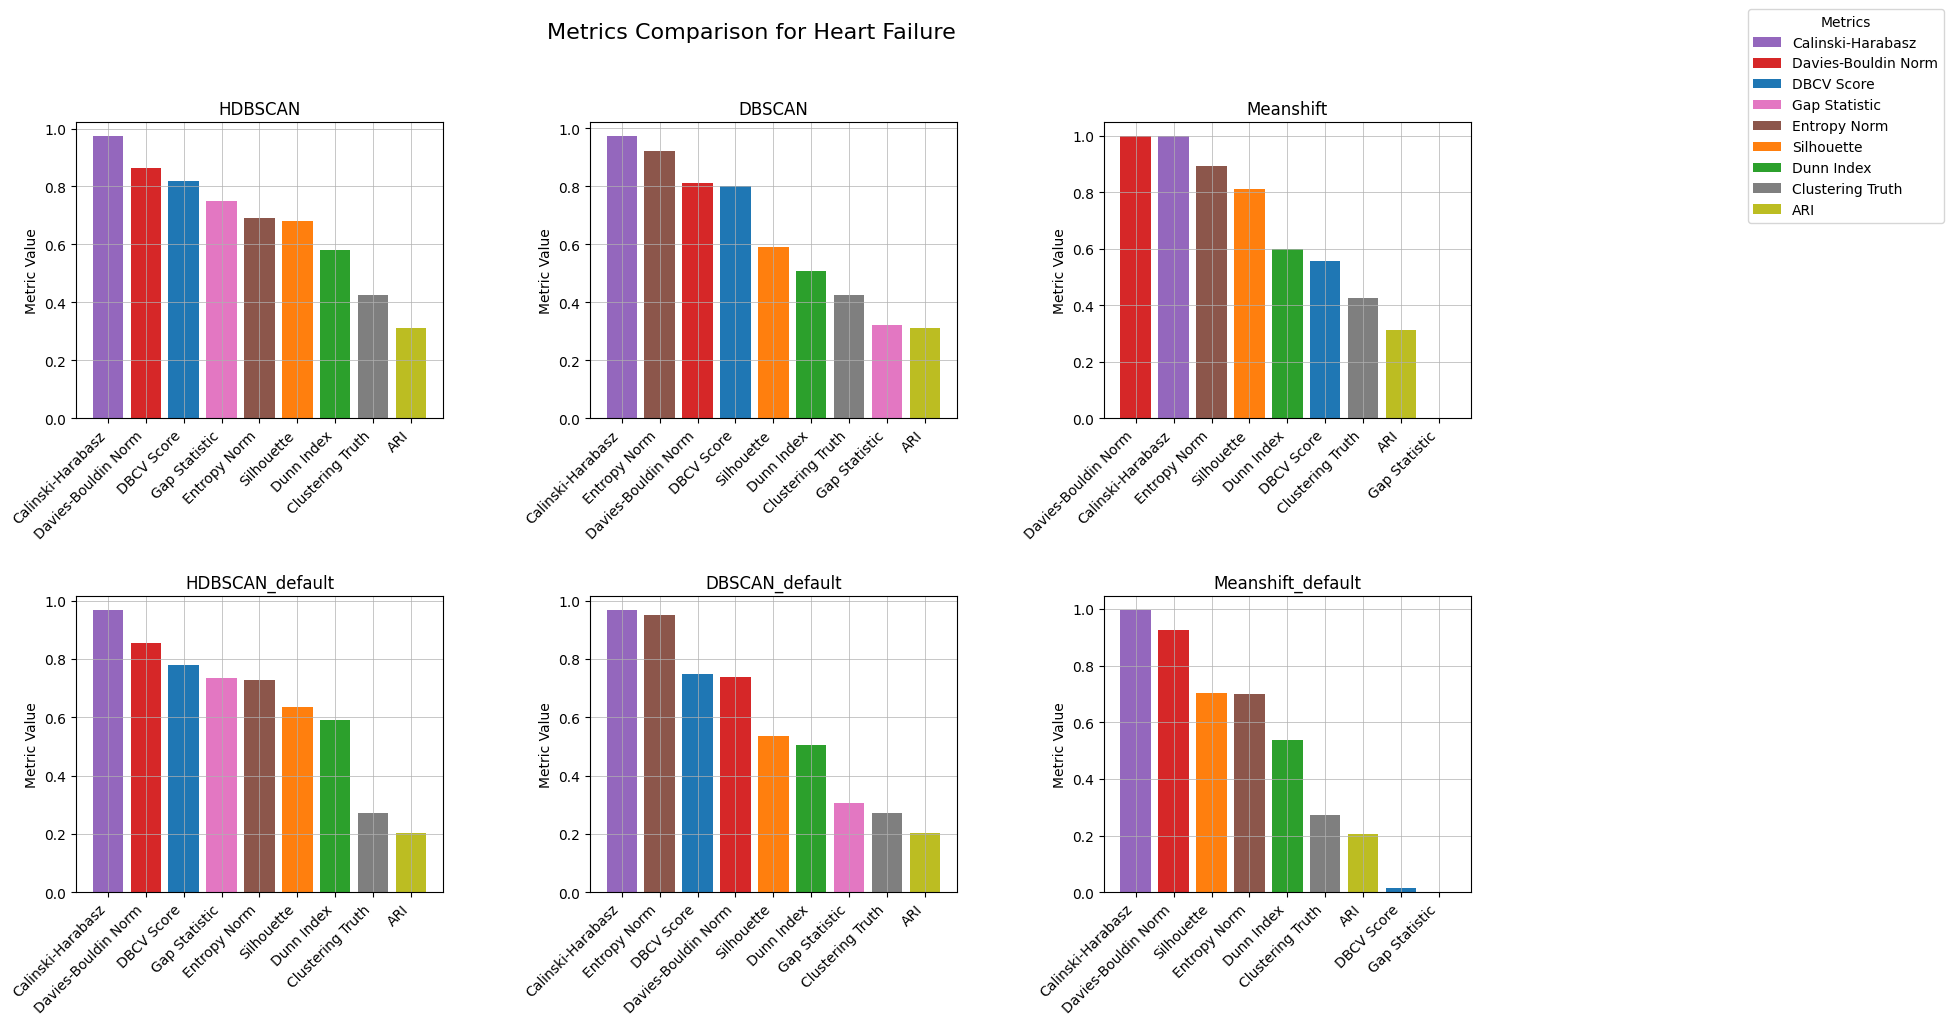

In [ ]:
df_metrics_heart_failure.set_index("Method", inplace=True)

methods = df_metrics_heart_failure.index.unique()
metric_colors = {col: plt.cm.tab10(i) for i, col in enumerate(df_metrics_heart_failure.columns)}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, method in zip(axes, clustering_methods):
    sorted_metrics = df_metrics_heart_failure.loc[method].sort_values(ascending=False)
    for i, metric in enumerate(sorted_metrics.index):
        ax.bar(i, sorted_metrics[metric], color=metric_colors[metric], label=metric)
    ax.set_title(method)
    ##ax.set_xlabel('Metric')
    ax.set_ylabel('Metric Value')
    ax.set_xticks(range(len(sorted_metrics)))
    ax.set_xticklabels(sorted_metrics.index, rotation=45, ha='right')
    ax.grid(True, linewidth=0.5)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.suptitle('Metrics Comparison for Heart Failure', fontsize=16)

plt.show()


#**Cardiac Arrest**

In [ ]:
cardiac_arrest = cardiac_arrest.fillna(0)
numerical_features = cardiac_arrest.columns
scaler_minmax = MinMaxScaler()
cardiac_arrest_scaled = cardiac_arrest.copy()
cardiac_arrest_scaled[numerical_features] = scaler_minmax.fit_transform(cardiac_arrest_scaled[numerical_features])
cardiac_arrest_scaled.reset_index(drop=True, inplace=True)
cardiac_arrest_scaled.drop_duplicates(inplace=True)
df_metrics_cardiac_arrest = pd.DataFrame()
cardiac_arrest_scaled

Exitus  sex_woman  Age_years  Endotracheal_intubation  Functional_status  \
0       1.0        0.0   0.340206                      1.0           1.000000   
1       1.0        1.0   0.402062                      1.0           1.000000   
2       1.0        0.0   0.505155                      1.0           1.000000   
3       0.0        0.0   0.505155                      1.0           1.000000   
4       1.0        0.0   0.515464                      1.0           1.000000   
..      ...        ...        ...                      ...                ...   
417     1.0        0.0   0.742268                      1.0           1.000000   
418     1.0        0.0   0.649485                      1.0           1.000000   
419     1.0        0.0   0.711340                      1.0           0.666667   
420     1.0        0.0   0.670103                      1.0           1.000000   
421     1.0        0.0   0.536082                      1.0           1.000000   

     Asystole  Cardiac_arrest_at_home  Bystander  Time_min  Cardiogenic  
0         1.0                     1.0        1.0  0.102041          1.0  
1         1.0                     1.0        1.0  0.204082          1.0  
2         0.0                     0.0        1.0  0.469388          0.0  
3         0.0                     1.0        1.0  0.142857          1.0  
4         0.0                     0.0        1.0  0.306122          1.0  
..        ...                     ...        ...       ...          ...  
417       0.0                     1.0        1.0  0.183673          1.0  
418       1.0                     1.0        1.0  0.387755          1.0  
419       1.0                     0.0        0.0  0.183673          1.0  
420       0.0                     1.0        0.0  0.306122          0.0  
421       1.0                     1.0        0.0  0.102041          0.0  

[420 rows x 10 columns]

**HDBSCAN**

In [ ]:
min_size, epsilon= best_params_hdbscan(cardiac_arrest_scaled)

hdbscan_cluster= hdbscan.HDBSCAN(min_cluster_size=min_size, cluster_selection_epsilon=epsilon)
hdbscan_cluster_default= hdbscan.HDBSCAN()

labels = hdbscan_cluster.fit_predict(cardiac_arrest_scaled)
labels_default = hdbscan_cluster_default.fit_predict(cardiac_arrest_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(cardiac_arrest_scaled, labels)
cardiac_arrest_scaled['HDBSCAN_pred'] = labels

methods = 'HDBSCAN'
methods_default = 'HDBSCAN_default'

metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(cardiac_arrest_scaled.iloc[:, :-1], labels_default)
cardiac_arrest_scaled['HDBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])

df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df], ignore_index=True)
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df_default], ignore_index=True)


min_cluster_size: 3, cluster_selection_epsilon: 0.5


**DBSCAN**

In [ ]:
min_sample, eps = best_params_dbscan(cardiac_arrest_scaled)

dbscan = DBSCAN(min_samples=min_sample, eps=eps)
dbscan_default = DBSCAN()

labels = dbscan.fit_predict(cardiac_arrest_scaled)
labels_default = dbscan_default.fit_predict(cardiac_arrest_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(cardiac_arrest_scaled, labels)
cardiac_arrest_scaled['DBSCAN_pred'] = labels

methods = 'DBSCAN'
methods_default = 'DBSCAN_default'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(cardiac_arrest_scaled.iloc[:, :-1], labels_default)
cardiac_arrest_scaled['DBSCAN_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}


metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df], ignore_index=True)
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df_default], ignore_index=True)
df_metrics_cardiac_arrest

min_cluster_size: 3, cluster_selection_epsilon: 0.5


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0          HDBSCAN        0.72        0.47    0.034848                 0.81   
1  HDBSCAN_default        0.61        0.36    0.021759                 0.78   
2           DBSCAN        0.80        0.58    0.012136                 1.11   
3   DBSCAN_default        0.69        0.60    0.012136                 2.46   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  
0              28.30          0.52          -0.04  
1              23.14          0.67          -0.02  
2             181.46          0.57          -0.96  
3             237.75          0.70          -0.95

**Mean_Shift**

In [ ]:
band = best_params_mean_shift(cardiac_arrest_scaled)

mean_shift = MeanShift(bandwidth=band)
mean_shift_default = MeanShift()

labels = mean_shift.fit_predict(cardiac_arrest_scaled)
labels_default = mean_shift_default.fit_predict(cardiac_arrest_scaled)

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(cardiac_arrest_scaled, labels)
cardiac_arrest_scaled['Mean_shift_pred'] = labels

methods = 'Meanshift'
methods_default = 'Meanshift_default'
metrics_dict = {
    'Method': methods,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}

dbcv_score, silhouette, dunn_index, davies_bouldin_norm, calinski_harabasz, shannon_entropy_norm, optimal_gap_statistic = compute_metrics(cardiac_arrest_scaled.iloc[:, :-1], labels_default)
cardiac_arrest_scaled['Mean_shift_default_pred'] = labels_default

metrics_dict_default = {
    'Method': methods_default,
    'DBCV Score': dbcv_score,
    'Silhouette': silhouette,
    'Dunn Index': dunn_index,
    'Davies-Bouldin Norm': davies_bouldin_norm,
    'Calinski-Harabasz': calinski_harabasz,
    'Entropy Norm': shannon_entropy_norm,
    'Gap Statistic': optimal_gap_statistic
}


metrics_df = pd.DataFrame([metrics_dict])
metrics_df_default = pd.DataFrame([metrics_dict_default])
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df], ignore_index=True)
df_metrics_cardiac_arrest = pd.concat([df_metrics_cardiac_arrest, metrics_df_default], ignore_index=True)
df_metrics_cardiac_arrest

Best bandwidth: 8.668


Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
0            HDBSCAN        0.72        0.47    0.034848                 0.81   
1    HDBSCAN_default        0.61        0.36    0.021759                 0.78   
2             DBSCAN        0.80        0.58    0.012136                 1.11   
3     DBSCAN_default        0.69        0.60    0.012136                 2.46   
4          Meanshift        0.08        0.62    0.267052                 1.72   
5  Meanshift_default       -0.90        0.50    0.093439                 1.36   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  
0              28.30          0.52          -0.04  
1              23.14          0.67          -0.02  
2             181.46          0.57          -0.96  
3             237.75          0.70          -0.95  
4             878.41          0.45          -2.39  
5             337.01          0.27          -2.40

**Cluster Analysis**

In [ ]:
cluster_similarity = similar_cluster(cardiac_arrest_scaled)
cluster_similarity

[ 2  7  1  0 11  4  3 10  6  9  5  8 12]
[ 0  1  2 -1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 40 35 36 37 38 39 41]
[34 32 10 -1 22  2 30 25 26 21 27 23 33 11 13 20 14 19 17 35 29 15 31 28
 18  9  0  6  7 16  5 24 12  3  8  1  4]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
3296            1      -1       -1    14.523810
0               2       0       34     6.666667
10231           3      17       35     5.952381
5077            0       7       26     5.000000
4925            0       3       22     4.285714
...           ...     ...      ...          ...
6903           11      13       15     0.000000
6902           11      13       29     0.000000
6901           11      13       35     0.000000
6900           11      13       17     0.000000
20682          12      41        4     0.000000

[20683 rows x 4 columns]

In [ ]:
cluster_similarity_default = similar_cluster_default(cardiac_arrest_scaled)
cluster_similarity_default

[0 1 2]
[ 0  1  2 -1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26]
[23 22  7 -1 12 18 14 15 11 13 17 24  3  4  9  8 25 21  6 19 20 10  1  2
  5  0 16]


Mean_shift  DBSCAN  HDBSCAN  Percentuale
840            1      -1       -1    16.428571
1596           2      -1       -1    10.000000
0              0       0       23     6.666667
475            0      16       25     5.952381
196            0       6       15     5.000000
...          ...     ...      ...          ...
764            1       0       11     0.000000
763            1       0       15     0.000000
762            1       0       14     0.000000
761            1       0       18     0.000000
2267           2      26       16     0.000000

[2268 rows x 4 columns]

In [ ]:
cardiac_arrest_scaled["DBSCAN_pred"] = cardiac_arrest_scaled["DBSCAN_pred"].astype(object)
cardiac_arrest_scaled["HDBSCAN_pred"] = cardiac_arrest_scaled["HDBSCAN_pred"].astype(object)
cardiac_arrest_scaled["Mean_shift_pred"] = cardiac_arrest_scaled["Mean_shift_pred"].astype(object)

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == -1, "DBSCAN_pred"] = 'A'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == -1, "HDBSCAN_pred"] = 'A'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 1, "Mean_shift_pred"] = 'A'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 0, "DBSCAN_pred"] = 'B'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 34, "HDBSCAN_pred"] = 'B'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] ==2, "Mean_shift_pred"] = 'B'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 17, "DBSCAN_pred"] = 'C'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 35, "HDBSCAN_pred"] = 'C'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 3, "Mean_shift_pred"] = 'C'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 7, "DBSCAN_pred"] = 'D'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 26, "HDBSCAN_pred"] = 'D'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 0, "Mean_shift_pred"] = 'D'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 1, "DBSCAN_pred"] = 'E'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 32, "HDBSCAN_pred"] = 'E'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 2, "Mean_shift_pred"] = 'E'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 13, "DBSCAN_pred"] = 'F'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 20, "HDBSCAN_pred"] = 'F'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 4, "Mean_shift_pred"] = 'F'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 32, "DBSCAN_pred"] = 'G'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 24, "HDBSCAN_pred"] = 'G'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 8, "Mean_shift_pred"] = 'G'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 22, "DBSCAN_pred"] = 'H'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 18, "HDBSCAN_pred"] = 'H'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 10, "Mean_shift_pred"] = 'H'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_pred"] == 30, "DBSCAN_pred"] = 'I'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_pred"] == 5, "HDBSCAN_pred"] = 'I'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_pred"] == 6, "Mean_shift_pred"] = 'I'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_default_pred"] == -1, "DBSCAN_default_pred"] = 'A'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_default_pred"] == -1, "HDBSCAN_default_pred"] = 'A'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_default_pred"] == 1, "Mean_shift_default_pred"] = 'A'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_default_pred"] == 0, "DBSCAN_default_pred"] = 'B'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_default_pred"] == 23, "HDBSCAN_default_pred"] = 'B'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_default_pred"] == 0, "Mean_shift_default_pred"] = 'B'

cardiac_arrest_scaled.loc[cardiac_arrest_scaled["DBSCAN_default_pred"] == 25, "DBSCAN_default_pred"] = 'C'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["HDBSCAN_default_pred"] == 0, "HDBSCAN_default_pred"] = 'C'
cardiac_arrest_scaled.loc[cardiac_arrest_scaled["Mean_shift_default_pred"] == 2, "Mean_shift_default_pred"] = 'C'

cardiac_arrest_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]] = (
    cardiac_arrest_scaled[["DBSCAN_pred", "HDBSCAN_pred", "Mean_shift_pred"]]
    .replace({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8,})
    .astype(int)
)

cardiac_arrest_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]] = (
    cardiac_arrest_scaled[["DBSCAN_default_pred", "HDBSCAN_default_pred", "Mean_shift_default_pred"]]
    .replace({'A': 0, 'B': 1, 'C':2})
    .astype(int)
)

same_value_count = (cardiac_arrest_scaled["HDBSCAN_pred"] == cardiac_arrest_scaled["DBSCAN_pred"]) & \
                   (cardiac_arrest_scaled["DBSCAN_pred"] == cardiac_arrest_scaled["Mean_shift_pred"])

same_value_count_default = (cardiac_arrest_scaled["HDBSCAN_default_pred"] == cardiac_arrest_scaled["DBSCAN_default_pred"]) & \
                   (cardiac_arrest_scaled["DBSCAN_default_pred"] == cardiac_arrest_scaled["Mean_shift_default_pred"])

total_same_value = same_value_count.sum()
total_same_value_deafult = same_value_count_default.sum()
total_rows = len(cardiac_arrest_scaled)

percentage_same_value = (total_same_value / total_rows) * 100
print("Totale delle righe con lo stesso valore:", total_same_value)
print("Percentuale rispetto al totale:", round(percentage_same_value,2), "%")
percentage_same_value = round((percentage_same_value / 100),3)
ari = compute_ari(cardiac_arrest_scaled)

percentage_same_value_default = (total_same_value_default / total_rows) * 100
print("Totale delle righe con lo stesso valore con parametri default:", total_same_value_default)
print("Percentuale rispetto al totale:", round(percentage_same_value_default,2), "%")
percentage_same_value_default = round((percentage_same_value_default / 100),3)
ari_default = compute_ari_default(cardiac_arrest_scaled)

df_metrics_cardiac_arrest['Clustering Truth'] = df_metrics_cardiac_arrest['Method'].apply(
    lambda x: percentage_same_value_default if 'default' in x else percentage_same_value)

df_metrics_cardiac_arrest['ARI'] = df_metrics_cardiac_arrest['Method'].apply(
    lambda x: ari_default if 'default' in x else ari)

df_metrics_cardiac_arrest = df_metrics_cardiac_arrest.sort_values('DBCV Score', ascending=False)


Totale delle righe con lo stesso valore: 182
Percentuale rispetto al totale: 43.33 %
Totale delle righe con lo stesso valore con parametri default: 115
Percentuale rispetto al totale: 27.38 %


**No normalizzazione**

In [ ]:
df_metrics_cardiac_arrest

Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
2             DBSCAN        0.80        0.58    0.012136                 1.11   
0            HDBSCAN        0.72        0.47    0.034848                 0.81   
3     DBSCAN_default        0.69        0.60    0.012136                 2.46   
1    HDBSCAN_default        0.61        0.36    0.021759                 0.78   
4          Meanshift        0.08        0.62    0.267052                 1.72   
5  Meanshift_default       -0.90        0.50    0.093439                 1.36   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
2             181.46          0.57          -0.96             0.433  0.496299  
0              28.30          0.52          -0.04             0.433  0.496299  
3             237.75          0.70          -0.95             0.274  0.314027  
1              23.14          0.67          -0.02             0.274  0.314027  
4             878.41          0.45          -2.39             0.433  0.496299  
5             337.01          0.27          -2.40             0.274  0.314027

In [ ]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score", "Silhouette", "Dunn Index",
    "Davies-Bouldin Norm", "Calinski-Harabasz",
    "Entropy Norm", "Gap Statistic"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in df_metrics_cardiac_arrest.columns:
            best_value = df_metrics_cardiac_arrest.loc[df_metrics_cardiac_arrest["Method"] == method, metric_value].values[0]
            default_value = df_metrics_cardiac_arrest.loc[df_metrics_cardiac_arrest["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(df_metrics_cardiac_arrest,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": round(best_value,3),
                "Default": round(default_value,3),
                "Method": method,
                "trend": trend,
                "Trend consistency with ARI": consistency
            })

final_table = pd.DataFrame(results)
print("Tab.11 Trend Conisentecy With ARI :\n")
final_table

Tab.11 Trend Conisentecy With ARI :



Metric  Best_parameters  Default     Method trend  \
0                DBCV            0.800    0.690     DBSCAN     ↓   
1          Silhouette            0.580    0.600     DBSCAN     ↑   
2                Dunn            0.012    0.012     DBSCAN     ↓   
3      Davies-Bouldin            1.110    2.460     DBSCAN     ↑   
4   Calinski-Harabasz          181.460  237.750     DBSCAN     ↑   
5             Entropy            0.570    0.700     DBSCAN     ↑   
6                 Gap           -0.960   -0.950     DBSCAN     ↑   
7                DBCV            0.720    0.610    HDBSCAN     ↓   
8          Silhouette            0.470    0.360    HDBSCAN     ↓   
9                Dunn            0.035    0.022    HDBSCAN     ↓   
10     Davies-Bouldin            0.810    0.780    HDBSCAN     ↓   
11  Calinski-Harabasz           28.300   23.140    HDBSCAN     ↓   
12            Entropy            0.520    0.670    HDBSCAN     ↑   
13                Gap           -0.040   -0.020    HDBSCAN     ↑   
14               DBCV            0.080   -0.900  Meanshift     ↓   
15         Silhouette            0.620    0.500  Meanshift     ↓   
16               Dunn            0.267    0.093  Meanshift     ↓   
17     Davies-Bouldin            1.720    1.360  Meanshift     ↓   
18  Calinski-Harabasz          878.410  337.010  Meanshift     ↓   
19            Entropy            0.450    0.270  Meanshift     ↓   
20                Gap           -2.390   -2.400  Meanshift     ↓   

   Trend consistency with ARI  
0                  Consistent  
1                Inconsistent  
2                  Consistent  
3                Inconsistent  
4                Inconsistent  
5                Inconsistent  
6                Inconsistent  
7                  Consistent  
8                  Consistent  
9                  Consistent  
10                 Consistent  
11                 Consistent  
12               Inconsistent  
13               Inconsistent  
14                 Consistent  
15                 Consistent  
16                 Consistent  
17                 Consistent  
18                 Consistent  
19                 Consistent  
20                 Consistent

In [ ]:
consistency_table = final_table.groupby("Metric")["Trend consistency with ARI"].value_counts().unstack(fill_value=0)
consistency_table = consistency_table.rename(columns={"Consistent": "N°Consistent", "Inconsistent": "N°Inconsistent"}).reset_index()
consistency_table = consistency_table.sort_values(by="N°Consistent", ascending=False).reset_index(drop=True)
consistency_table = consistency_table.to_string(index=False)
print(consistency_table)

           Metric  N°Consistent  N°Inconsistent
             DBCV             3               0
             Dunn             3               0
Calinski-Harabasz             2               1
   Davies-Bouldin             2               1
       Silhouette             2               1
          Entropy             1               2
              Gap             1               2


**Normalizzazione**

In [ ]:
df_metrics_cardiac_arrest["Silhouette"] = (df_metrics_cardiac_arrest["Silhouette"] + 1) / 2
df_metrics_cardiac_arrest["DBCV Score"] = (df_metrics_cardiac_arrest["DBCV Score"] + 1) / 2
df_metrics_cardiac_arrest["Dunn Index"] = (erf(df_metrics_cardiac_arrest["Dunn Index"]) + 1) / 2
df_metrics_cardiac_arrest["Davies-Bouldin Norm"] = (erf(df_metrics_cardiac_arrest["Davies-Bouldin Norm"]) + 1) / 2
df_metrics_cardiac_arrest["Calinski-Harabasz"] = 1 - (1 / df_metrics_cardiac_arrest["Calinski-Harabasz"])
df_metrics_cardiac_arrest["Entropy Norm"] = (erf(df_metrics_cardiac_arrest["Entropy Norm"]) + 1) / 2
df_metrics_cardiac_arrest["Gap Statistic"] = (erf(df_metrics_cardiac_arrest["Gap Statistic"]) + 1) / 2
df_metrics_cardiac_arrest

Method  DBCV Score  Silhouette  Dunn Index  Davies-Bouldin Norm  \
2             DBSCAN       0.900       0.790    0.506847             0.941767   
0            HDBSCAN       0.860       0.735    0.519653             0.874002   
3     DBSCAN_default       0.845       0.800    0.506847             0.999748   
1    HDBSCAN_default       0.805       0.680    0.512274             0.865005   
4          Meanshift       0.540       0.810    0.647162             0.992501   
5  Meanshift_default       0.050       0.750    0.552564             0.972781   

   Calinski-Harabasz  Entropy Norm  Gap Statistic  Clustering Truth       ARI  
2           0.994489      0.789908       0.087288             0.433  0.496299  
0           0.964664      0.768949       0.477444             0.433  0.496299  
3           0.995794      0.838901       0.089555             0.274  0.314027  
1           0.956785      0.828314       0.488718             0.274  0.314027  
4           0.998862      0.737741       0.000362             0.433  0.496299  
5           0.997033      0.648709       0.000344             0.274  0.314027

In [ ]:
distance_table_cardiac_arrest = df_metrics_cardiac_arrest.copy()

for metric in metrics:
    distance_table_cardiac_arrest[metric] = np.sqrt((df_metrics_cardiac_arrest[metric] - df_metrics_cardiac_arrest["Clustering Truth"]) ** 2)
distance_table_cardiac_arrest = distance_table_cardiac_arrest.sort_values(by="DBCV Score", ascending=True)
distance_table_cardiac_arrest.columns = [
    f"{col} Distance" if col in metrics else col for col in distance_table_cardiac_arrest.columns
]
distance_table_cardiac_arrest

Method  DBCV Score Distance  Silhouette Distance  \
4          Meanshift                0.107                0.377   
5  Meanshift_default                0.224                0.476   
0            HDBSCAN                0.427                0.302   
2             DBSCAN                0.467                0.357   
1    HDBSCAN_default                0.531                0.406   
3     DBSCAN_default                0.571                0.526   

   Dunn Index Distance  Davies-Bouldin Norm Distance  \
4             0.214162                      0.559501   
5             0.278564                      0.698781   
0             0.086653                      0.441002   
2             0.073847                      0.508767   
1             0.238274                      0.591005   
3             0.232847                      0.725748   

   Calinski-Harabasz Distance  Entropy Norm Distance  Gap Statistic Distance  \
4                    0.565862               0.304741                0.432638   
5                    0.723033               0.374709                0.273656   
0                    0.531664               0.335949                0.044444   
2                    0.561489               0.356908                0.345712   
1                    0.682785               0.554314                0.214718   
3                    0.721794               0.564901                0.184445   

   Clustering Truth       ARI  
4             0.433  0.496299  
5             0.274  0.314027  
0             0.433  0.496299  
2             0.433  0.496299  
1             0.274  0.314027  
3             0.274  0.314027

In [ ]:
results = []
methods = ["DBSCAN", "HDBSCAN", "Meanshift"]
default_methods = {
    "DBSCAN": "DBSCAN_default",
    "HDBSCAN": "HDBSCAN_default",
    "Meanshift": "Meanshift_default"
}
metrics_distance = [
    "DBCV Score Distance", "Silhouette Distance", "Dunn Index Distance",
    "Davies-Bouldin Norm Distance", "Calinski-Harabasz Distance",
    "Entropy Norm Distance", "Gap Statistic Distance"
]


for method in methods:
    for metric_value in metrics_distance:
        if metric_value in distance_table_cardiac_arrest.columns:
            best_value = distance_table_cardiac_arrest.loc[distance_table_cardiac_arrest["Method"] == method, metric_value].values[0]
            default_value = distance_table_cardiac_arrest.loc[distance_table_cardiac_arrest["Method"] == default_methods[method], metric_value].values[0]
            trend, consistency = calculate_trend_and_consistency(distance_table_cardiac_arrest,metric_value, method, default_methods[method])
            results.append({
                "Metric": metric_value.split(" ")[0],
                "Best_parameters": best_value,
                "Default": default_value,
                "Method": method,
                "trend": trend,
                "Trend consistency with ARI": consistency
            })

final_table = pd.DataFrame(results)
print("Tab.12 Trend Conisentecy With ARI :\n")
final_table

Tab.12 Trend Conisentecy With ARI :



Metric  Best_parameters   Default     Method trend  \
0                DBCV         0.467000  0.571000     DBSCAN     ↑   
1          Silhouette         0.357000  0.526000     DBSCAN     ↑   
2                Dunn         0.073847  0.232847     DBSCAN     ↑   
3      Davies-Bouldin         0.508767  0.725748     DBSCAN     ↑   
4   Calinski-Harabasz         0.561489  0.721794     DBSCAN     ↑   
5             Entropy         0.356908  0.564901     DBSCAN     ↑   
6                 Gap         0.345712  0.184445     DBSCAN     ↓   
7                DBCV         0.427000  0.531000    HDBSCAN     ↑   
8          Silhouette         0.302000  0.406000    HDBSCAN     ↑   
9                Dunn         0.086653  0.238274    HDBSCAN     ↑   
10     Davies-Bouldin         0.441002  0.591005    HDBSCAN     ↑   
11  Calinski-Harabasz         0.531664  0.682785    HDBSCAN     ↑   
12            Entropy         0.335949  0.554314    HDBSCAN     ↑   
13                Gap         0.044444  0.214718    HDBSCAN     ↑   
14               DBCV         0.107000  0.224000  Meanshift     ↑   
15         Silhouette         0.377000  0.476000  Meanshift     ↑   
16               Dunn         0.214162  0.278564  Meanshift     ↑   
17     Davies-Bouldin         0.559501  0.698781  Meanshift     ↑   
18  Calinski-Harabasz         0.565862  0.723033  Meanshift     ↑   
19            Entropy         0.304741  0.374709  Meanshift     ↑   
20                Gap         0.432638  0.273656  Meanshift     ↓   

   Trend consistency with ARI  
0                Inconsistent  
1                Inconsistent  
2                Inconsistent  
3                Inconsistent  
4                Inconsistent  
5                Inconsistent  
6                  Consistent  
7                Inconsistent  
8                Inconsistent  
9                Inconsistent  
10               Inconsistent  
11               Inconsistent  
12               Inconsistent  
13               Inconsistent  
14               Inconsistent  
15               Inconsistent  
16               Inconsistent  
17               Inconsistent  
18               Inconsistent  
19               Inconsistent  
20                 Consistent

In [ ]:
consistency_table = final_table.groupby("Metric")["Trend consistency with ARI"].value_counts().unstack(fill_value=0)
consistency_table = consistency_table.rename(columns={"Consistent": "N°Consistent", "Inconsistent": "N°Inconsistent"}).reset_index()
consistency_table = consistency_table.sort_values(by="N°Consistent", ascending=False).reset_index(drop=True)
consistency_table = consistency_table.to_string(index=False)
print(consistency_table)

           Metric  N°Consistent  N°Inconsistent
              Gap             2               1
Calinski-Harabasz             0               3
             DBCV             0               3
   Davies-Bouldin             0               3
             Dunn             0               3
          Entropy             0               3
       Silhouette             0               3


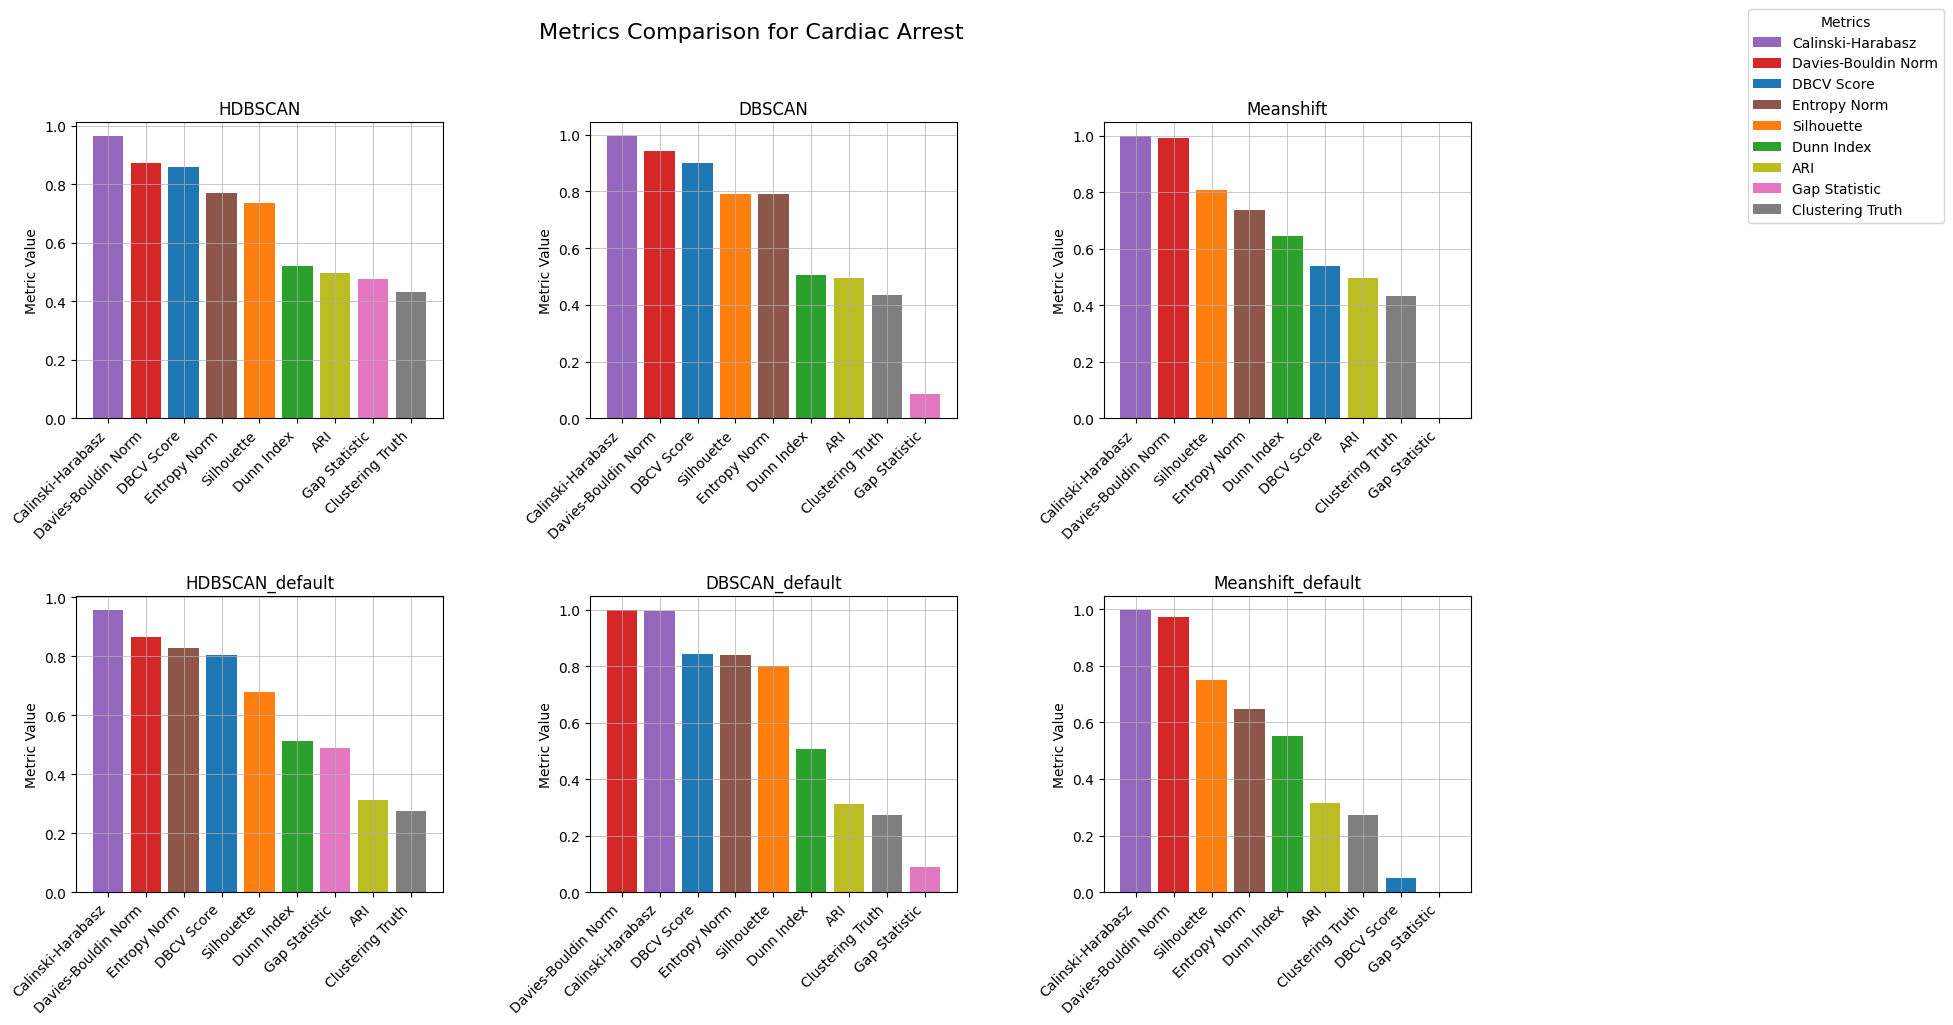

In [ ]:
df_metrics_cardiac_arrest.set_index("Method", inplace=True)

methods = df_metrics_cardiac_arrest.index.unique()
metric_colors = {col: plt.cm.tab10(i) for i, col in enumerate(df_metrics_cardiac_arrest.columns)}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for ax, method in zip(axes, clustering_methods):
    sorted_metrics = df_metrics_cardiac_arrest.loc[method].sort_values(ascending=False)
    for i, metric in enumerate(sorted_metrics.index):
        ax.bar(i, sorted_metrics[metric], color=metric_colors[metric], label=metric)
    ax.set_title(method)
    ##ax.set_xlabel('Metric')
    ax.set_ylabel('Metric Value')
    ax.set_xticks(range(len(sorted_metrics)))
    ax.set_xticklabels(sorted_metrics.index, rotation=45, ha='right')
    ax.grid(True, linewidth=0.5)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title="Metrics", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.subplots_adjust(wspace=0.4, hspace=0.6)
plt.suptitle('Metrics Comparison for Cardiac Arrest', fontsize=16)

plt.show()
